# <span style='color:brown'> Vietnam Daily Weather Analysis & Forecasting

## <span style='color:blue'> Step 2 · Data Understanding

This notebook follows the requested workflow:
- explain every column and inspect value distributions;
- visualise the temperature target (Hanoi proxy) across the available timeframe;
- study relationships between variables before modelling.

> **Note:** The raw file contains Ho Chi Minh City observations; we use it as a proxy for Hanoi because the shared data folder only includes this feed. The engineering steps stay identical for Hanoi data once available.

In [1]:
import warnings
import math
import random
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style='darkgrid')

In [2]:
DATA_PATH = "https://raw.githubusercontent.com/hoducmanh222/temp_holder/main/weather_hcm_daily.csv"
df_raw = pd.read_csv(DATA_PATH)
print(f'Dataset shape: {df_raw.shape}')
print(f"Sampling period: {df_raw['datetime'].min()} ? {df_raw['datetime'].max()} ({df_raw.shape[0]} days)")
display(df_raw.head())

Dataset shape: (3927, 38)
Sampling period: 2015-01-01 ? 2025-10-01 (3927 days)


name           address        resolvedAddress  latitude  \
0  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
1  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
2  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
3  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
4  Hồ Chí Minh city  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   

   longitude    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0    106.701  2015-01-01     31.0     23.0  26.6          31.4          23.0   
1    106.701  2015-01-02     30.0     20.0  25.0          30.4          20.0   
2    106.701  2015-01-03     32.0     23.0  26.8          33.5          23.0   
3    106.701  2015-01-04     32.0     24.0  27.1          34.8          24.0   
4    106.701  2015-01-05     30.6     24.9  26.7          33.2          24.9   

   feelslike   dew  humidity  precip  precipprob  precipcover preciptype  \
0       26.8  17.9      60.3     0.0           0         0.00        NaN   
1       25.1  15.8      57.2     0.0           0         0.00        NaN   
2       27.4  19.0      63.7     0.2         100         8.33       rain   
3       28.3  21.3      71.7     0.0           0         0.00        NaN   
4       27.7  22.1      76.4     6.0         100         4.17       rain   

   windgust  windspeed  windspeedmax  windspeedmean  windspeedmin  winddir  \
0      20.5       15.4          15.4            7.9           2.9     27.3   
1      21.6       13.0          13.0            7.2           2.9    331.6   
2      23.8       11.2          11.2            7.8           1.8      9.5   
3      22.7       10.8          10.8            6.3           2.9    237.4   
4      24.8       11.6          11.6            5.5           1.1    168.5   

   sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
0            1012.5        53.8         8.9           230.6         19.9   
1            1013.0        66.3        10.2           186.2         16.1   
2            1012.0        52.7         9.8           185.8         16.0   
3            1010.2        59.3         8.4           125.8         10.9   
4            1010.0        78.0         9.1           163.4         14.1   

   uvindex  severerisk              sunrise               sunset  moonphase  \
0        8         NaN  2015-01-01T06:11:22  2015-01-01T17:41:39       0.36   
1        7         NaN  2015-01-02T06:11:46  2015-01-02T17:42:12       0.39   
2        8         NaN  2015-01-03T06:12:09  2015-01-03T17:42:44       0.43   
3        4         NaN  2015-01-04T06:12:32  2015-01-04T17:43:17       0.46   
4        8         NaN  2015-01-05T06:12:54  2015-01-05T17:43:50       0.50   

               conditions                                        description  \
0        Partially cloudy                  Partly cloudy throughout the day.   
1        Partially cloudy                  Partly cloudy throughout the day.   
2  Rain, Partially cloudy  Partly cloudy throughout the day with rain in ...   
3        Partially cloudy                  Partly cloudy throughout the day.   
4  Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   

                icon source  
0  partly-cloudy-day    obs  
1  partly-cloudy-day    obs  
2               rain    obs  
3  partly-cloudy-day    obs  
4               rain    obs

In [3]:
column_descriptions = OrderedDict([
    ('name', 'Human-readable location name returned by the weather provider.'),
    ('address', 'Original query string for the location.'),
    ('resolvedAddress', 'Provider-normalised address string.'),
    ('latitude', 'Latitude of the observed location (decimal degrees).'),
    ('longitude', 'Longitude of the observed location (decimal degrees).'),
    ('datetime', 'Local calendar date of the aggregated daily record (YYYY-MM-DD).'),
    ('tempmax', 'Daily maximum temperature in °C.'),
    ('tempmin', 'Daily minimum temperature in °C.'),
    ('temp', 'Daily average temperature in °C — this is the forecasting target.'),
    ('feelslikemax', 'Maximum “feels like” (apparent) temperature in °C.'),
    ('feelslikemin', 'Minimum “feels like” (apparent) temperature in °C.'),
    ('feelslike', 'Mean “feels like” (apparent) temperature in °C.'),
    ('dew', 'Average dew point temperature in °C.'),
    ('humidity', 'Mean relative humidity (%).'),
    ('precip', 'Total precipitation depth in mm (liquid equivalent).'),
    ('precipprob', 'Probability of precipitation during the day (%).'),
    ('precipcover', 'Portion of the day with measurable precipitation (%).'),
    ('preciptype', 'Dominant precipitation type (rain, snow, etc.).'),
    ('windgust', 'Peak wind gust speed (km/h).'),
    ('windspeed', 'Headline sustained wind speed summary (km/h).'),
    ('windspeedmax', 'Maximum sustained wind speed (km/h).'),
    ('windspeedmean', 'Mean sustained wind speed (km/h).'),
    ('windspeedmin', 'Minimum sustained wind speed (km/h).'),
    ('winddir', 'Prevailing wind direction (degrees from north).'),
    ('sealevelpressure', 'Average sea-level pressure (hPa).'),
    ('cloudcover', 'Average cloud cover (%).'),
    ('visibility', 'Average horizontal visibility (km).'),
    ('solarradiation', 'Mean solar radiation (W/m²).'),
    ('solarenergy', 'Total daily solar energy (MJ/m²).'),
    ('uvindex', 'Maximum UV index (unitless).'),
    ('severerisk', 'Severe weather risk index (0–100, higher means larger risk).'),
    ('sunrise', 'Local sunrise timestamp (ISO 8601).'),
    ('sunset', 'Local sunset timestamp (ISO 8601).'),
    ('moonphase', 'Lunar phase fraction: 0=new moon, 0.5=full moon, 1=next new moon.'),
    ('conditions', 'Short text summary of dominant weather conditions.'),
    ('description', 'Narrative daily weather description.'),
    ('icon', 'Icon category matching the conditions (e.g., rain, partly-cloudy-day).'),
    ('source', 'Data source flag (observations vs forecasts).')
])

column_summary = []
for col in df_raw.columns:
    series = df_raw[col]
    entry = {
        'column': col,
        'dtype': series.dtype.name,
        'missing': int(series.isna().sum()),
        'unique': int(series.nunique(dropna=True)),
        'sample_values': series.dropna().unique()[:5].tolist(),
        'description': column_descriptions.get(col, '')
    }
    if np.issubdtype(series.dtype, np.number) and not series.dropna().empty:
        entry['min'] = float(series.min())
        entry['max'] = float(series.max())
        entry['mean'] = float(series.mean())
    else:
        entry['min'] = entry['max'] = entry['mean'] = None
    column_summary.append(entry)

column_info = pd.DataFrame(column_summary)
display(column_info)
print(f"Total columns documented: {len(column_info)}")

column    dtype  missing  unique  \
0               name   object        0       1   
1            address   object        0       1   
2    resolvedAddress   object        0       1   
3           latitude  float64        0       1   
4          longitude  float64        0       1   
5           datetime   object        0    3927   
6            tempmax  float64        0      99   
7            tempmin  float64        0      82   
8               temp  float64        0      92   
9       feelslikemax  float64        0     180   
10      feelslikemin  float64        0     138   
11         feelslike  float64        0     174   
12               dew  float64        0     126   
13          humidity  float64        0     450   
14            precip  float64        0     330   
15        precipprob    int64        0       2   
16       precipcover  float64        0      25   
17        preciptype   object      924       1   
18          windgust  float64        0     143   
19         windspeed  float64        0     251   
20      windspeedmax  float64        0     251   
21     windspeedmean  float64        0     179   
22      windspeedmin  float64        0     100   
23           winddir  float64        0    2068   
24  sealevelpressure  float64        0     128   
25        cloudcover  float64        0     659   
26        visibility  float64        0      58   
27    solarradiation  float64        0    1631   
28       solarenergy  float64        0     229   
29           uvindex    int64        0      11   
30        severerisk  float64     2731       5   
31           sunrise   object        0    3927   
32            sunset   object        0    3927   
33         moonphase  float64        0      96   
34        conditions   object        0       4   
35       description   object        0      26   
36              icon   object        0       3   
37            source   object        0       1   

                                        sample_values  \
0                                  [Hồ Chí Minh city]   
1                                  [Hồ Chí Minh city]   
2                             [Hồ Chí Minh, Việt Nam]   
3                                            [10.776]   
4                                           [106.701]   
5   [2015-01-01, 2015-01-02, 2015-01-03, 2015-01-0...   
6                      [31.0, 30.0, 32.0, 30.6, 31.9]   
7                      [23.0, 20.0, 24.0, 24.9, 23.4]   
8                      [26.6, 25.0, 26.8, 27.1, 26.7]   
9                      [31.4, 30.4, 33.5, 34.8, 33.2]   
10                     [23.0, 20.0, 24.0, 24.9, 23.4]   
11                     [26.8, 25.1, 27.4, 28.3, 27.7]   
12                     [17.9, 15.8, 19.0, 21.3, 22.1]   
13                     [60.3, 57.2, 63.7, 71.7, 76.4]   
14                          [0.0, 0.2, 6.0, 9.0, 0.6]   
15                                           [0, 100]   
16                     [0.0, 8.33, 4.17, 16.67, 12.5]   
17                                             [rain]   
18                     [20.5, 21.6, 23.8, 22.7, 24.8]   
19                     [15.4, 13.0, 11.2, 10.8, 11.6]   
20                     [15.4, 13.0, 11.2, 10.8, 11.6]   
21                          [7.9, 7.2, 7.8, 6.3, 5.5]   
22                          [2.9, 1.8, 1.1, 0.7, 0.0]   
23                   [27.3, 331.6, 9.5, 237.4, 168.5]   
24           [1012.5, 1013.0, 1012.0, 1010.2, 1010.0]   
25                     [53.8, 66.3, 52.7, 59.3, 78.0]   
26                         [8.9, 10.2, 9.8, 8.4, 9.1]   
27                [230.6, 186.2, 185.8, 125.8, 163.4]   
28                     [19.9, 16.1, 16.0, 10.9, 14.1]   
29                                   [8, 7, 4, 9, 10]   
30                      [30.0, 60.0, 75.0, 10.0, 5.0]   
31  [2015-01-01T06:11:22, 2015-01-02T06:11:46, 201...   
32  [2015-01-01T17:41:39, 2015-01-02T17:42:12, 201...   
33                      [0.36, 0.39, 0.43, 0.46, 0.5]   
34  [Partially cloudy, Rain, Partially cloudy, Cle...   
35  [Partly

Total columns documented: 38


### What does moonphase mean?

- moonphase is a normalised lunar cycle indicator ranging from 0.0 (new moon) ? 0.5 (full moon) ? 1.0 (next new moon).
- Textual columns (conditions, description, icon, preciptype) encode qualitative summaries that we later vectorise for modelling.

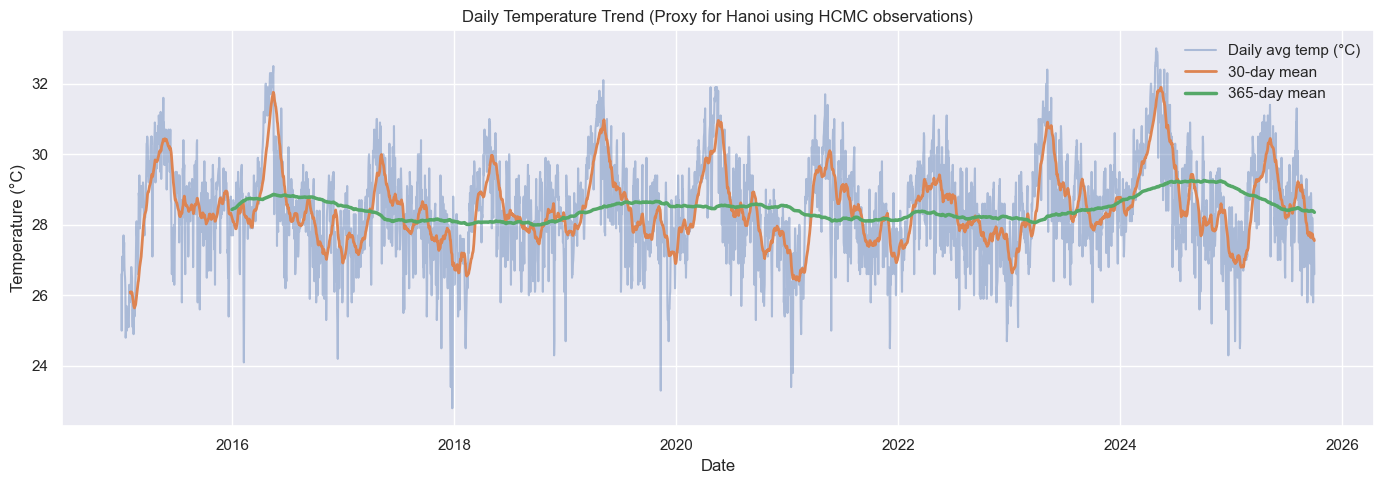

In [4]:
df_time = df_raw.copy()
df_time['datetime'] = pd.to_datetime(df_time['datetime'])
df_time = df_time.sort_values('datetime')
df_time['temp_ma30'] = df_time['temp'].rolling(30).mean()
df_time['temp_ma365'] = df_time['temp'].rolling(365).mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_time['datetime'], df_time['temp'], label='Daily avg temp (°C)', alpha=0.4)
ax.plot(df_time['datetime'], df_time['temp_ma30'], label='30-day mean', linewidth=2)
ax.plot(df_time['datetime'], df_time['temp_ma365'], label='365-day mean', linewidth=2.5)
ax.set_title('Daily Temperature Trend (Proxy for Hanoi using HCMC observations)')
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()

### Temperature behaviour (2015–2025)

- Daily average temperature stays between roughly 24–30?°C with minor inter-annual variation.
- Wet-season months (May–October) drive the recurring dips seen in the rolling averages.
- No strong long-term warming or cooling trend is evident, although variability increases during monsoon periods.

Correlation_with_temp
temp                         1.000000
feelslike                    0.893183
tempmax                      0.847479
tempmin                      0.792170
feelslikemin                 0.770885
temp_ma30                    0.658027
feelslikemax                 0.633797
solarradiation               0.579843
solarenergy                  0.578870
uvindex                      0.471194
visibility                   0.420761
windspeedmean                0.280446
windspeedmin                 0.269430
dew                          0.260570
temp_ma365                   0.152633

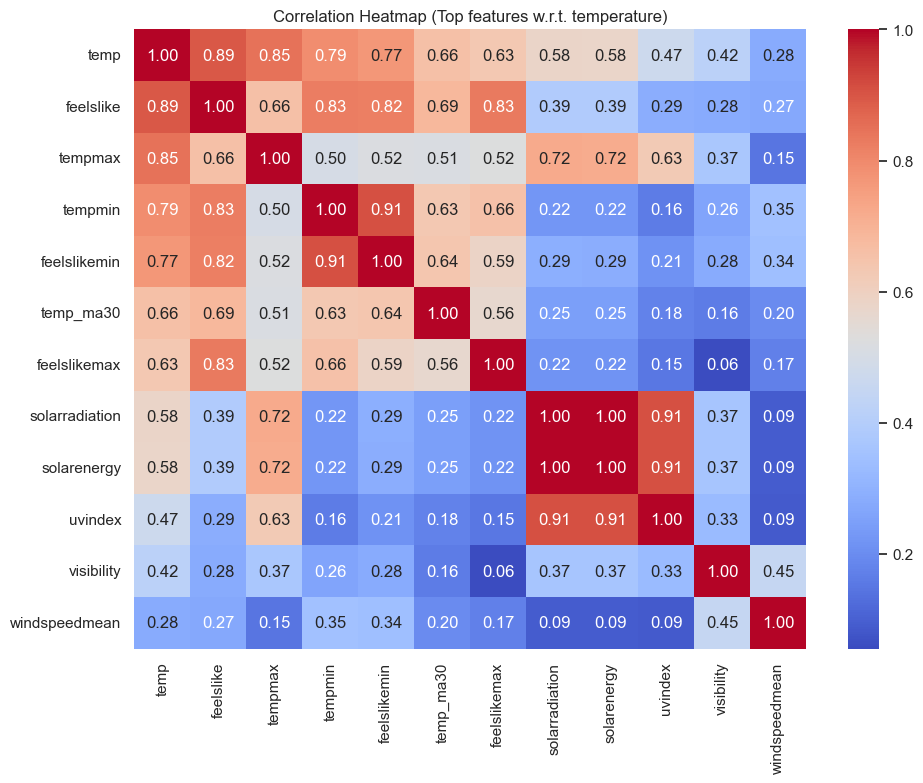

In [5]:
numeric_cols = df_time.select_dtypes(include=np.number).columns.tolist()
corr_matrix = df_time[numeric_cols].corr()
corr_target = corr_matrix['temp'].sort_values(ascending=False)
top_features = corr_target.index[:12].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap (Top features w.r.t. temperature)')
plt.tight_layout()

corr_target_df = corr_target.to_frame(name='Correlation_with_temp')
display(corr_target_df.head(15))

## <span style='color:blue'> Step 3 · Data Processing

In [6]:
missing_summary = df_raw.isna().sum().sort_values(ascending=False)
missing_focus = missing_summary[missing_summary > 0]
print('Missing values focus:')
display(missing_focus.to_frame('count'))

feature_types = {
    'numeric': df_raw.select_dtypes(include=[np.number]).columns.tolist(),
    'categorical_or_text': df_raw.select_dtypes(include=['object']).columns.tolist()
}
print(f"Numeric features: {len(feature_types['numeric'])}")
print(f"Categorical/text features: {len(feature_types['categorical_or_text'])}")
print('Examples (numeric):', feature_types['numeric'][:10])
print('Examples (categorical/text):', feature_types['categorical_or_text'][:10])

Missing values focus:


count
severerisk   2731
preciptype    924

Numeric features: 27
Categorical/text features: 11
Examples (numeric): ['latitude', 'longitude', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity']
Examples (categorical/text): ['name', 'address', 'resolvedAddress', 'datetime', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon']


## <span style='color:blue'> Step 4 · Feature Engineering

Goal: transform the daily weather log into a supervised dataset that predicts the next five days of average temperature (	emp). We generate calendar features, lags, rolling statistics, and textual embeddings so that any ML model (linear ? deep) can ingest the data.

In [7]:
HORIZONS = [1, 2, 3, 4, 5]
LAG_VALUES = [1, 2, 3, 7, 14]
ROLLING_WINDOWS = [3, 7, 14]
SEQUENCE_LENGTH = 30


def prepare_supervised_dataset(df,
                               horizons=HORIZONS,
                               lag_values=LAG_VALUES,
                               rolling_windows=ROLLING_WINDOWS,
                               sequence_length=SEQUENCE_LENGTH):
    # Create supervised learning tables and sequence data for multi-step forecasting.
    df_work = df.copy()
    df_work['datetime'] = pd.to_datetime(df_work['datetime'])
    df_work = df_work.sort_values('datetime').reset_index(drop=True)
    df_work['row_id'] = df_work.index

    text_columns = ['description', 'conditions', 'icon']
    for col in text_columns:
        df_work[col] = df_work[col].fillna('').astype(str)
    df_work['preciptype'] = df_work['preciptype'].fillna('none')
    df_work['severerisk'] = df_work['severerisk'].fillna(0.0)

    df_work['sunrise'] = pd.to_datetime(df_work['sunrise'])
    df_work['sunset'] = pd.to_datetime(df_work['sunset'])

    df_work['sunrise_minutes'] = df_work['sunrise'].dt.hour * 60 + df_work['sunrise'].dt.minute
    df_work['sunset_minutes'] = df_work['sunset'].dt.hour * 60 + df_work['sunset'].dt.minute
    df_work['day_length_minutes'] = (df_work['sunset'] - df_work['sunrise']).dt.total_seconds() / 60

    df_work['day_of_year'] = df_work['datetime'].dt.dayofyear
    df_work['month'] = df_work['datetime'].dt.month
    df_work['year'] = df_work['datetime'].dt.year
    df_work['day_of_week'] = df_work['datetime'].dt.dayofweek
    df_work['sin_day_of_year'] = np.sin(2 * np.pi * df_work['day_of_year'] / 366)
    df_work['cos_day_of_year'] = np.cos(2 * np.pi * df_work['day_of_year'] / 366)
    df_work['sin_month'] = np.sin(2 * np.pi * df_work['month'] / 12)
    df_work['cos_month'] = np.cos(2 * np.pi * df_work['month'] / 12)

    df_work['temp_diff_1'] = df_work['temp'].diff(1)
    df_work['temp_diff_7'] = df_work['temp'].diff(7)

    drop_constant = ['name', 'address', 'resolvedAddress', 'latitude', 'longitude', 'source']
    df_work = df_work.drop(columns=drop_constant)

    base_numeric_cols = ['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike',
                         'humidity', 'dew', 'precip', 'precipprob', 'precipcover', 'windgust',
                         'windspeed', 'windspeedmax', 'windspeedmean', 'windspeedmin', 'winddir',
                         'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
                         'uvindex', 'severerisk', 'moonphase']

    base_numeric = df_work[['row_id', 'datetime'] + base_numeric_cols].copy().set_index('row_id')

    lag_frames = []
    for lag in lag_values:
        lag_df = df_work[base_numeric_cols].shift(lag)
        lag_df.columns = [f'{col}_lag_{lag}' for col in base_numeric_cols]
        lag_frames.append(lag_df)

    roll_frames = []
    for window in rolling_windows:
        roll_df = pd.DataFrame(index=df_work.index)
        roll_df[f'temp_rollmean_{window}'] = df_work['temp'].rolling(window).mean()
        roll_df[f'temp_rollstd_{window}'] = df_work['temp'].rolling(window).std()
        roll_df[f'humidity_rollmean_{window}'] = df_work['humidity'].rolling(window).mean()
        roll_df[f'precip_rollsum_{window}'] = df_work['precip'].rolling(window).sum()
        roll_df[f'windspeed_rollmean_{window}'] = df_work['windspeed'].rolling(window).mean()
        roll_df[f'cloudcover_rollmean_{window}'] = df_work['cloudcover'].rolling(window).mean()
        roll_frames.append(roll_df)

    df_work = pd.concat([df_work] + lag_frames + roll_frames, axis=1)

    target_cols = []
    for horizon in horizons:
        col_name = f'target_temp_t+{horizon}'
        df_work[col_name] = df_work['temp'].shift(-horizon)
        target_cols.append(col_name)

    df_work = df_work.drop(columns=['sunrise', 'sunset'])

    min_history = max(max(lag_values), sequence_length)
    valid_end_index = len(df_work) - max(horizons)
    if valid_end_index <= min_history:
        raise ValueError('Not enough rows for the requested configuration.')

    df_model = df_work.iloc[min_history:valid_end_index].copy()

    seq_samples, seq_targets, seq_row_ids = [], [], []
    for row_id in df_model['row_id']:
        start_idx = row_id - sequence_length + 1
        end_idx = row_id
        future_idx = [row_id + h for h in horizons]
        if start_idx < 0 or max(future_idx) >= len(base_numeric):
            continue
        seq_block = base_numeric.loc[start_idx:end_idx, base_numeric_cols].values
        target_block = base_numeric.loc[future_idx, 'temp'].values
        if seq_block.shape[0] == sequence_length:
            seq_samples.append(seq_block)
            seq_targets.append(target_block)
            seq_row_ids.append(row_id)

    if not seq_samples:
        raise ValueError('Sequence preparation failed. No sequences generated.')

    seq_samples = np.array(seq_samples)
    seq_targets = np.array(seq_targets)

    df_model = df_model.set_index('row_id').loc[seq_row_ids].reset_index()

    target_df = df_model[['row_id'] + target_cols].copy()
    feature_df = df_model.drop(columns=target_cols).copy()

    sequence_package = {
        'row_ids': seq_row_ids,
        'X_seq': seq_samples,
        'y_seq': seq_targets,
        'feature_names': base_numeric_cols
    }

    return feature_df, target_df, target_cols, sequence_package

In [8]:
feature_df, target_df, target_cols, sequence_package = prepare_supervised_dataset(df_raw)
print(f'Engineered feature matrix shape: {feature_df.shape}')
print(f'Target matrix shape: {target_df.shape}')
print('Target horizons:', target_cols)
display(feature_df.head())
display(target_df.head())

Engineered feature matrix shape: (3892, 182)
Target matrix shape: (3892, 6)
Target horizons: ['target_temp_t+1', 'target_temp_t+2', 'target_temp_t+3', 'target_temp_t+4', 'target_temp_t+5']


row_id   datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0      30 2015-01-31     31.6     21.0  25.9          31.2          21.0   
1      31 2015-02-01     33.0     19.4  26.2          31.7          19.4   
2      32 2015-02-02     33.6     20.0  26.8          32.9          20.0   
3      33 2015-02-03     33.0     22.6  26.8          33.0          22.6   
4      34 2015-02-04     33.0     22.0  26.6          32.4          22.0   

   feelslike   dew  humidity  precip  precipprob  precipcover preciptype  \
0       25.9  16.7      58.9     0.0           0          0.0       none   
1       25.9  15.7      56.0     0.0           0          0.0       none   
2       26.8  17.2      59.1     0.0           0          0.0       none   
3       27.1  18.6      63.0     0.0           0          0.0       none   
4       26.6  17.8      60.8     0.0           0          0.0       none   

   windgust  windspeed  windspeedmax  windspeedmean  windspeedmin  winddir  \
0      28.1       16.2          16.2            7.3           2.9    151.7   
1      38.9       19.6          19.6            9.6           3.3     87.8   
2      37.1       13.0          13.0            7.1           0.7    112.8   
3      31.3       18.4          18.4            8.7           2.1    137.6   
4      32.4       18.4          18.4            7.9           1.5    107.4   

   sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
0            1013.9        36.8         9.7           268.1         23.2   
1            1013.7        26.4         9.8           258.3         22.3   
2            1014.1        32.2         9.4           264.9         22.8   
3            1014.9        40.4         9.2           241.2         20.8   
4            1014.2        51.5        10.5           254.6         21.9   

   uvindex  severerisk  moonphase        conditions  \
0        9         0.0       0.37  Partially cloudy   
1        9         0.0       0.40  Partially cloudy   
2        9         0.0       0.44  Partially cloudy   
3        9         0.0       0.47  Partially cloudy   
4        9         0.0       0.50  Partially cloudy   

                         description               icon  sunrise_minutes  \
0         Clearing in the afternoon.  partly-cloudy-day              376   
1  Partly cloudy throughout the day.  partly-cloudy-day              376   
2  Partly cloudy throughout the day.  partly-cloudy-day              376   
3  Partly cloudy throughout the day.  partly-cloudy-day              376   
4  Partly cloudy throughout the day.  partly-cloudy-day              376   

   sunset_minutes  day_length_minutes  day_of_year  month  year  day_of_week  \
0            1076          699.650000           31      1  2015            5   
1            1076          700.100000           32      2  2015            6   
2            1077          700.566667           33      2  2015            0   
3            1077          701.050000           34      2  2015            1   
4            1077          701.533333           35      2  2015            2   

   sin_day_of_year  cos_day_of_year  sin_month  cos_month  temp_diff_1  \
0         0.507415         0.861702   0.500000   0.866025         -0.1   
1         0.522133         0.852864   0.866025   0.500000          0.3   
2         0.536696         0.843776   0.866025   0.500000          0.6   
3         0.551102         0.834438   0.866025   0.500000          0.0   
4         0.565345         0.824855   0.866025   0.500000         -0.2   

   temp_diff_7  temp_lag_1  tempmax_lag_1  tempmin_lag_1  feelslikemax_lag_1  \
0          0.8        26.0           33.0           22.0                34.3   
1          1.1        25.9           31.6           21.0                31.2   
2          1.3        26.2           33.0           19.4                31.7   
3          0.5        26.8           33.6           20.0                32.9   
4          0.8        26.8           33.0        

row_id  target_temp_t+1  target_temp_t+2  target_temp_t+3  target_temp_t+4  \
0      30             26.2             26.8             26.8             26.6   
1      31             26.8             26.8             26.6             26.5   
2      32             26.8             26.6             26.5             25.4   
3      33             26.6             26.5             25.4             25.1   
4      34             26.5             25.4             25.1             25.6   

   target_temp_t+5  
0             26.5  
1             25.4  
2             25.1  
3             25.6  
4             25.4

## <span style='color:blue'>Step 5 · Modelling & Hyper-Parameter Tuning

We follow the requested line-up: naive & statistical baselines, linear and robust regressors, tree/gradient ensembles, Optuna tuning, a seq2seq LSTM, and a simple hybrid ensemble.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from tqdm.auto import tqdm
import optuna

split_idx = int(len(feature_df) * 0.85)

dates = feature_df['datetime'].reset_index(drop=True)
X = feature_df.drop(columns=['datetime'])
y = target_df[target_cols]

split_idx = int(len(feature_df) * 0.85)
LEAKAGE_BUFFER = 14  # Maximum lag/rolling window size

dates = feature_df['datetime'].reset_index(drop=True)
X = feature_df.drop(columns=['datetime'])
y = target_df[target_cols]

X_train = X.iloc[:split_idx].reset_index(drop=True)
# Remove first LEAKAGE_BUFFER rows from test set
X_test = X.iloc[split_idx + LEAKAGE_BUFFER:].reset_index(drop=True)
y_train = y.iloc[:split_idx].reset_index(drop=True)
y_test = y.iloc[split_idx + LEAKAGE_BUFFER:].reset_index(drop=True)
train_dates = dates.iloc[:split_idx].reset_index(drop=True)
test_dates = dates.iloc[split_idx + LEAKAGE_BUFFER:].reset_index(drop=True)


text_cols = ['description']
categorical_cols = ['preciptype', 'conditions', 'icon']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols + text_cols]

class ModTimeSeriesSplit:
    """Time series split that removes leakage buffer from validation sets."""
    def __init__(self, n_splits=5, buffer=14):
        self.n_splits = n_splits
        self.buffer = buffer
        self.tscv = TimeSeriesSplit(n_splits=n_splits)
    
    def split(self, X, y=None, groups=None):
        for train_idx, val_idx in self.tscv.split(X):
            # Remove first 'buffer' samples from validation set
            val_idx_clean = val_idx[self.buffer:]
            if len(val_idx_clean) > 0:
                yield train_idx, val_idx_clean
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

tscv = ModTimeSeriesSplit(n_splits=5, buffer=LEAKAGE_BUFFER)


print(f'Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')
print(f'Numeric features: {len(numeric_cols)}, categorical: {len(categorical_cols)}, text: {text_cols}')


def build_preprocessor():
    transformers = []
    if numeric_cols:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', numeric_transformer, numeric_cols))
    if categorical_cols:
        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        transformers.append(('cat', categorical_transformer, categorical_cols))
    if text_cols:
        text_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('flatten', FunctionTransformer(lambda x: x.ravel(), accept_sparse=False)),
            ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1, 2)))
        ])
        # FIX: Pass [text_cols[0]] instead of text_cols[0]
        transformers.append(('text', text_transformer, [text_cols[0]]))
    return ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0.0)

def to_dense(x):
    return x.toarray() if hasattr(x, 'toarray') else x


def make_pipeline(estimator):
    return Pipeline([
        ('preprocess', build_preprocessor()),
        ('dense', FunctionTransformer(to_dense, accept_sparse=True)),
        ('regressor', estimator)
    ])


def compute_metrics(y_true, y_pred, horizons=HORIZONS):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    metrics = {}
    rmse_vals, mae_vals, mape_vals, r2_vals = [], [], [], []
    for idx, horizon in enumerate(horizons):
        actual = y_true[:, idx]
        pred = y_pred[:, idx]
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        mask = np.abs(actual) > 1e-6
        mape = np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100 if mask.any() else np.nan
        r2 = r2_score(actual, pred)
        metrics[f'RMSE_h{horizon}'] = rmse
        metrics[f'MAE_h{horizon}'] = mae
        metrics[f'MAPE_h{horizon}'] = mape
        metrics[f'R2_h{horizon}'] = r2
        rmse_vals.append(rmse)
        mae_vals.append(mae)
        if not np.isnan(mape):
            mape_vals.append(mape)
        r2_vals.append(r2)
    metrics['RMSE_macro'] = float(np.mean(rmse_vals))
    metrics['MAE_macro'] = float(np.mean(mae_vals))
    metrics['MAPE_macro'] = float(np.mean(mape_vals)) if mape_vals else np.nan
    metrics['R2_macro'] = float(np.mean(r2_vals))
    return metrics


def cross_val_evaluate(pipeline, X_data, y_data, cv):
    fold_metrics = []
    for train_idx, val_idx in cv.split(X_data):
        X_tr, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_tr, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        model = clone(pipeline)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        fold_metrics.append(compute_metrics(y_val.values, preds, HORIZONS))
    return fold_metrics


def aggregate_metrics(fold_metrics):
    if not fold_metrics:
        return None
    keys = fold_metrics[0].keys()
    return {k: float(np.nanmean([fold[k] for fold in fold_metrics])) for k in keys}


model_results = {}

Train samples: 3308, Test samples: 570
Numeric features: 177, categorical: 3, text: ['description']


### <span style='color:brown'> Define analysis function

In [10]:
#======================== MODEL ANALYSIS FRAMEWORK ========================

def analyze_model_comprehensive(model_name, model_results, X_train, X_test, y_train, y_test,
                                test_dates, horizons=HORIZONS):
    """
    Comprehensive model analysis following the 6-part framework.

    Parameters:
    -----------
    model_name : str
        Name of the model to analyze
    model_results : dict
        Dictionary containing all model results
    X_train, X_test : DataFrame
        Training and test features
    y_train, y_test : DataFrame
        Training and test targets
    test_dates : Series
        Dates corresponding to test set
    horizons : list
        Forecast horizons
    """

    if model_name not in model_results:
        print(f"Model '{model_name}' not found in results.")
        return

    result = model_results[model_name]

    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE ANALYSIS: {model_name}")
    print(f"{'='*80}\n")

    # Section 2: Model Specification
    print("## 2. MODEL SPECIFICATION")
    print("=" * 60)
    print_model_specification(model_name, result)

    # Section 3: Quantitative Performance
    print("\n## 3. QUANTITATIVE PERFORMANCE")
    print("=" * 60)
    analyze_quantitative_performance(model_name, result, horizons)

    # Section 4: Error Analysis
    print("\n## 4. ERROR ANALYSIS")
    print("=" * 60)
    perform_error_analysis(model_name, result, y_test, test_dates, horizons)

    # Section 5: Bias-Variance Decomposition
    print("\n## 5. BIAS-VARIANCE DECOMPOSITION")
    print("=" * 60)
    perform_bias_variance_decomposition(model_name, result, y_train, y_test, horizons)


def print_model_specification(model_name, result):
    """Print model technical configuration."""
    print(f"Model: {model_name}")
    print(f"Details: {result.get('details', 'N/A')}")

    # Extract hyperparameters if available
    if 'pipeline' in result:
        pipeline = result['pipeline']
        try:
            estimator = pipeline.named_steps['regressor']
            if hasattr(estimator, 'estimators_'):
                base_estimator = estimator.estimators_[0]
                print(f"\nHyperparameters:")
                for param, value in base_estimator.get_params().items():
                    if not param.startswith('_'):
                        print(f"  - {param}: {value}")
        except:
            pass


def compare_optuna_performance(base_model_name, optuna_model_name, model_results, horizons=HORIZONS):
    """
    Compare performance with and without Optuna tuning.
    """
    print("\n" + "="*80)
    print("OPTUNA HYPERPARAMETER TUNING COMPARISON")
    print("="*80)

    if base_model_name not in model_results or optuna_model_name not in model_results:
        print("Required models not found for comparison.")
        return

    base_metrics = model_results[base_model_name]['test_metrics']
    optuna_metrics = model_results[optuna_model_name]['test_metrics']

    comparison_df = pd.DataFrame({
        'Metric': ['RMSE_macro', 'MAE_macro', 'MAPE_macro', 'R2_macro'],
        'Base Model': [base_metrics['RMSE_macro'], base_metrics['MAE_macro'],
                       base_metrics['MAPE_macro'], base_metrics['R2_macro']],
        'Optuna Tuned': [optuna_metrics['RMSE_macro'], optuna_metrics['MAE_macro'],
                         optuna_metrics['MAPE_macro'], optuna_metrics['R2_macro']]
    })

    comparison_df['Improvement (%)'] = ((comparison_df['Base Model'] - comparison_df['Optuna Tuned'])
                                        / comparison_df['Base Model'] * 100)

    display(comparison_df)

    # Per-horizon comparison
    horizon_comparison = []
    for h in horizons:
        horizon_comparison.append({
            'Horizon': f't+{h}',
            'Base RMSE': base_metrics[f'RMSE_h{h}'],
            'Optuna RMSE': optuna_metrics[f'RMSE_h{h}'],
            'Improvement (%)': ((base_metrics[f'RMSE_h{h}'] - optuna_metrics[f'RMSE_h{h}'])
                                / base_metrics[f'RMSE_h{h}'] * 100)
        })

    horizon_df = pd.DataFrame(horizon_comparison)
    print("\nPer-Horizon RMSE Comparison:")
    display(horizon_df)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Macro metrics comparison
    metrics_to_plot = ['RMSE_macro', 'MAE_macro', 'R2_macro']
    x = np.arange(len(metrics_to_plot))
    width = 0.35

    base_vals = [base_metrics[m] for m in metrics_to_plot]
    optuna_vals = [optuna_metrics[m] for m in metrics_to_plot]

    axes[0].bar(x - width/2, base_vals, width, label='Base Model', alpha=0.8)
    axes[0].bar(x + width/2, optuna_vals, width, label='Optuna Tuned', alpha=0.8)
    axes[0].set_xlabel('Metrics')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Macro Metrics Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_to_plot)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Per-horizon RMSE
    axes[1].plot(horizons, [base_metrics[f'RMSE_h{h}'] for h in horizons],
                 marker='o', label='Base Model', linewidth=2)
    axes[1].plot(horizons, [optuna_metrics[f'RMSE_h{h}'] for h in horizons],
                 marker='s', label='Optuna Tuned', linewidth=2)
    axes[1].set_xlabel('Forecast Horizon (days)')
    axes[1].set_ylabel('RMSE (°C)')
    axes[1].set_title('RMSE by Forecast Horizon')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Decision recommendation
    avg_improvement = comparison_df['Improvement (%)'].mean()
    print(f"\n{'='*80}")
    print("RECOMMENDATION:")
    if avg_improvement > 2:
        print(f"✓ Use Optuna tuning (Average improvement: {avg_improvement:.2f}%)")
    elif avg_improvement > 0:
        print(f"~ Consider Optuna tuning (Marginal improvement: {avg_improvement:.2f}%)")
    else:
        print(f"✗ Base model sufficient (No significant improvement: {avg_improvement:.2f}%)")
    print(f"{'='*80}\n")


def analyze_quantitative_performance(model_name, result, horizons):
    """Analyze quantitative performance metrics."""

    # 3a. Performance Metrics
    print("\n### 3a. Performance Metrics")
    print("-" * 60)

    test_metrics = result['test_metrics']
    train_metrics = result.get('train_metrics', {})
    cv_metrics = result.get('cv_metrics', {})


    print("\nMacro Metrics (averaged across all horizons):")
    for metric in ['RMSE_macro', 'MAE_macro', 'MAPE_macro', 'R2_macro']:
        metric_base = metric.replace('_macro', '')
        print(f"\n{metric_base}:")
        print(f"  Value: {test_metrics[metric]:.4f}")

    # Per-horizon metrics
    print("\n\nPer-Horizon Metrics:")
    horizon_metrics_df = pd.DataFrame([
        {
            'Horizon': f't+{h}',
            'RMSE': test_metrics[f'RMSE_h{h}'],
            'MAE': test_metrics[f'MAE_h{h}'],
            'MAPE': test_metrics[f'MAPE_h{h}'],
            'R²': test_metrics[f'R2_h{h}']
        }
        for h in horizons
    ])
    display(horizon_metrics_df)

    # 3b. Train-Test Comparison
    print("\n### 3b. Train-Test Comparison")
    print("-" * 60)

    if train_metrics:
        comparison_df = pd.DataFrame({
            'Metric': ['RMSE_macro', 'MAE_macro', 'R2_macro'],
            'Train': [train_metrics.get('RMSE_macro', np.nan),
                     train_metrics.get('MAE_macro', np.nan),
                     train_metrics.get('R2_macro', np.nan)],
            'Test': [test_metrics['RMSE_macro'],
                    test_metrics['MAE_macro'],
                    test_metrics['R2_macro']]
        })
        comparison_df['Difference'] = comparison_df['Test'] - comparison_df['Train']
        comparison_df['Overfitting?'] = comparison_df['Difference'].apply(
            lambda x: 'Yes' if abs(x) > 0.5 else 'No'
        )
        display(comparison_df)

        # Interpretation
        rmse_diff = test_metrics['RMSE_macro'] - train_metrics.get('RMSE_macro', 0)
        if rmse_diff > 0.5:
            print("\n⚠ Potential overfitting detected (large train-test gap)")
        elif rmse_diff < -0.2:
            print("\n⚠ Unusual behavior (test performs better than train)")
        else:
            print("\n✓ Good generalization (similar train-test performance)")
    else:
        print("Train metrics not available.")

    # 3c. Cross-Validation Metrics
    print("\n### 3c. Cross-Validation Performance")
    print("-" * 60)

    if cv_metrics:
        print(f"CV RMSE (mean): {cv_metrics['RMSE_macro']:.4f}")
        print(f"CV MAE (mean): {cv_metrics['MAE_macro']:.4f}")
        print(f"CV R² (mean): {cv_metrics['R2_macro']:.4f}")
        print("\n[Note: Standard deviation would require storing individual fold results]")
    else:
        print("Cross-validation metrics not available.")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Per-horizon performance
    axes[0].plot(horizons, [test_metrics[f'RMSE_h{h}'] for h in horizons],
                marker='o', linewidth=2, markersize=8)
    axes[0].set_xlabel('Forecast Horizon (days)', fontsize=11)
    axes[0].set_ylabel('RMSE (°C)', fontsize=11)
    axes[0].set_title(f'{model_name}: RMSE by Horizon', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Train vs Test comparison (if available)
    if train_metrics:
        metrics_names = ['RMSE', 'MAE', 'R²']
        train_vals = [train_metrics.get('RMSE_macro', 0),
                     train_metrics.get('MAE_macro', 0),
                     train_metrics.get('R2_macro', 0)]
        test_vals = [test_metrics['RMSE_macro'],
                    test_metrics['MAE_macro'],
                    test_metrics['R2_macro']]

        x = np.arange(len(metrics_names))
        width = 0.35

        axes[1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
        axes[1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
        axes[1].set_xlabel('Metrics', fontsize=11)
        axes[1].set_ylabel('Value', fontsize=11)
        axes[1].set_title('Train vs Test Performance', fontsize=12, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(metrics_names)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


def perform_error_analysis(model_name, result, y_test, test_dates, horizons):
    """Perform comprehensive error analysis."""

    predictions = result['predictions_test']

    # 4a. Residual Plot (Time Series)
    print("\n### 4a. Residual Analysis Over Time")
    print("-" * 60)

    residuals = y_test.values - predictions

    # Calculate seasonal statistics
    test_dates_series = pd.to_datetime(test_dates)
    months = test_dates_series.dt.month

    seasonal_errors = pd.DataFrame({
        'Month': months,
        'Residual_h1': residuals[:, 0]
    })
    monthly_stats = seasonal_errors.groupby('Month')['Residual_h1'].agg(['mean', 'std', 'count'])

    print("\nMonthly Residual Statistics (Horizon t+1):")
    display(monthly_stats)

    # Identify problematic periods
    abs_residuals = np.abs(residuals)
    error_threshold = np.percentile(abs_residuals[:, 0], 90)
    high_error_periods = test_dates_series[abs_residuals[:, 0] > error_threshold]

    print(f"\nHigh Error Periods (top 10% errors > {error_threshold:.2f}°C):")
    print(f"Total occurrences: {len(high_error_periods)}")
    if len(high_error_periods) > 0:
        print(f"Date range: {high_error_periods.min()} to {high_error_periods.max()}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Time series residual plot (horizon 1)
    axes[0, 0].scatter(test_dates, residuals[:, 0], alpha=0.5, s=20)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Date', fontsize=10)
    axes[0, 0].set_ylabel('Residual (°C)', fontsize=10)
    axes[0, 0].set_title(f'{model_name}: Residuals Over Time (t+1)', fontsize=11, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Residuals by month (boxplot)
    monthly_residuals = [residuals[months == m, 0] for m in range(1, 13)]
    axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))
    axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Month', fontsize=10)
    axes[0, 1].set_ylabel('Residual (°C)', fontsize=10)
    axes[0, 1].set_title('Seasonal Error Pattern (t+1)', fontsize=11, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Residual by horizon
    for i, h in enumerate(horizons):
        axes[1, 0].scatter([h] * len(residuals), residuals[:, i], alpha=0.3, s=10, label=f't+{h}')
    axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Forecast Horizon', fontsize=10)
    axes[1, 0].set_ylabel('Residual (°C)', fontsize=10)
    axes[1, 0].set_title('Residuals by Forecast Horizon', fontsize=11, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Absolute error by horizon
    mean_abs_errors = [np.mean(np.abs(residuals[:, i])) for i in range(len(horizons))]
    axes[1, 1].bar(horizons, mean_abs_errors, alpha=0.7, color='coral')
    axes[1, 1].set_xlabel('Forecast Horizon (days)', fontsize=10)
    axes[1, 1].set_ylabel('Mean Absolute Error (°C)', fontsize=10)
    axes[1, 1].set_title('Average Error by Horizon', fontsize=11, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # 4b. Distribution of Residuals
    print("\n### 4b. Residual Distribution Analysis")
    print("-" * 60)

    fig, axes = plt.subplots(1, len(horizons), figsize=(4*len(horizons), 4))
    if len(horizons) == 1:
        axes = [axes]

    for i, h in enumerate(horizons):
        res_h = residuals[:, i]

        # Statistics
        mean_res = np.mean(res_h)
        std_res = np.std(res_h)
        skewness = pd.Series(res_h).skew()
        kurtosis = pd.Series(res_h).kurtosis()

        # Histogram with normal curve
        axes[i].hist(res_h, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

        # Overlay normal distribution
        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = np.exp(-0.5 * ((x - mean_res) / std_res) ** 2) / (std_res * np.sqrt(2 * np.pi))
        axes[i].plot(x, p, 'r-', linewidth=2, label='Normal')

        axes[i].axvline(mean_res, color='green', linestyle='--', linewidth=2, label=f'Mean={mean_res:.3f}')
        axes[i].set_xlabel('Residual (°C)', fontsize=10)
        axes[i].set_ylabel('Density', fontsize=10)
        axes[i].set_title(f'Horizon t+{h}\nSkew={skewness:.2f}, Kurt={kurtosis:.2f}',
                         fontsize=10, fontweight='bold')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

        print(f"\nHorizon t+{h}:")
        print(f"  Mean: {mean_res:.4f}°C")
        print(f"  Std Dev: {std_res:.4f}°C")
        print(f"  Skewness: {skewness:.4f} {'(right-skewed)' if skewness > 0 else '(left-skewed)'}")
        print(f"  Kurtosis: {kurtosis:.4f} {'(heavy-tailed)' if kurtosis > 0 else '(light-tailed)'}")

        # Bias assessment
        if abs(mean_res) < 0.1:
            print(f"  ✓ Low bias (|mean| < 0.1°C)")
        elif abs(mean_res) < 0.5:
            print(f"  ~ Moderate bias")
        else:
            print(f"  ✗ High bias (|mean| > 0.5°C)")

    plt.tight_layout()
    plt.show()


def perform_bias_variance_decomposition(model_name, result, y_train, y_test, horizons):
    """Perform bias-variance decomposition analysis."""

    print("\n### Bias-Variance Decomposition")
    print("-" * 60)

    predictions_test = result['predictions_test']
    predictions_train = result.get('predictions_train', None)

    decomposition_results = []

    for i, h in enumerate(horizons):
        y_true = y_test.values[:, i]
        y_pred = predictions_test[:, i]

        # Overall MSE
        mse = np.mean((y_true - y_pred) ** 2)

        # Bias² (squared difference between mean prediction and mean truth)
        bias_squared = (np.mean(y_pred) - np.mean(y_true)) ** 2

        # Variance (variance of predictions)
        variance = np.var(y_pred)

        # Irreducible error (variance of true values)
        irreducible_error = np.var(y_true)

        decomposition_results.append({
            'Horizon': f't+{h}',
            'Total MSE': mse,
            'Bias²': bias_squared,
            'Variance': variance,
            'Irreducible Error': irreducible_error,
            'Bias² %': (bias_squared / mse * 100) if mse > 0 else 0,
            'Variance %': (variance / mse * 100) if mse > 0 else 0
        })

    decomp_df = pd.DataFrame(decomposition_results)
    display(decomp_df)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Stacked bar chart
    bias_vals = decomp_df['Bias²'].values
    var_vals = decomp_df['Variance'].values

    axes[0].bar(decomp_df['Horizon'], bias_vals, label='Bias²', alpha=0.8)
    axes[0].bar(decomp_df['Horizon'], var_vals, bottom=bias_vals, label='Variance', alpha=0.8)
    axes[0].set_xlabel('Forecast Horizon', fontsize=11)
    axes[0].set_ylabel('Error Component', fontsize=11)
    axes[0].set_title('Bias-Variance Decomposition', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Percentage contribution
    axes[1].bar(decomp_df['Horizon'], decomp_df['Bias² %'], label='Bias² %', alpha=0.8)
    axes[1].bar(decomp_df['Horizon'], decomp_df['Variance %'],
               bottom=decomp_df['Bias² %'], label='Variance %', alpha=0.8)
    axes[1].set_xlabel('Forecast Horizon', fontsize=11)
    axes[1].set_ylabel('Percentage Contribution (%)', fontsize=11)
    axes[1].set_title('Relative Error Contribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Interpretation
    print("\n### Interpretation:")
    avg_bias_pct = decomp_df['Bias² %'].mean()
    avg_var_pct = decomp_df['Variance %'].mean()

    if avg_bias_pct > 60:
        print("⚠ High bias detected - model is underfitting")
        print("  Recommendation: Increase model complexity or add more features")
    elif avg_var_pct > 60:
        print("⚠ High variance detected - model is overfitting")
        print("  Recommendation: Regularization, reduce complexity, or gather more data")
    else:
        print("✓ Balanced bias-variance trade-off")
        print(f"  Bias contribution: {avg_bias_pct:.1f}%")
        print(f"  Variance contribution: {avg_var_pct:.1f}%")

## **<span style='color:brown'> Modelling**

> **Note:** You can use the model analysis function above, use 'analyze_model_comprehensive' to use print all the analysis at one (except optuna). But you should use function below the 'analyze_model_comprehensive' to print the result one by one for better visualization. You can use other fuction or plot that you define yourself, just make sure it look nice!

> **Here is one example how to use it** analyze_model_comprehensive('LinearRegression', model_results, X_train, X_test, y_train, y_test, test_dates, HORIZONS)

### **1. Naive Baseline**

In [11]:
def persistence_baseline(temp_series):
    return np.repeat(temp_series.reshape(-1, 1), len(HORIZONS), axis=1)

naive_train_preds = persistence_baseline(X_train['temp'].values)
naive_test_preds = persistence_baseline(X_test['temp'].values)
model_results['NaivePersistence'] = {
    'train_metrics': compute_metrics(y_train.values, naive_train_preds),
    'test_metrics': compute_metrics(y_test.values, naive_test_preds),
    'cv_metrics': None,
    'predictions_test': naive_test_preds,
    'predictions_train': naive_train_preds,
    'details': 'Copies latest observed temperature across all future horizons.'
}
print('Naive baseline metrics:')
display(pd.Series(model_results['NaivePersistence']['test_metrics']).to_frame('NaivePersistence').T)


Naive baseline metrics:


RMSE_h1    MAE_h1   MAPE_h1     R2_h1   RMSE_h2    MAE_h2  \
NaivePersistence  0.892523  0.690526  2.426897  0.681809  1.176532  0.925789   

                   MAPE_h2     R2_h2   RMSE_h3    MAE_h3   MAPE_h3    R2_h3  \
NaivePersistence  3.254859  0.448555  1.296114  1.020877  3.579254  0.33155   

                   RMSE_h4    MAE_h4   MAPE_h4     R2_h4   RMSE_h5    MAE_h5  \
NaivePersistence  1.349386  1.070877  3.749654  0.275709  1.333121  1.072807   

                   MAPE_h5     R2_h5  RMSE_macro  MAE_macro  MAPE_macro  \
NaivePersistence  3.754028  0.294746    1.209535   0.956175    3.352939   

                  R2_macro  
NaivePersistence  0.406474

### **Train and compute metrics of 6 basic models**

In [12]:
estimators = {
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'RandomForestRegressor': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    'HistGradientBoosting': MultiOutputRegressor(HistGradientBoostingRegressor(max_iter=100, random_state=RANDOM_STATE)),
    'HuberRegressor': MultiOutputRegressor(HuberRegressor()),
    'BayesianRidge': MultiOutputRegressor(BayesianRidge()),

}
warnings.filterwarnings('ignore', category=UserWarning)
for name, estimator in tqdm(estimators.items(), desc='Training ML models'):
    pipeline = make_pipeline(estimator)
    cv_metrics = aggregate_metrics(cross_val_evaluate(pipeline, X_train, y_train, tscv))
    pipeline.fit(X_train, y_train)
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    model_results[name] = {
        'pipeline': pipeline,
        'cv_metrics': cv_metrics,
        'train_metrics': compute_metrics(y_train.values, train_pred),
        'test_metrics': compute_metrics(y_test.values, test_pred),
        'predictions_test': test_pred,
        'predictions_train': train_pred,
        'details': 'Sklearn pipeline with preprocessing.'
    }
    print(f"{name} test RMSE_macro: {model_results[name]['test_metrics']}")

Training ML models:   0%|          | 0/5 [00:00<?, ?it/s]

LinearRegression test RMSE_macro: {'RMSE_h1': 0.8171062864348783, 'MAE_h1': 0.6471220939367951, 'MAPE_h1': 2.2659256466505293, 'R2_h1': 0.7333098852529026, 'RMSE_h2': 0.9826179709699149, 'MAE_h2': 0.7863296446137688, 'MAPE_h2': 2.7572332423991703, 'R2_h2': 0.6153514030886302, 'RMSE_h3': 1.0499818465349657, 'MAE_h3': 0.8466781804150794, 'MAPE_h3': 2.969903083116248, 'R2_h3': 0.5613219688184513, 'RMSE_h4': 1.073342893727732, 'MAE_h4': 0.8516681601622335, 'MAPE_h4': 2.993160970851723, 'R2_h4': 0.5417336695264454, 'RMSE_h5': 1.0733450469832275, 'MAE_h5': 0.8652340200190426, 'MAPE_h5': 3.042122823019736, 'R2_h5': 0.5428216489815447, 'RMSE_macro': 0.9992788089301436, 'MAE_macro': 0.7994064198293838, 'MAPE_macro': 2.8056691532074813, 'R2_macro': 0.5989077151335949}
RandomForestRegressor test RMSE_macro: {'RMSE_h1': 0.8304865462539247, 'MAE_h1': 0.6581491228070179, 'MAPE_h1': 2.2910169117019716, 'R2_h1': 0.7245041777519325, 'RMSE_h2': 1.0110426587907835, 'MAE_h2': 0.8111491228070176, 'MAPE_h2'

### **2. Linear Regression**

In [13]:
estimators = {
    'BayesianRidge': MultiOutputRegressor(BayesianRidge()),

}
warnings.filterwarnings('ignore', category=UserWarning)
for name, estimator in tqdm(estimators.items(), desc='Training ML models'):
    pipeline = make_pipeline(estimator)
    cv_metrics = aggregate_metrics(cross_val_evaluate(pipeline, X_train, y_train, tscv))
    pipeline.fit(X_train, y_train)
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    model_results[name] = {
        'pipeline': pipeline,
        'cv_metrics': cv_metrics,
        'train_metrics': compute_metrics(y_train.values, train_pred),
        'test_metrics': compute_metrics(y_test.values, test_pred),
        'predictions_test': test_pred,
        'predictions_train': train_pred,
        'details': 'Sklearn pipeline with preprocessing.'
    }
    print(f"{name} test RMSE_macro: {model_results[name]['test_metrics']}")

Training ML models:   0%|          | 0/1 [00:00<?, ?it/s]

BayesianRidge test RMSE_macro: {'RMSE_h1': 0.807599188073513, 'MAE_h1': 0.6402718213646345, 'MAPE_h1': 2.2421671391617357, 'R2_h1': 0.7394797045672117, 'RMSE_h2': 0.9748076277069908, 'MAE_h2': 0.7761603041016476, 'MAPE_h2': 2.7211594465732882, 'R2_h2': 0.6214418636095771, 'RMSE_h3': 1.04008900777451, 'MAE_h3': 0.8362483395469442, 'MAPE_h3': 2.9296826590892886, 'R2_h3': 0.5695493997394062, 'RMSE_h4': 1.0568964715552103, 'MAE_h4': 0.8445795382610046, 'MAPE_h4': 2.9615223019747616, 'R2_h4': 0.5556697555873407, 'RMSE_h5': 1.0513917751871558, 'MAE_h5': 0.8493752741195663, 'MAPE_h5': 2.9812699198476666, 'R2_h5': 0.5613318588337093, 'RMSE_macro': 0.9861568140594761, 'MAE_macro': 0.7893270554787595, 'MAPE_macro': 2.767160293329348, 'R2_macro': 0.609494516467449}



COMPREHENSIVE ANALYSIS: LinearRegression

## 2. MODEL SPECIFICATION
Model: LinearRegression
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - copy_X: True
  - fit_intercept: True
  - n_jobs: None
  - positive: False
  - tol: 1e-06

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 0.9993

MAE:
  Value: 0.7994

MAPE:
  Value: 2.8057

R2:
  Value: 0.5989


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.817106  0.647122  2.265926  0.733310
1     t+2  0.982618  0.786330  2.757233  0.615351
2     t+3  1.049982  0.846678  2.969903  0.561322
3     t+4  1.073343  0.851668  2.993161  0.541734
4     t+5  1.073345  0.865234  3.042123  0.542822


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.874850  0.999279    0.124429           No
1   MAE_macro  0.688491  0.799406    0.110915           No
2    R2_macro  0.557592  0.598908    0.041316           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.2453
CV MAE (mean): 0.8832
CV R² (mean): -0.0911

[Note: Standard deviation would require storing individual fold results]


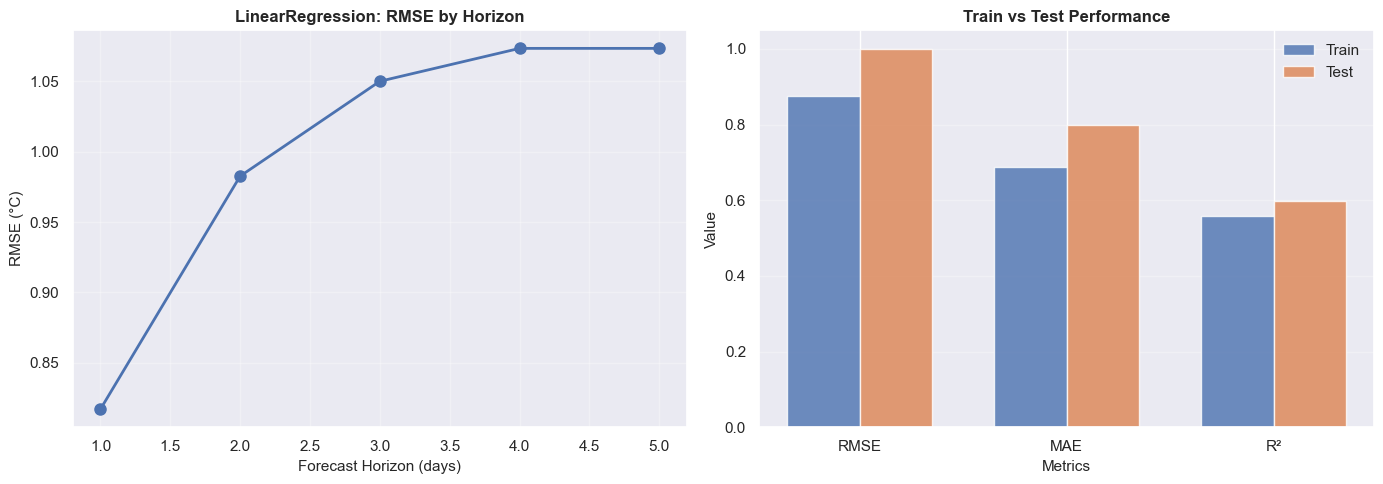


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.093741  0.812007     31
2      0.172557  0.654622     28
3      0.066575  0.595558     57
4      0.233046  0.515150     60
5      0.029034  1.006280     62
6     -0.002138  0.924572     60
7     -0.004893  0.814947     62
8      0.035670  0.848716     62
9     -0.086923  0.882130     56
10    -0.104440  0.970436     31
11     0.049417  0.657942     30
12    -0.220139  0.937185     31


High Error Periods (top 10% errors > 1.32°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


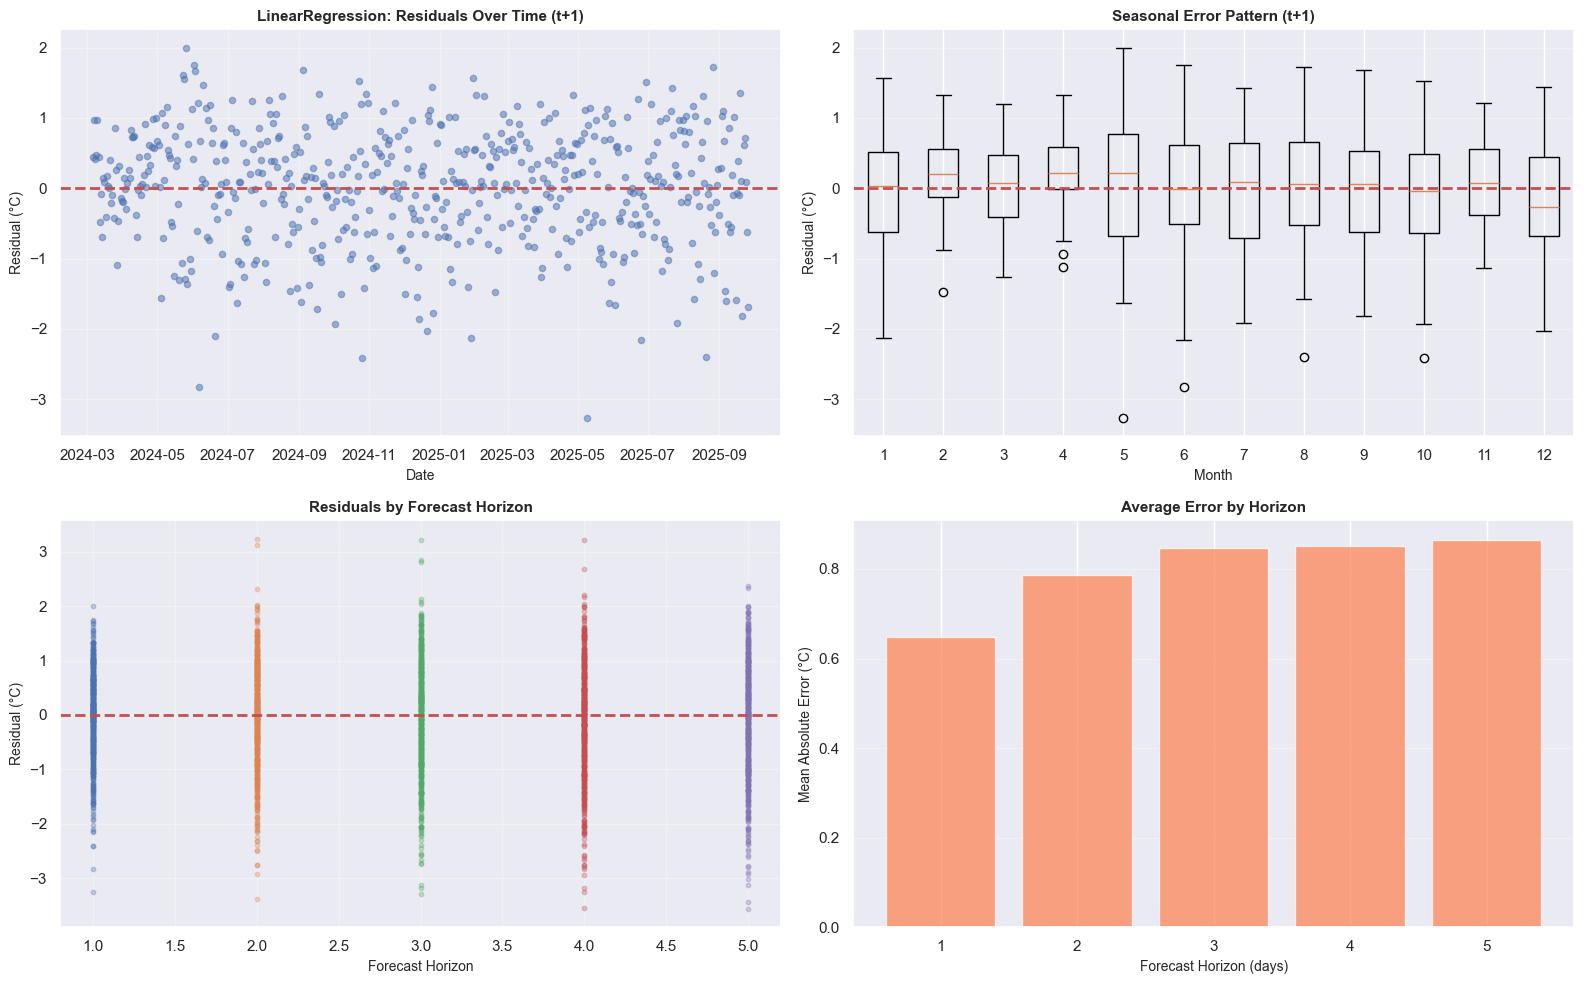


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0173°C
  Std Dev: 0.8169°C
  Skewness: -0.5058 (left-skewed)
  Kurtosis: 0.2803 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0054°C
  Std Dev: 0.9826°C
  Skewness: -0.3032 (left-skewed)
  Kurtosis: 0.1062 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0602°C
  Std Dev: 1.0483°C
  Skewness: -0.2206 (left-skewed)
  Kurtosis: -0.1065 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.1095°C
  Std Dev: 1.0677°C
  Skewness: -0.3065 (left-skewed)
  Kurtosis: -0.0592 (light-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.1220°C
  Std Dev: 1.0664°C
  Skewness: -0.3295 (left-skewed)
  Kurtosis: -0.2080 (light-tailed)
  ~ Moderate bias


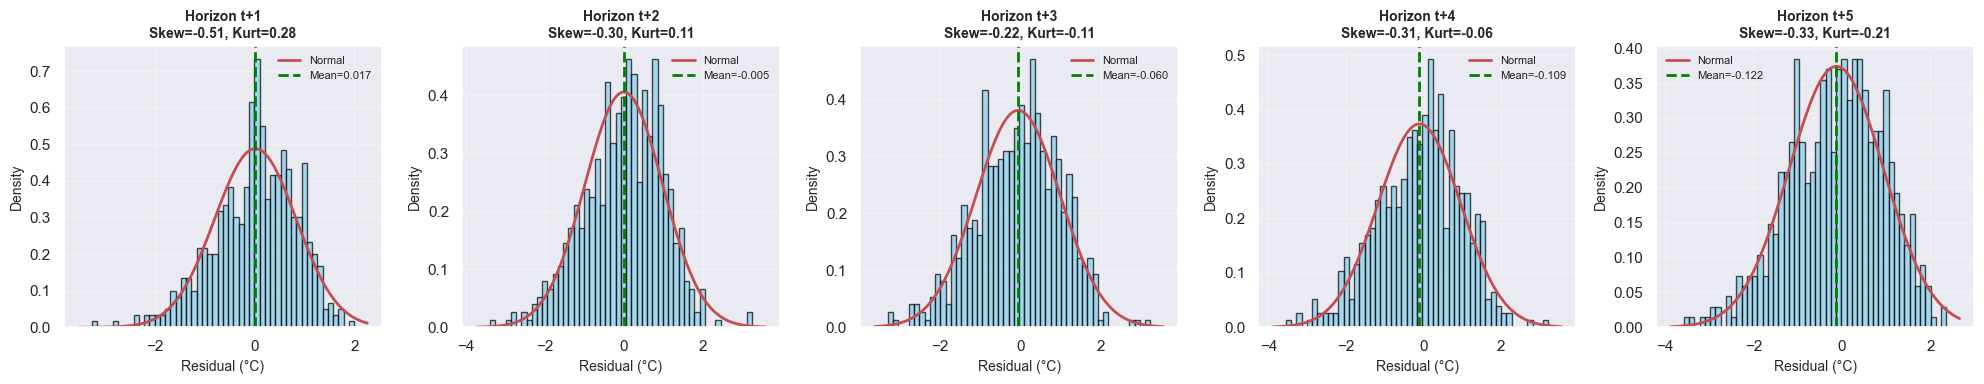


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.667663  0.000298  1.854855           2.503515  0.044600   
1     t+2   0.965538  0.000029  1.440709           2.510182  0.003022   
2     t+3   1.102462  0.003626  1.268864           2.513146  0.328925   
3     t+4   1.152065  0.011986  1.167128           2.513964  1.040360   
4     t+5   1.152070  0.014880  1.104524           2.519957  1.291558   

   Variance %  
0  277.813191  
1  149.213090  
2  115.093648  
3  101.307473  
4   95.873069

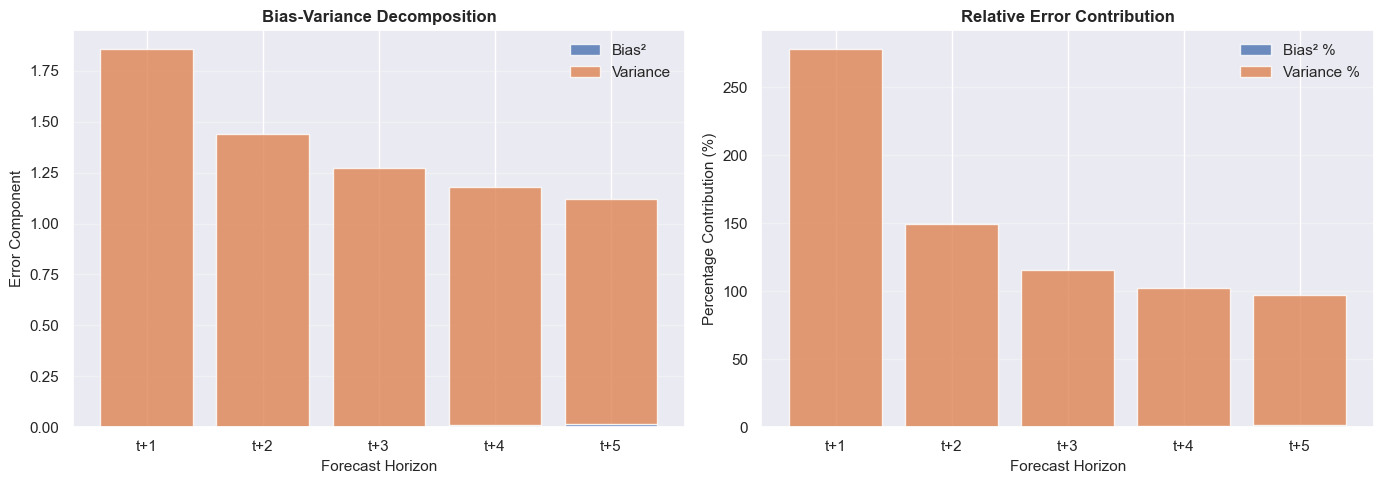


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [14]:
# Analyze Linear Regression model 
analyze_model_comprehensive('LinearRegression', model_results, X_train, X_test,
                           y_train, y_test, test_dates, HORIZONS)

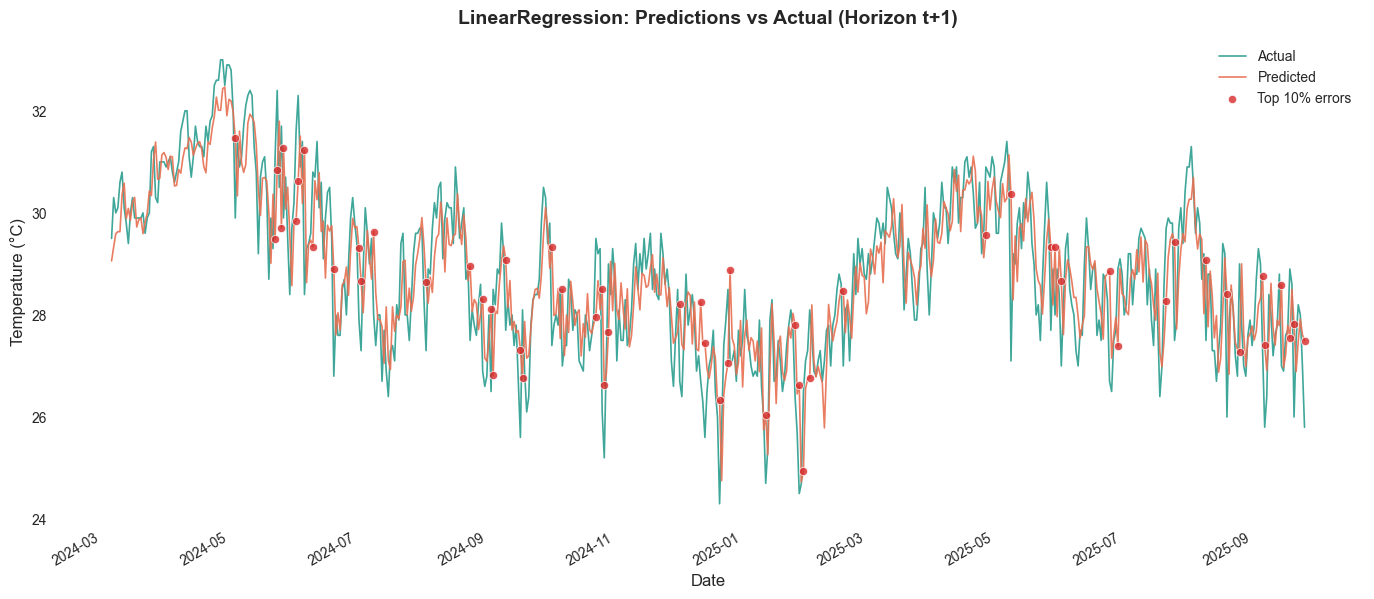

In [15]:
#======================== Visulization between Actual and Predict of Linear Regression model ========================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_name = 'LinearRegression'  
preds = model_results[model_name]['predictions_test']
residuals = y_test.values - preds

# Top 10% lỗi lớn
error_threshold = np.percentile(np.abs(residuals[:, 0]), 90)
high_error_mask = np.abs(residuals[:, 0]) > error_threshold

plt.figure(figsize=(14, 6))

# --- Actual vs Predicted (màu nhẹ, line mảnh) ---
plt.plot(
    test_dates, y_test.values[:, 0],
    color='#2a9d8f', label='Actual', linewidth=1.2, alpha=0.9
)
plt.plot(
    test_dates, preds[:, 0],
    color='#e76f51', label='Predicted', linewidth=1.2, alpha=0.9
)

# --- Scatter: Top 10% errors (nổi bật) ---
plt.scatter(
    test_dates[high_error_mask], preds[:, 0][high_error_mask],
    color='#d62828', s=35, label='Top 10% errors',
    zorder=5, alpha=0.8, edgecolors='white', linewidth=0.6
)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title(f'{model_name}: Predictions vs Actual (Horizon t+1)',
          fontsize=14, fontweight='bold', pad=10)

plt.legend(frameon=False, fontsize=10)
plt.grid(True, alpha=0.15, linestyle='--')
plt.gca().set_facecolor('white')
plt.tight_layout()


plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', length=0) 


for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)

plt.show()


### **3. Random Forest**


COMPREHENSIVE ANALYSIS: RandomForestRegressor

## 2. MODEL SPECIFICATION
Model: RandomForestRegressor
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - bootstrap: True
  - ccp_alpha: 0.0
  - criterion: squared_error
  - max_depth: None
  - max_features: 1.0
  - max_leaf_nodes: None
  - max_samples: None
  - min_impurity_decrease: 0.0
  - min_samples_leaf: 1
  - min_samples_split: 2
  - min_weight_fraction_leaf: 0.0
  - monotonic_cst: None
  - n_estimators: 100
  - n_jobs: -1
  - oob_score: False
  - random_state: 42
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0154

MAE:
  Value: 0.8133

MAPE:
  Value: 2.8308

R2:
  Value: 0.5860


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.830487  0.658149  2.291017  0.724504
1     t+2  1.011043  0.811149  2.827317  0.592776
2     t+3  1.072228  0.861061  2.995932  0.542536
3     t+4  1.085211  0.874102  3.043316  0.531543
4     t+5  1.078175  0.861793  2.996288  0.538698


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.317043  1.015429    0.698386          Yes
1   MAE_macro  0.244090  0.813251    0.569160          Yes
2    R2_macro  0.942272  0.586011   -0.356260           No


⚠ Potential overfitting detected (large train-test gap)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0131
CV MAE (mean): 0.8039
CV R² (mean): 0.3439

[Note: Standard deviation would require storing individual fold results]


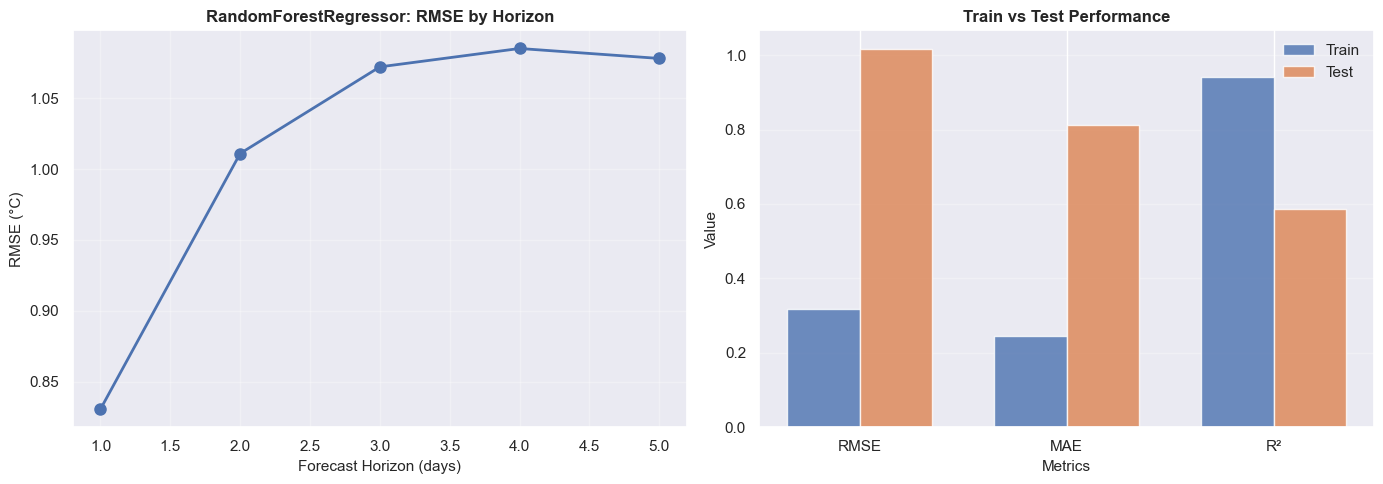


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.231968  0.759210     31
2      0.042714  0.670760     28
3      0.123456  0.565514     57
4      0.296667  0.591589     60
5      0.288774  1.020518     62
6      0.223933  0.858401     60
7      0.211210  0.823497     62
8      0.008774  0.913164     62
9     -0.009518  0.920423     56
10     0.071065  0.972697     31
11     0.146800  0.662244     30
12    -0.190065  0.762801     31


High Error Periods (top 10% errors > 1.37°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


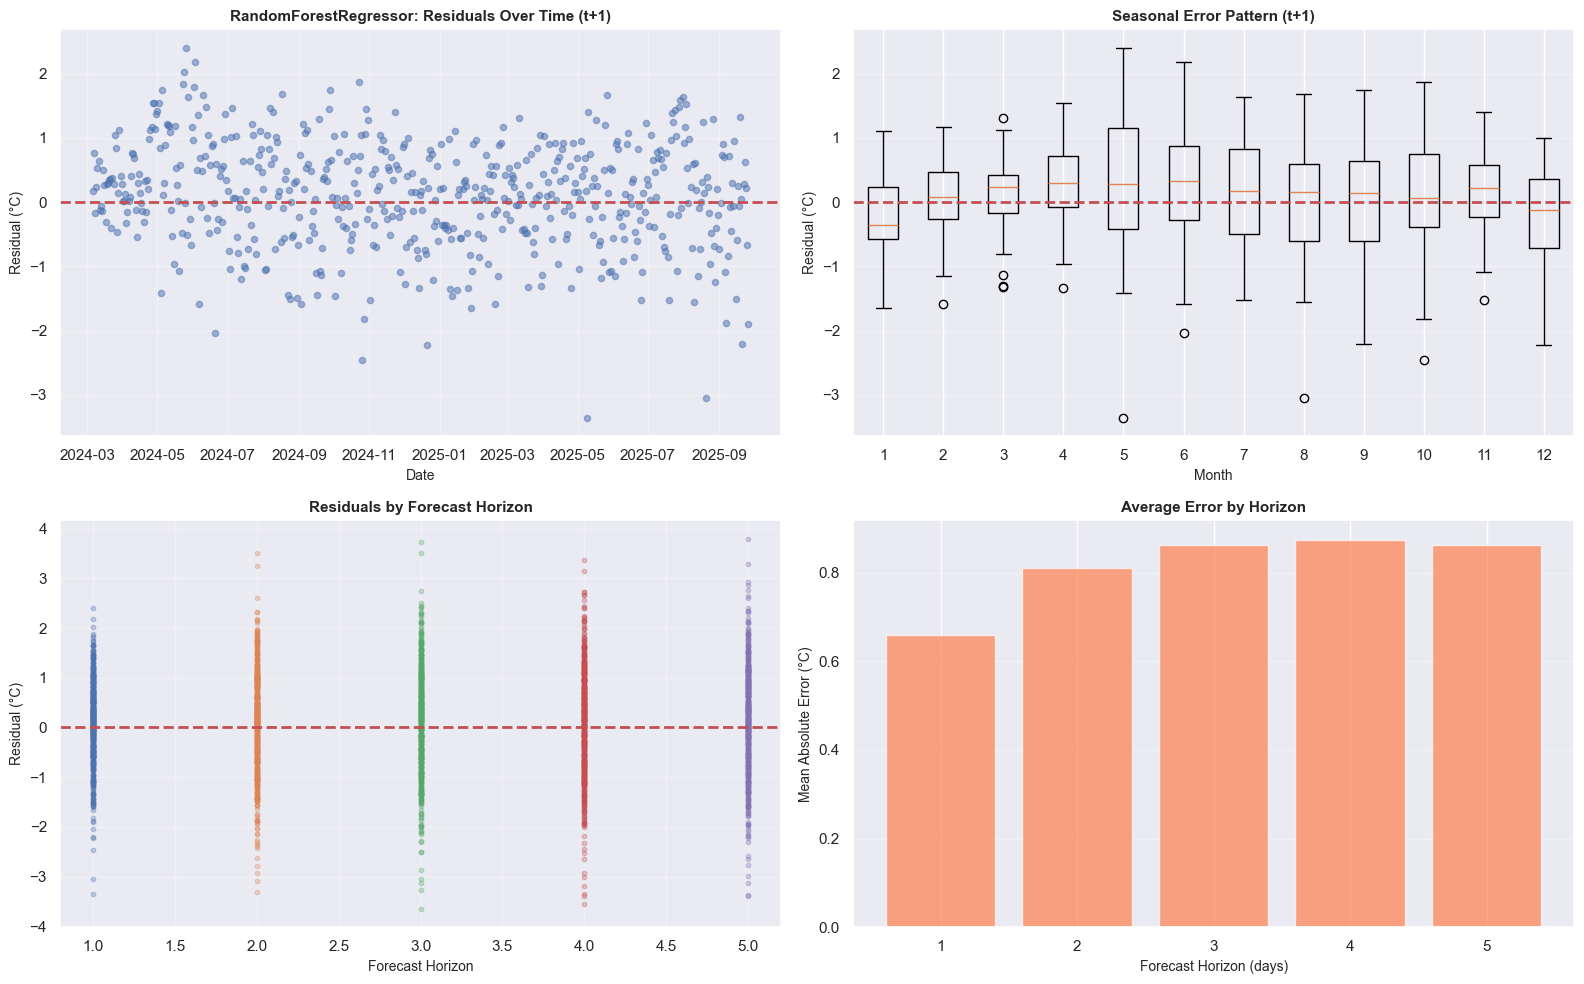


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.1123°C
  Std Dev: 0.8229°C
  Skewness: -0.4167 (left-skewed)
  Kurtosis: 0.5570 (heavy-tailed)
  ~ Moderate bias

Horizon t+2:
  Mean: 0.1013°C
  Std Dev: 1.0060°C
  Skewness: -0.2166 (left-skewed)
  Kurtosis: 0.2414 (heavy-tailed)
  ~ Moderate bias

Horizon t+3:
  Mean: 0.1307°C
  Std Dev: 1.0642°C
  Skewness: -0.1675 (left-skewed)
  Kurtosis: 0.2736 (heavy-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: 0.0893°C
  Std Dev: 1.0815°C
  Skewness: -0.1785 (left-skewed)
  Kurtosis: 0.2193 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+5:
  Mean: 0.1184°C
  Std Dev: 1.0717°C
  Skewness: -0.1472 (left-skewed)
  Kurtosis: 0.2499 (heavy-tailed)
  ~ Moderate bias


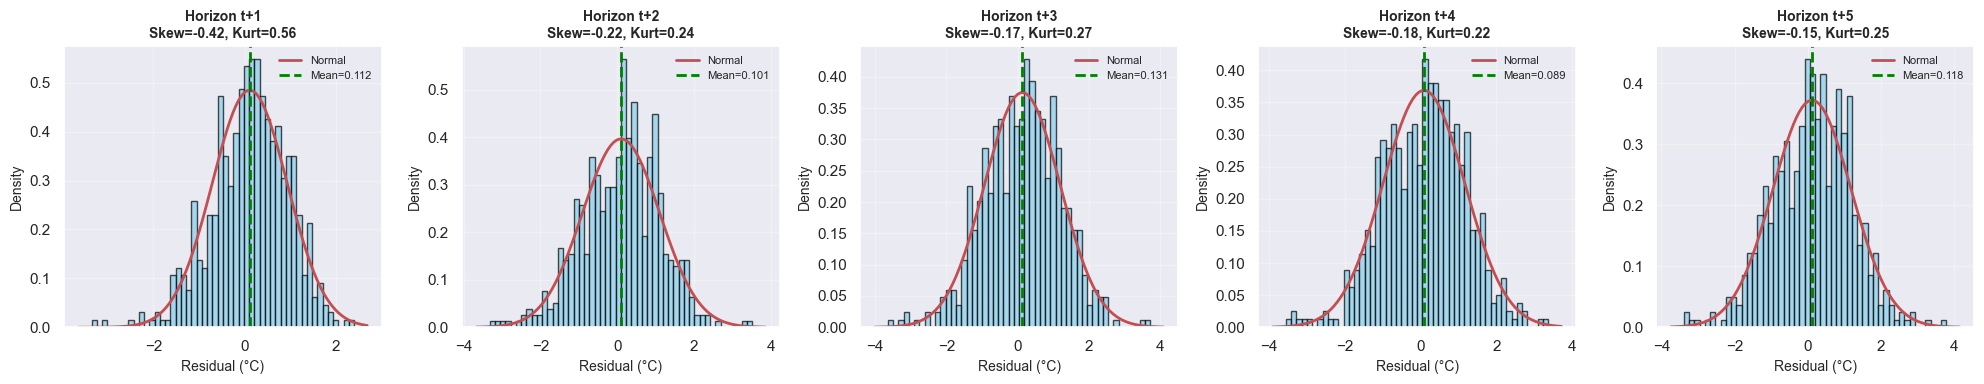


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.689708  0.012608  1.538885           2.503515  1.828040   
1     t+2   1.022207  0.010254  1.108915           2.510182  1.003111   
2     t+3   1.149673  0.017085  1.037792           2.513146  1.486095   
3     t+4   1.177683  0.007969  0.885747           2.513964  0.676681   
4     t+5   1.162461  0.014024  0.896428           2.519957  1.206367   

   Variance %  
0  223.121323  
1  108.482416  
2   90.268381  
3   75.210922  
4   77.114681

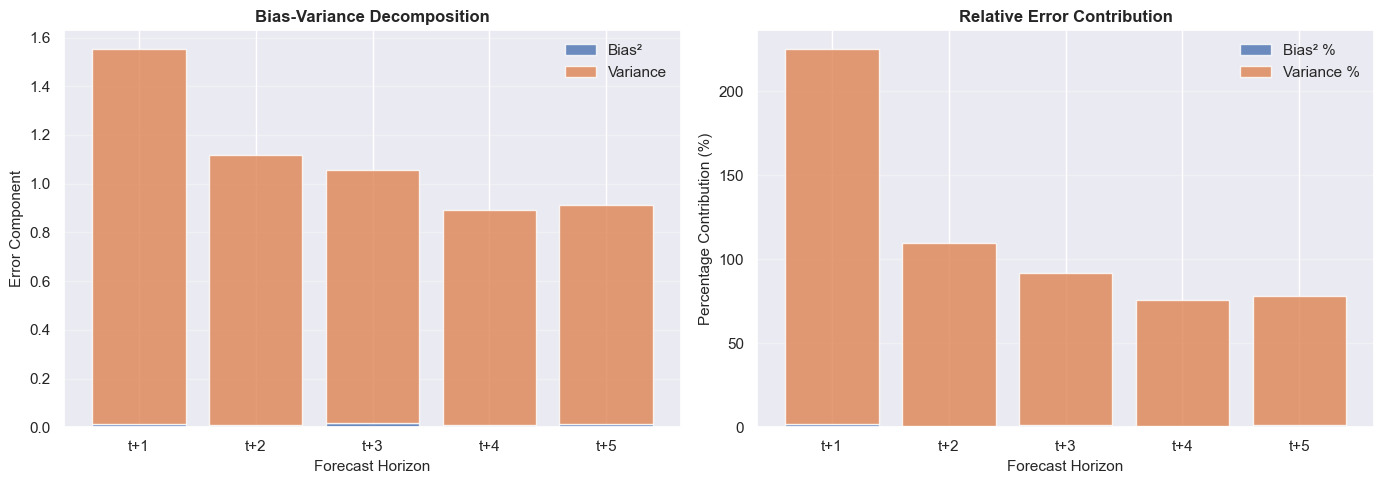


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [16]:
# Analyze RandomForestRegressor model
analyze_model_comprehensive('RandomForestRegressor', model_results, X_train, X_test,
                           y_train, y_test, test_dates, HORIZONS)

In [17]:
# ---(MANUAL TUNE): Random Forest ---

rf_manual_tune_name = 'RandomForest_ManualTune'
print(f"--- Manual Hyperparameter Tuning for: {rf_manual_tune_name} ---")

# 1. Define the grid of hyperparameters to test manually
param_grid = [
    {'n_estimators': 150, 'max_depth': 8,  'min_samples_leaf': 10, 'max_features': 'sqrt'},
    {'n_estimators': 150, 'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.7},
    {'n_estimators': 200, 'max_depth': 8,  'min_samples_leaf': 10, 'max_features': 0.8},
    {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'},
    {'n_estimators': 250, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.7},
]

print(f"Testing {len(param_grid)} different hyperparameter combinations...")

manual_tune_results = []

# 2. Loop through each combination, train, and evaluate using cross-validation
for params in tqdm(param_grid, desc="Tuning Progress"):
    model = MultiOutputRegressor(RandomForestRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1))
    pipeline = make_pipeline(model)

    cv_metrics_folds = cross_val_evaluate(pipeline, X_train, y_train, cv=tscv)
    cv_metrics = aggregate_metrics(cv_metrics_folds)

    manual_tune_results.append({
        'params': params,
        'metrics': cv_metrics
    })
    print(f"\nParams: {params}")
    print(f"CV RMSE: {cv_metrics['RMSE_macro']:.4f}")

# 3. Find the best set of hyperparameters based on the lowest CV RMSE
best_result = min(manual_tune_results, key=lambda x: x['metrics']['RMSE_macro'])
best_params_rf = best_result['params']

print("\n--- Best Hyperparameters Found (Manual Tune) ---")
print(best_params_rf)
print(f"Best CV RMSE: {best_result['metrics']['RMSE_macro']:.4f}")

# 4. Train the final tuned model on the full training data
print(f"\n--- Training final model: {rf_manual_tune_name} ---")
final_rf_model = MultiOutputRegressor(RandomForestRegressor(**best_params_rf, random_state=RANDOM_STATE, n_jobs=-1))
final_rf_pipeline = make_pipeline(final_rf_model)
final_rf_pipeline.fit(X_train, y_train)

# 5. Make predictions and evaluate
print("--- Making predictions ---")
y_pred_train_rf_manual = final_rf_pipeline.predict(X_train)
y_pred_test_rf_manual = final_rf_pipeline.predict(X_test)
cv_metrics_rf_manual_folds = cross_val_evaluate(final_rf_pipeline, X_train, y_train, cv=tscv)
cv_metrics_rf_manual = aggregate_metrics(cv_metrics_rf_manual_folds)

# 6. Store the results
print("--- Storing results ---")
model_results[rf_manual_tune_name] = {
    'details': 'Manually-tuned model using Random Forest.',
    'pipeline': final_rf_pipeline,
    'predictions_train': y_pred_train_rf_manual,
    'predictions_test': y_pred_test_rf_manual,
    'train_metrics': compute_metrics(y_train, y_pred_train_rf_manual),
    'test_metrics': compute_metrics(y_test, y_pred_test_rf_manual),
    'cv_metrics': cv_metrics_rf_manual
}

print(f"--- Finished training and evaluation for {rf_manual_tune_name} ---")


--- Manual Hyperparameter Tuning for: RandomForest_ManualTune ---
Testing 5 different hyperparameter combinations...


Tuning Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Params: {'n_estimators': 150, 'max_depth': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt'}
CV RMSE: 0.9842

Params: {'n_estimators': 150, 'max_depth': 10, 'min_samples_leaf': 8, 'max_features': 0.7}
CV RMSE: 0.9931

Params: {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 10, 'max_features': 0.8}
CV RMSE: 0.9916

Params: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
CV RMSE: 0.9839

Params: {'n_estimators': 250, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.7}
CV RMSE: 0.9955

--- Best Hyperparameters Found (Manual Tune) ---
{'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
Best CV RMSE: 0.9839

--- Training final model: RandomForest_ManualTune ---
--- Making predictions ---
--- Storing results ---
--- Finished training and evaluation for RandomForest_ManualTune ---



COMPREHENSIVE ANALYSIS: RandomForest_ManualTune

## 2. MODEL SPECIFICATION
Model: RandomForest_ManualTune
Details: Manually-tuned model using Random Forest.

Hyperparameters:
  - bootstrap: True
  - ccp_alpha: 0.0
  - criterion: squared_error
  - max_depth: 12
  - max_features: sqrt
  - max_leaf_nodes: None
  - max_samples: None
  - min_impurity_decrease: 0.0
  - min_samples_leaf: 5
  - min_samples_split: 2
  - min_weight_fraction_leaf: 0.0
  - monotonic_cst: None
  - n_estimators: 200
  - n_jobs: -1
  - oob_score: False
  - random_state: 42
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0028

MAE:
  Value: 0.8068

MAPE:
  Value: 2.8058

R2:
  Value: 0.5967


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.833822  0.665574  2.317429  0.722287
1     t+2  0.994968  0.801354  2.786984  0.605621
2     t+3  1.051259  0.848715  2.950826  0.560254
3     t+4  1.068337  0.858889  2.984503  0.545999
4     t+5  1.065746  0.859676  2.989199  0.549272


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.593225  1.002826    0.409602           No
1   MAE_macro  0.454966  0.806842    0.351876           No
2    R2_macro  0.797461  0.596687   -0.200775           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 0.9839
CV MAE (mean): 0.7758
CV R² (mean): 0.3848

[Note: Standard deviation would require storing individual fold results]


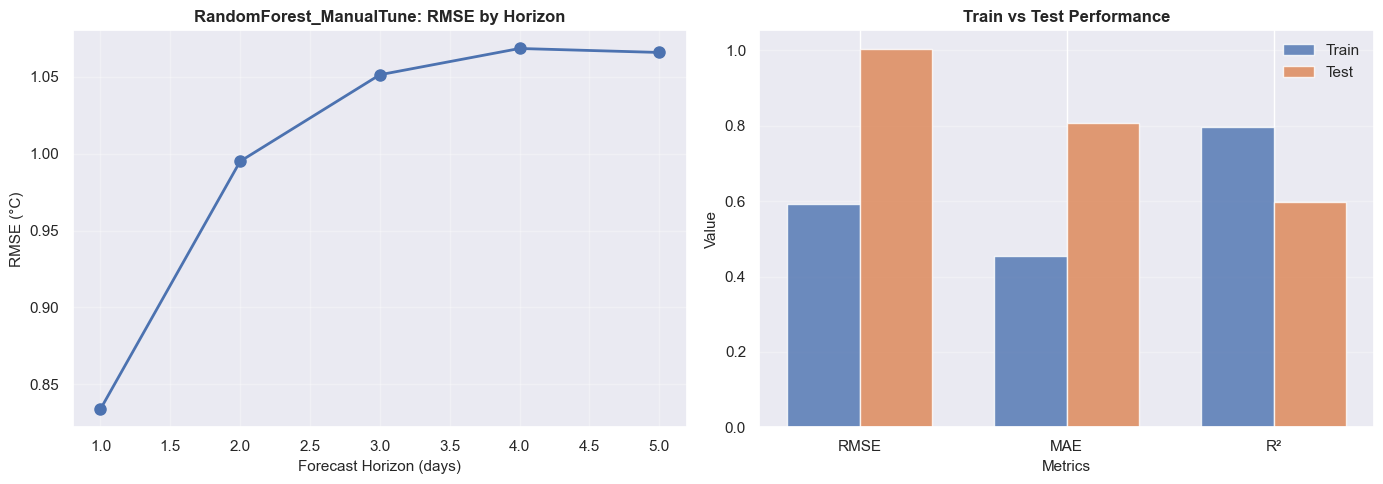


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.282592  0.800753     31
2      0.054850  0.615803     28
3      0.144826  0.560389     57
4      0.369021  0.552567     60
5      0.305670  0.990125     62
6      0.229817  0.915888     60
7      0.164734  0.826469     62
8      0.044262  0.899878     62
9     -0.008295  0.933583     56
10    -0.031057  0.948221     31
11     0.154572  0.624197     30
12    -0.199742  0.816033     31


High Error Periods (top 10% errors > 1.33°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


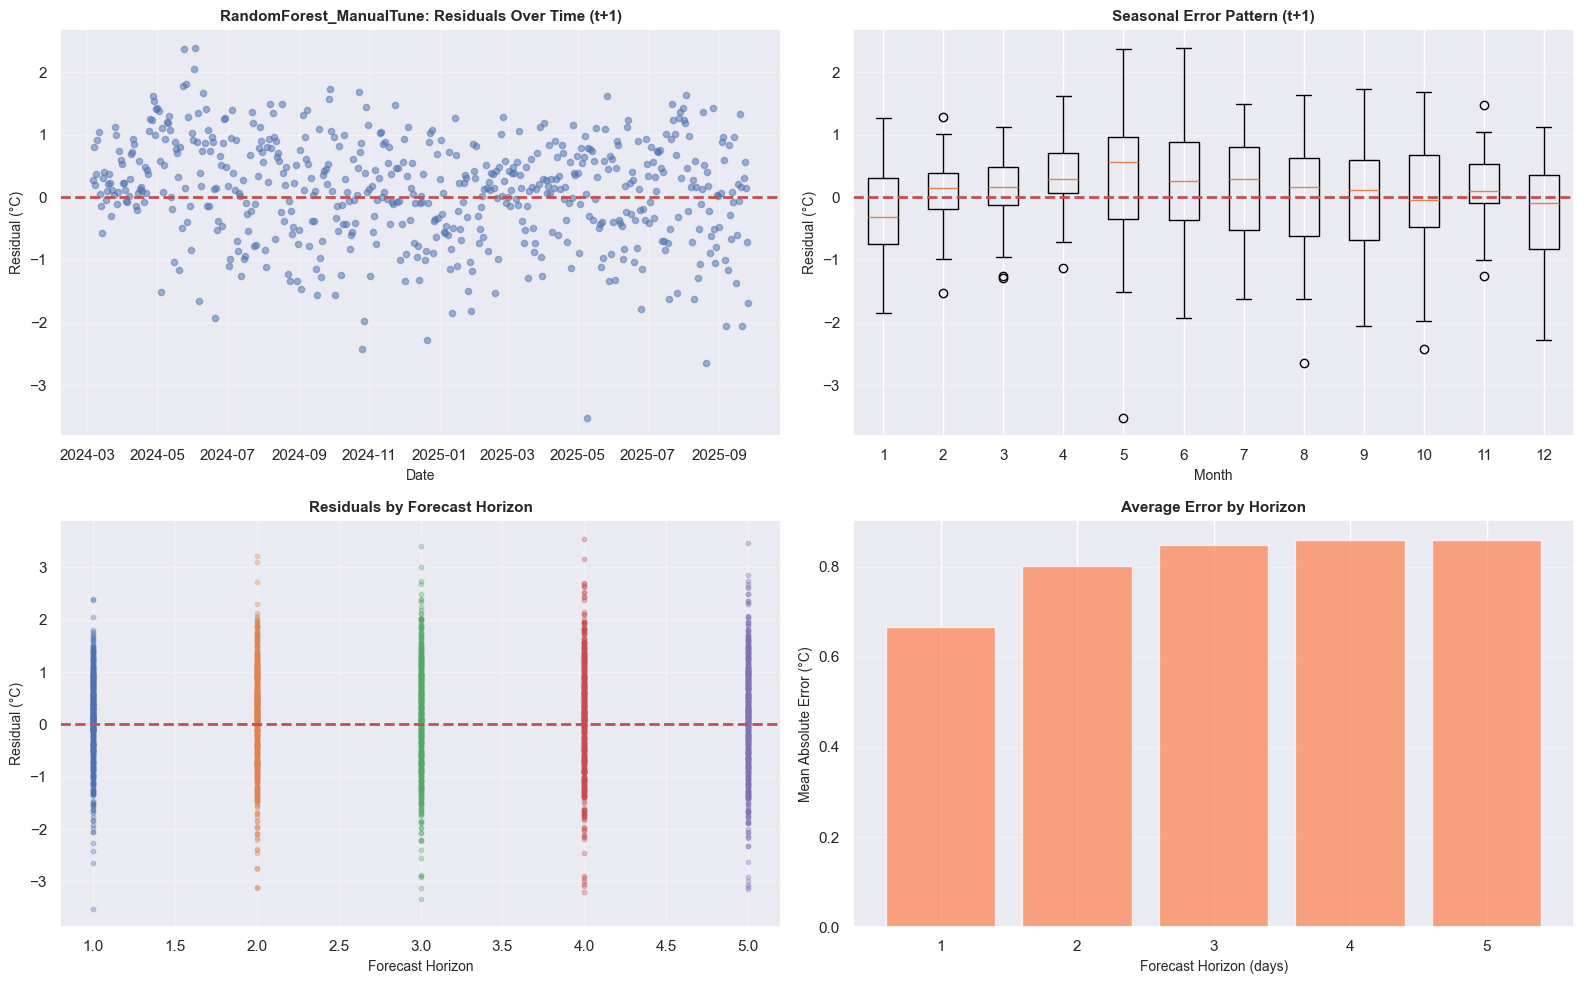


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.1156°C
  Std Dev: 0.8258°C
  Skewness: -0.4527 (left-skewed)
  Kurtosis: 0.4959 (heavy-tailed)
  ~ Moderate bias

Horizon t+2:
  Mean: 0.1505°C
  Std Dev: 0.9835°C
  Skewness: -0.2725 (left-skewed)
  Kurtosis: 0.1677 (heavy-tailed)
  ~ Moderate bias

Horizon t+3:
  Mean: 0.1450°C
  Std Dev: 1.0412°C
  Skewness: -0.2060 (left-skewed)
  Kurtosis: 0.0889 (heavy-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: 0.1453°C
  Std Dev: 1.0584°C
  Skewness: -0.1616 (left-skewed)
  Kurtosis: 0.1336 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: 0.1251°C
  Std Dev: 1.0584°C
  Skewness: -0.1710 (left-skewed)
  Kurtosis: 0.0322 (heavy-tailed)
  ~ Moderate bias


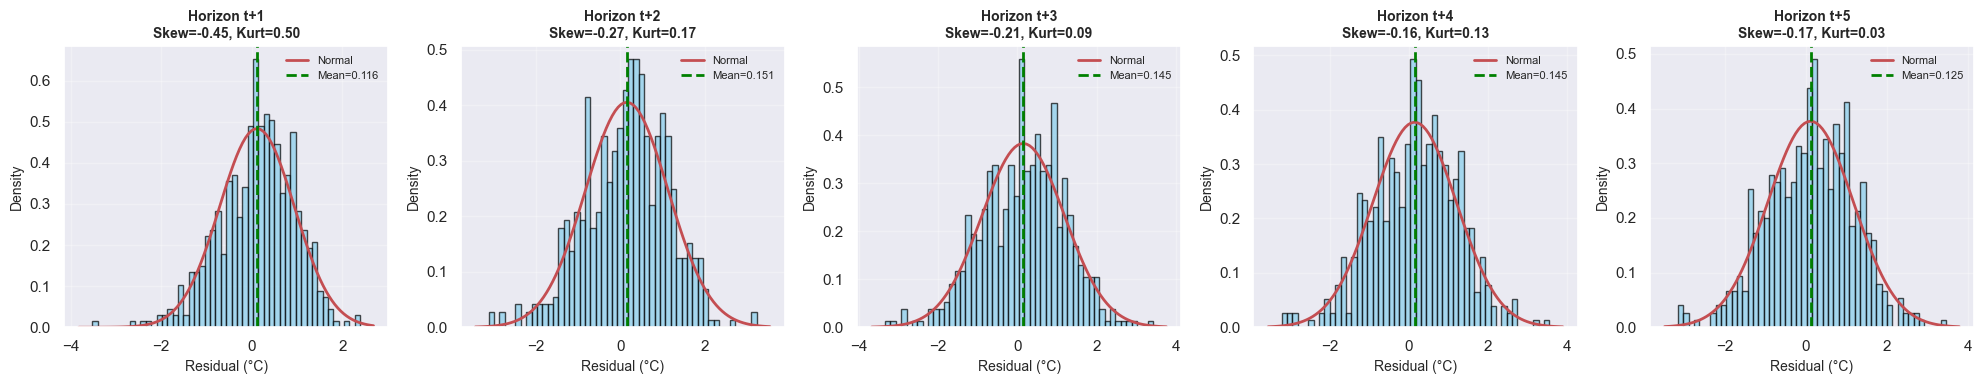


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.695259  0.013362  1.383977           2.503515  1.921834   
1     t+2   0.989962  0.022655  1.112525           2.510182  2.288493   
2     t+3   1.105146  0.021029  0.983076           2.513146  1.902799   
3     t+4   1.141343  0.021107  0.932399           2.513964  1.849337   
4     t+5   1.135815  0.015646  0.879702           2.519957  1.377498   

   Variance %  
0  199.059318  
1  112.380542  
2   88.954410  
3   81.693164  
4   77.451113

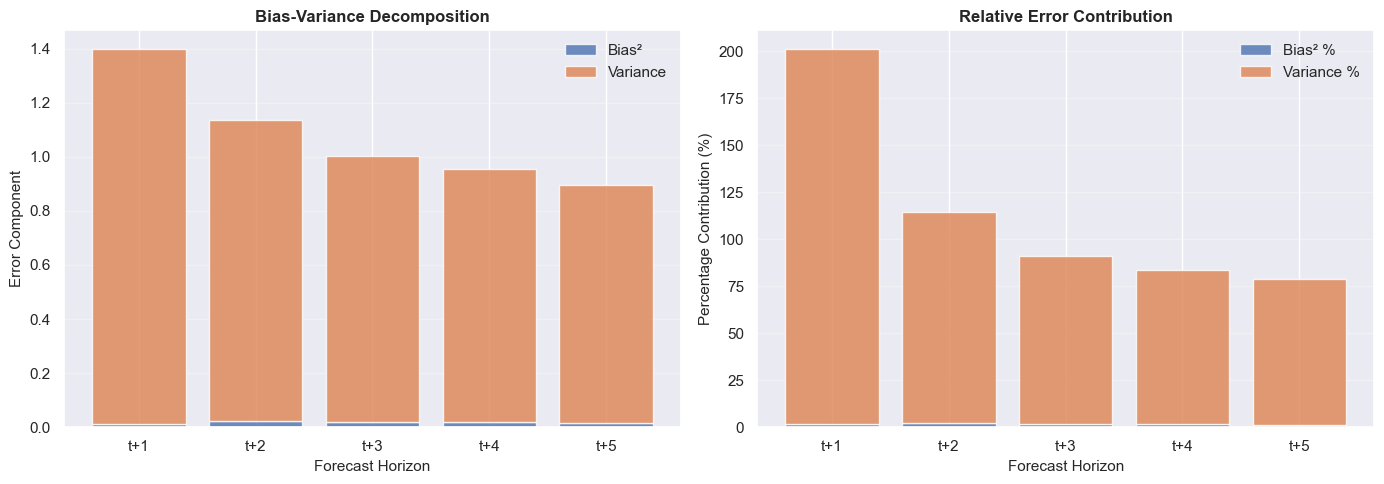


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [18]:
# Analyze the manually tuned Random Forest model
analyze_model_comprehensive(
     'RandomForest_ManualTune',
     model_results,
     X_train,
     X_test,
     y_train,
     y_test,
     test_dates,
     HORIZONS
 )

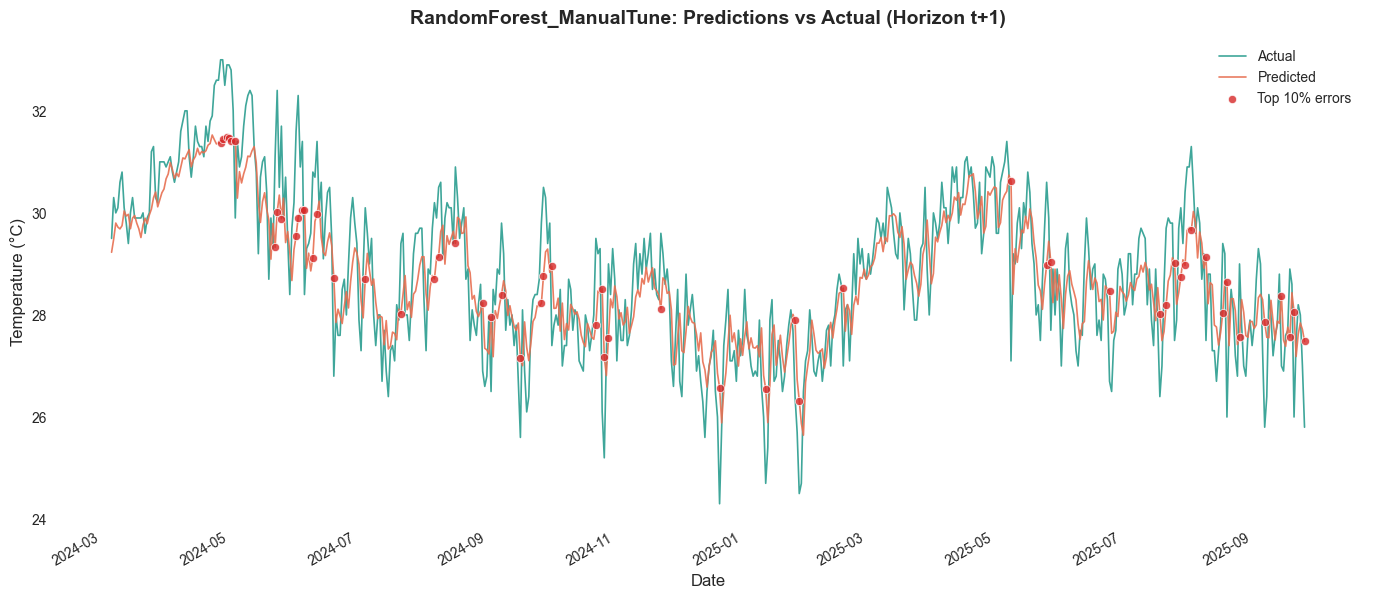

In [19]:
#======================== Visulization between Actual and Predict of Manual tune Random Forest model ========================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_name = 'RandomForest_ManualTune'  # đổi theo model bạn muốn
preds = model_results[model_name]['predictions_test']
residuals = y_test.values - preds

# Top 10% lỗi lớn
error_threshold = np.percentile(np.abs(residuals[:, 0]), 90)
high_error_mask = np.abs(residuals[:, 0]) > error_threshold

plt.figure(figsize=(14, 6))

# --- Actual vs Predicted (màu nhẹ, line mảnh) ---
plt.plot(
    test_dates, y_test.values[:, 0],
    color='#2a9d8f', label='Actual', linewidth=1.2, alpha=0.9
)
plt.plot(
    test_dates, preds[:, 0],
    color='#e76f51', label='Predicted', linewidth=1.2, alpha=0.9
)

# --- Scatter: Top 10% errors (nổi bật) ---
plt.scatter(
    test_dates[high_error_mask], preds[:, 0][high_error_mask],
    color='#d62828', s=35, label='Top 10% errors',
    zorder=5, alpha=0.8, edgecolors='white', linewidth=0.6
)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title(f'{model_name}: Predictions vs Actual (Horizon t+1)',
          fontsize=14, fontweight='bold', pad=10)

plt.legend(frameon=False, fontsize=10)
plt.grid(True, alpha=0.15, linestyle='--')
plt.gca().set_facecolor('white')
plt.tight_layout()


plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', length=0) 


for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)

plt.show()


### **4. HistGradientBoosting**


COMPREHENSIVE ANALYSIS: HistGradientBoosting

## 2. MODEL SPECIFICATION
Model: HistGradientBoosting
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - categorical_features: from_dtype
  - early_stopping: auto
  - interaction_cst: None
  - l2_regularization: 0.0
  - learning_rate: 0.1
  - loss: squared_error
  - max_bins: 255
  - max_depth: None
  - max_features: 1.0
  - max_iter: 100
  - max_leaf_nodes: 31
  - min_samples_leaf: 20
  - monotonic_cst: None
  - n_iter_no_change: 10
  - quantile: None
  - random_state: 42
  - scoring: loss
  - tol: 1e-07
  - validation_fraction: 0.1
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0290

MAE:
  Value: 0.8163

MAPE:
  Value: 2.8642

R2:
  Value: 0.5741


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.833782  0.659673  2.303848  0.722314
1     t+2  0.992950  0.793877  2.777628  0.607220
2     t+3  1.096626  0.869046  3.046806  0.521481
3     t+4  1.112222  0.880901  3.110472  0.507934
4     t+5  1.109665  0.878013  3.082209  0.511358


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.357375  1.029049    0.671674          Yes
1   MAE_macro  0.278198  0.816302    0.538104          Yes
2    R2_macro  0.926549  0.574061   -0.352488           No


⚠ Potential overfitting detected (large train-test gap)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0364
CV MAE (mean): 0.8190
CV R² (mean): 0.3120

[Note: Standard deviation would require storing individual fold results]


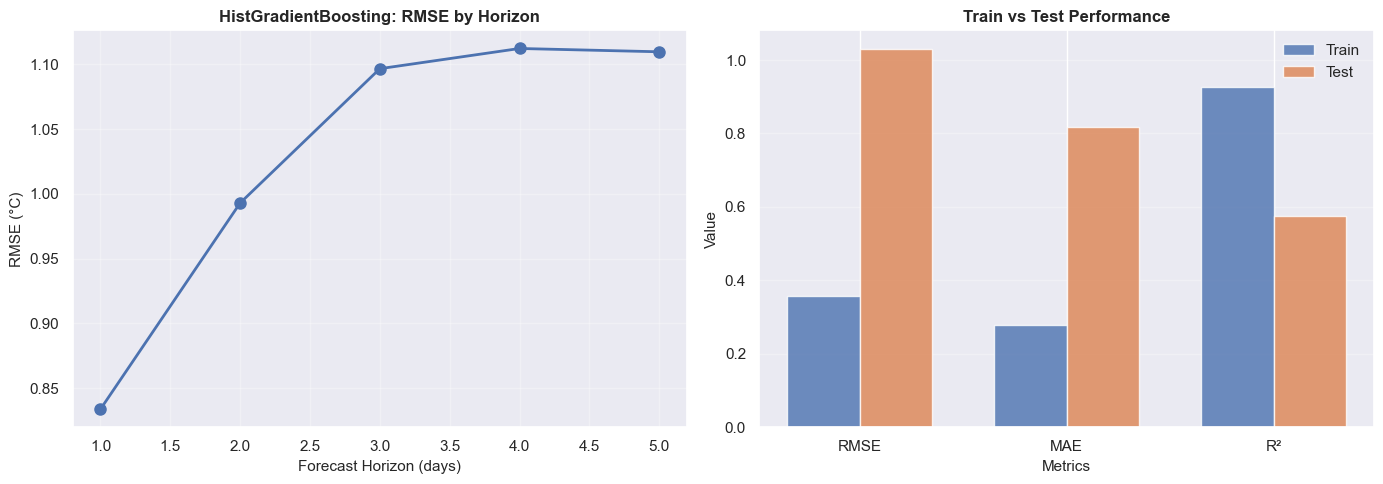


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.354690  0.778386     31
2     -0.105575  0.674255     28
3      0.136637  0.527620     57
4      0.149204  0.632364     60
5      0.179827  0.987897     62
6      0.186658  0.901642     60
7      0.109302  0.851121     62
8      0.015007  0.890952     62
9      0.010035  0.938292     56
10     0.028501  0.977916     31
11     0.148142  0.671034     30
12    -0.259799  0.858395     31


High Error Periods (top 10% errors > 1.36°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


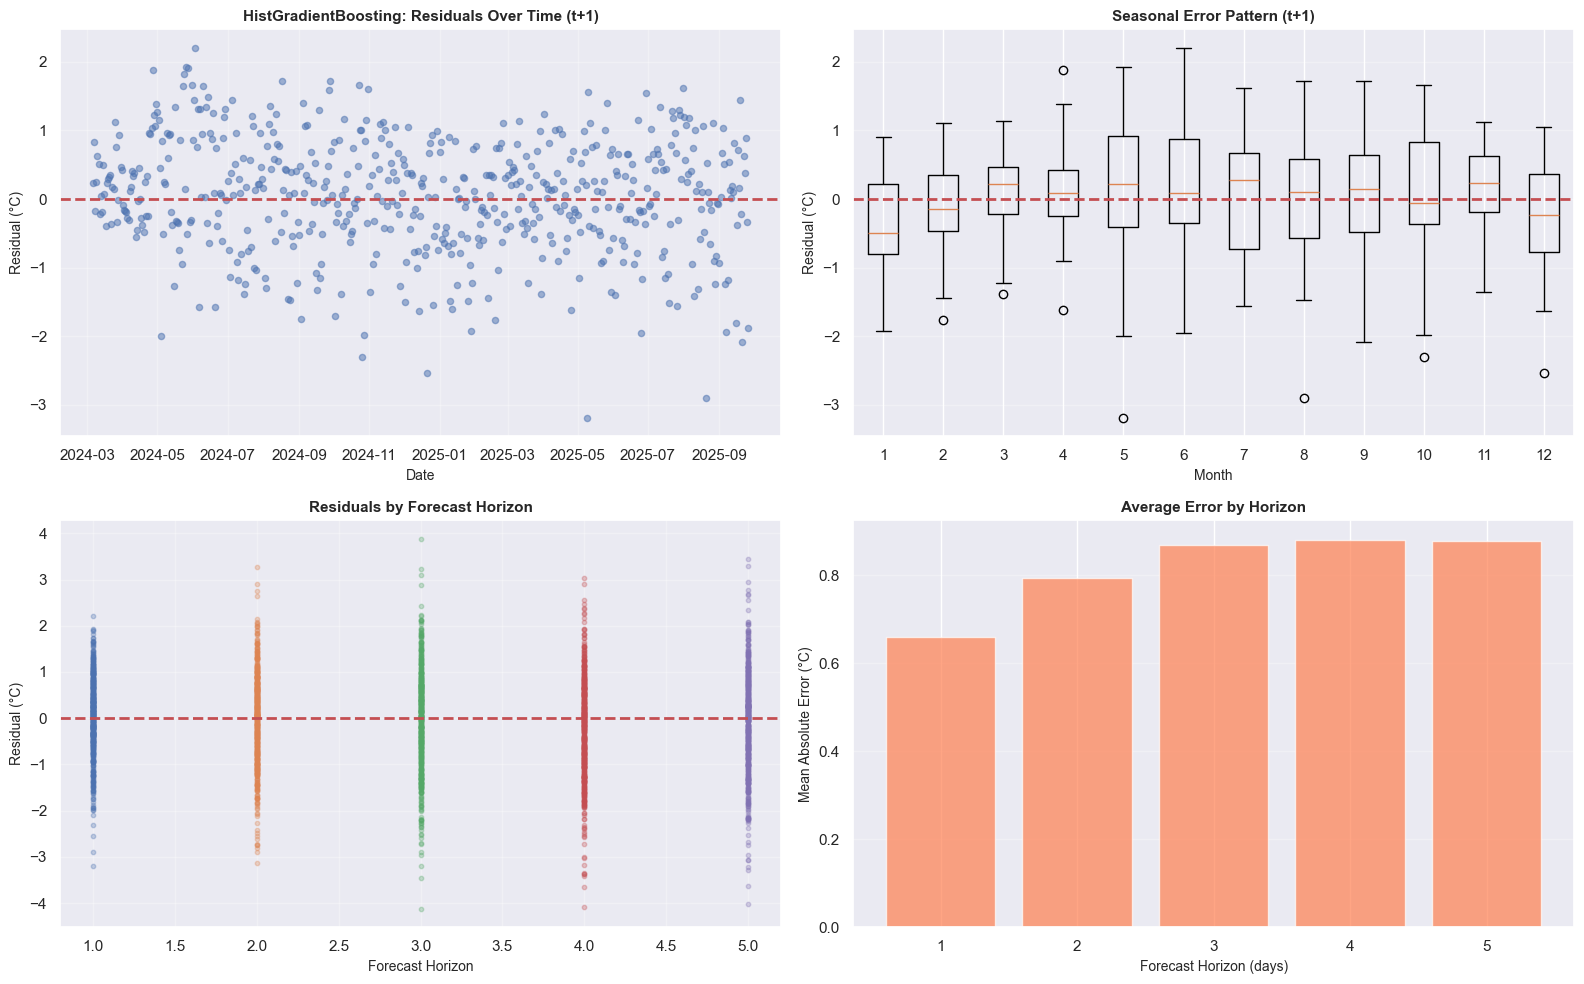


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0538°C
  Std Dev: 0.8320°C
  Skewness: -0.4045 (left-skewed)
  Kurtosis: 0.3227 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0207°C
  Std Dev: 0.9927°C
  Skewness: -0.1545 (left-skewed)
  Kurtosis: 0.1512 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0546°C
  Std Dev: 1.0953°C
  Skewness: -0.1517 (left-skewed)
  Kurtosis: 0.3573 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.2313°C
  Std Dev: 1.0879°C
  Skewness: -0.1851 (left-skewed)
  Kurtosis: 0.2853 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.0845°C
  Std Dev: 1.1064°C
  Skewness: -0.1869 (left-skewed)
  Kurtosis: 0.3080 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)


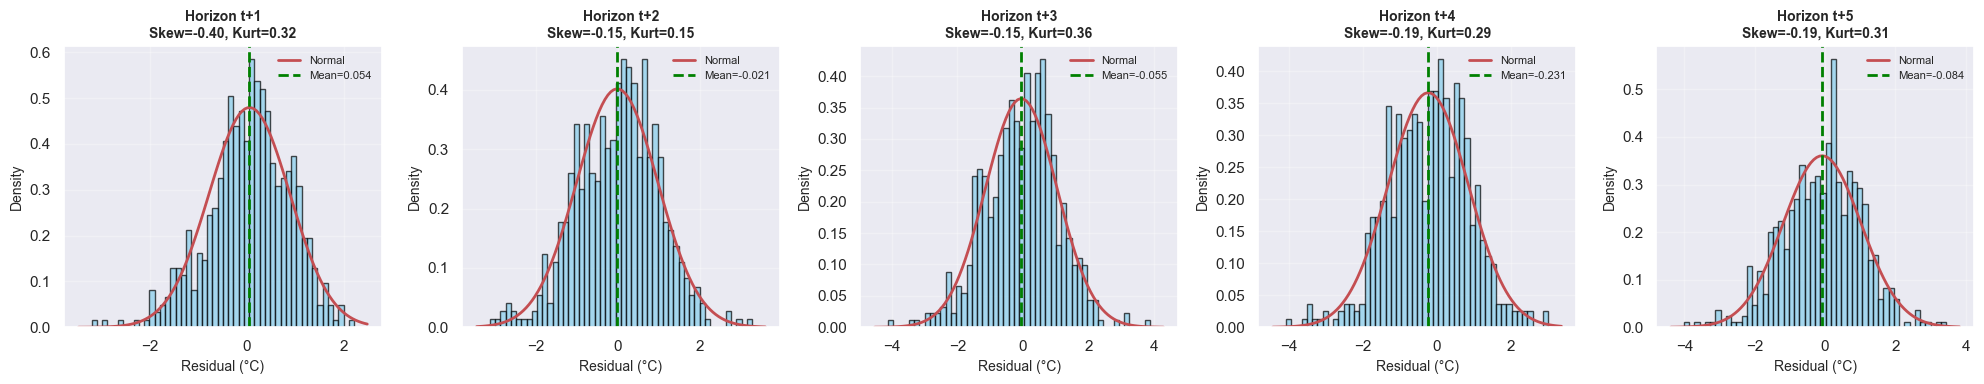


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.695192  0.002897  1.640624           2.503515  0.416758   
1     t+2   0.985950  0.000430  1.114009           2.510182  0.043588   
2     t+3   1.202589  0.002979  1.055072           2.513146  0.247728   
3     t+4   1.237037  0.053481  0.875828           2.513964  4.323309   
4     t+5   1.231355  0.007137  0.885820           2.519957  0.579635   

   Variance %  
0  235.995896  
1  112.988320  
2   87.733386  
3   70.800435  
4   71.938644

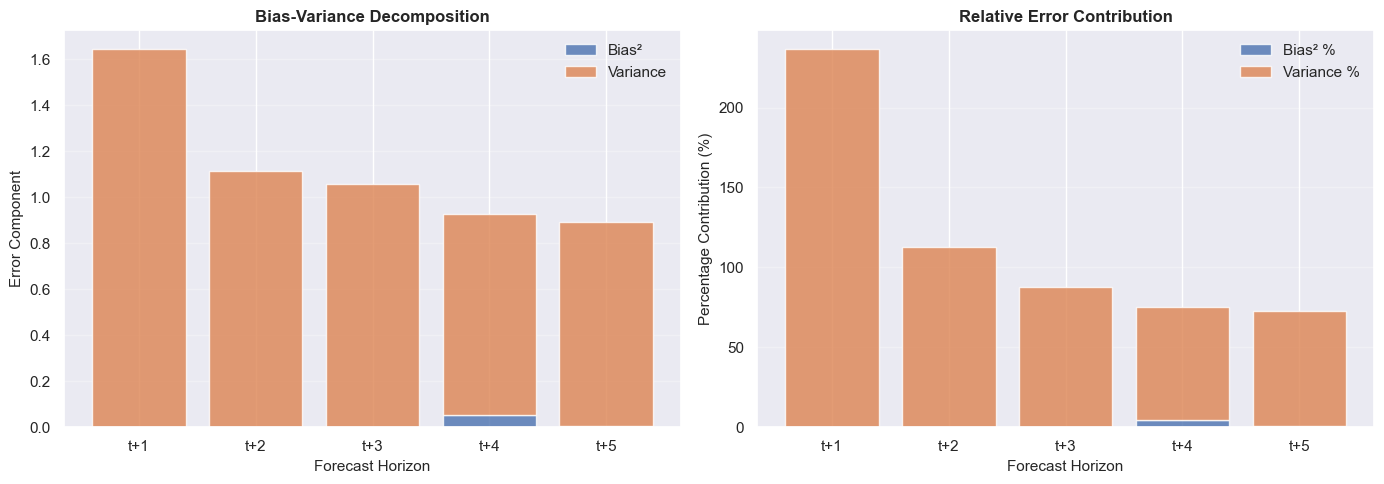


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [20]:
# #Analyse Baseline HGB:
analyze_model_comprehensive(
     'HistGradientBoosting',
     model_results,
     X_train, X_test, y_train, y_test, test_dates
 )

#### **Tuning using optuna**

Optuna was applied to automatically optimize key hyperparameters of the HistGradientBoostingRegressor using a Bayesian optimization approach (TPE sampler). The objective function minimized the average macro RMSE across three time-series cross-validation folds.

The parameters tuned included:

- vlearning_rate (0.01–0.2) – controls gradient step size, balancing learning speed and stability.

- max_depth (3–12) – limits tree complexity to prevent overfitting.

- max_iter (200–700) – number of boosting iterations.

- min_samples_leaf (5–80) – smooths predictions by setting minimum samples per leaf.

- l2_regularization (1e−8–1e−1) – adds penalty to reduce variance.

After 10 optimization trials, the best configuration found was:
learning_rate = 0.0201, max_depth = 3, max_iter = 493, min_samples_leaf = 25, and l2_regularization = 9.85×10⁻⁶, achieving a balanced trade-off between bias and variance.

In [21]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def optuna_objective(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'max_iter': trial.suggest_int('max_iter', 200, 700),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 80),
#         'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 1e-1, log=True)
#     }
#     estimator = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=RANDOM_STATE, **params))
#     pipeline = make_pipeline(estimator)
#     fold_metrics = cross_val_evaluate(pipeline, X_train, y_train, TimeSeriesSplit(n_splits=3))
#     return float(np.mean([fold['RMSE_macro'] for fold in fold_metrics]))

# study = optuna.create_study(direction='minimize', study_name='hgb_hyperopt')
# study.optimize(optuna_objective, n_trials=10, timeout=900)
# print('Best Optuna params:', study.best_trial.params)

In [22]:
#Best Optuna params: {'learning_rate': 0.02014148621347681, 'max_depth': 3, 'max_iter': 493,
# 'min_samples_leaf': 25, 'l2_regularization': 9.852173472173725e-06}

In [23]:
# ===========================================
# MODEL 2: OPTUNA-TUNED HISTGRADIENTBOOSTINGREGRESSOR
# ===========================================

print("\n" + "="*80)
print("MODEL 2: OPTUNA-TUNED HISTGRADIENTBOOSTINGREGRESSOR")
print("="*80)

best_params = {
    'learning_rate': 0.02014148621347681,
    'max_depth': 3,
    'max_iter': 493,
    'min_samples_leaf': 25,
    'l2_regularization': 9.852173472173725e-06
}

optuna_estimator = MultiOutputRegressor(
    HistGradientBoostingRegressor(random_state=RANDOM_STATE, **best_params)
)
optuna_pipeline = make_pipeline(optuna_estimator)

cv_metrics_optuna = aggregate_metrics(cross_val_evaluate(optuna_pipeline, X_train, y_train, tscv))
optuna_pipeline.fit(X_train, y_train)

train_pred_optuna = optuna_pipeline.predict(X_train)
test_pred_optuna  = optuna_pipeline.predict(X_test)

model_results['HistGradientBoosting_Optuna'] = {
    'pipeline': optuna_pipeline,
    'cv_metrics': cv_metrics_optuna,
    'train_metrics': compute_metrics(y_train.values, train_pred_optuna),
    'test_metrics': compute_metrics(y_test.values, test_pred_optuna),
    'predictions_test': test_pred_optuna,
    'predictions_train': train_pred_optuna,
    'details': f"Optuna-tuned HistGradientBoosting params: {best_params}"
}

# Display metrics as DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['RMSE_macro', 'MAE_macro', 'MAPE_macro', 'R2_macro'],
    'Cross-Validation': [cv_metrics_optuna['RMSE_macro'], cv_metrics_optuna['MAE_macro'],
                         cv_metrics_optuna['MAPE_macro'], cv_metrics_optuna['R2_macro']],
    'Train': [model_results['HistGradientBoosting_Optuna']['train_metrics']['RMSE_macro'],
              model_results['HistGradientBoosting_Optuna']['train_metrics']['MAE_macro'],
              model_results['HistGradientBoosting_Optuna']['train_metrics']['MAPE_macro'],
              model_results['HistGradientBoosting_Optuna']['train_metrics']['R2_macro']],
    'Test': [model_results['HistGradientBoosting_Optuna']['test_metrics']['RMSE_macro'],
             model_results['HistGradientBoosting_Optuna']['test_metrics']['MAE_macro'],
             model_results['HistGradientBoosting_Optuna']['test_metrics']['MAPE_macro'],
             model_results['HistGradientBoosting_Optuna']['test_metrics']['R2_macro']]
})
display(metrics_df.style.set_caption("Optuna-Tuned HistGradientBoostingRegressor"))


MODEL 2: OPTUNA-TUNED HISTGRADIENTBOOSTINGREGRESSOR



COMPREHENSIVE ANALYSIS: HistGradientBoosting_Optuna

## 2. MODEL SPECIFICATION
Model: HistGradientBoosting_Optuna
Details: Optuna-tuned HistGradientBoosting params: {'learning_rate': 0.02014148621347681, 'max_depth': 3, 'max_iter': 493, 'min_samples_leaf': 25, 'l2_regularization': 9.852173472173725e-06}

Hyperparameters:
  - categorical_features: from_dtype
  - early_stopping: auto
  - interaction_cst: None
  - l2_regularization: 9.852173472173725e-06
  - learning_rate: 0.02014148621347681
  - loss: squared_error
  - max_bins: 255
  - max_depth: 3
  - max_features: 1.0
  - max_iter: 493
  - max_leaf_nodes: 31
  - min_samples_leaf: 25
  - monotonic_cst: None
  - n_iter_no_change: 10
  - quantile: None
  - random_state: 42
  - scoring: loss
  - tol: 1e-07
  - validation_fraction: 0.1
  - verbose: 0
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.800919  0.630227  2.203306  0.743772
1     t+2  0.961630  0.760403  2.667974  0.631608
2     t+3  1.033868  0.821062  2.883142  0.574683
3     t+4  1.049166  0.826390  2.906277  0.562146
4     t+5  1.059596  0.835356  2.941957  0.554459


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.754792  0.981036    0.226244           No
1   MAE_macro  0.590144  0.774688    0.184544           No
2    R2_macro  0.671366  0.613334   -0.058032           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0063
CV MAE (mean): 0.7979
CV R² (mean): 0.3517

[Note: Standard deviation would require storing individual fold results]


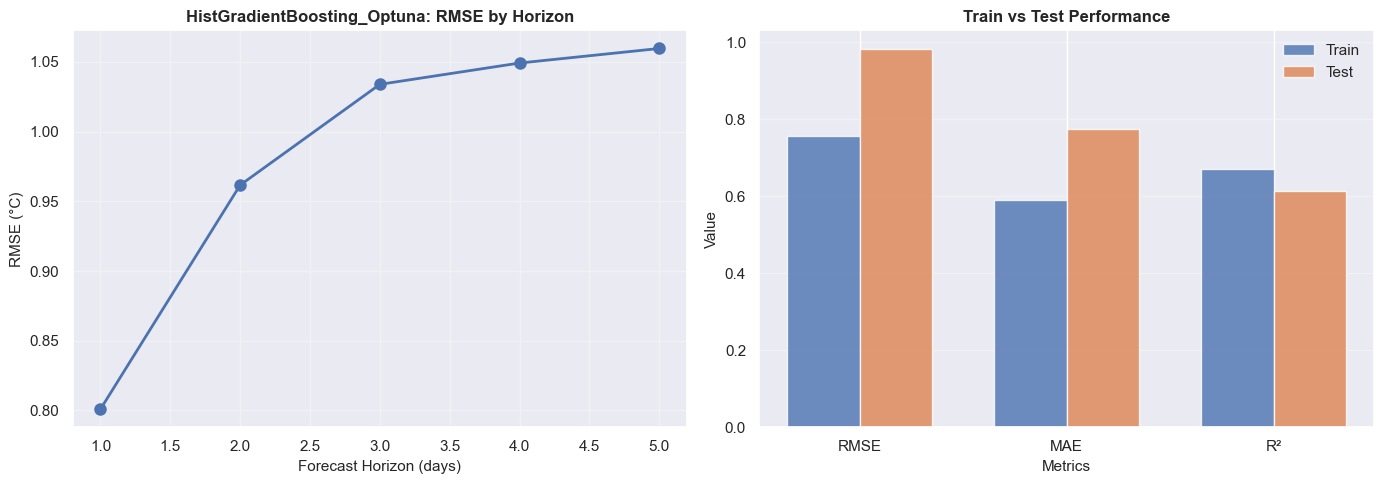


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.295103  0.750388     31
2     -0.094665  0.673066     28
3      0.033673  0.533394     57
4      0.193522  0.580413     60
5      0.099885  0.939621     62
6      0.134950  0.892197     60
7      0.127615  0.797788     62
8     -0.048734  0.871536     62
9      0.008752  0.904402     56
10     0.038023  0.977463     31
11     0.138485  0.626326     30
12    -0.231081  0.801874     31


High Error Periods (top 10% errors > 1.30°C):
Total occurrences: 57
Date range: 2024-04-27 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


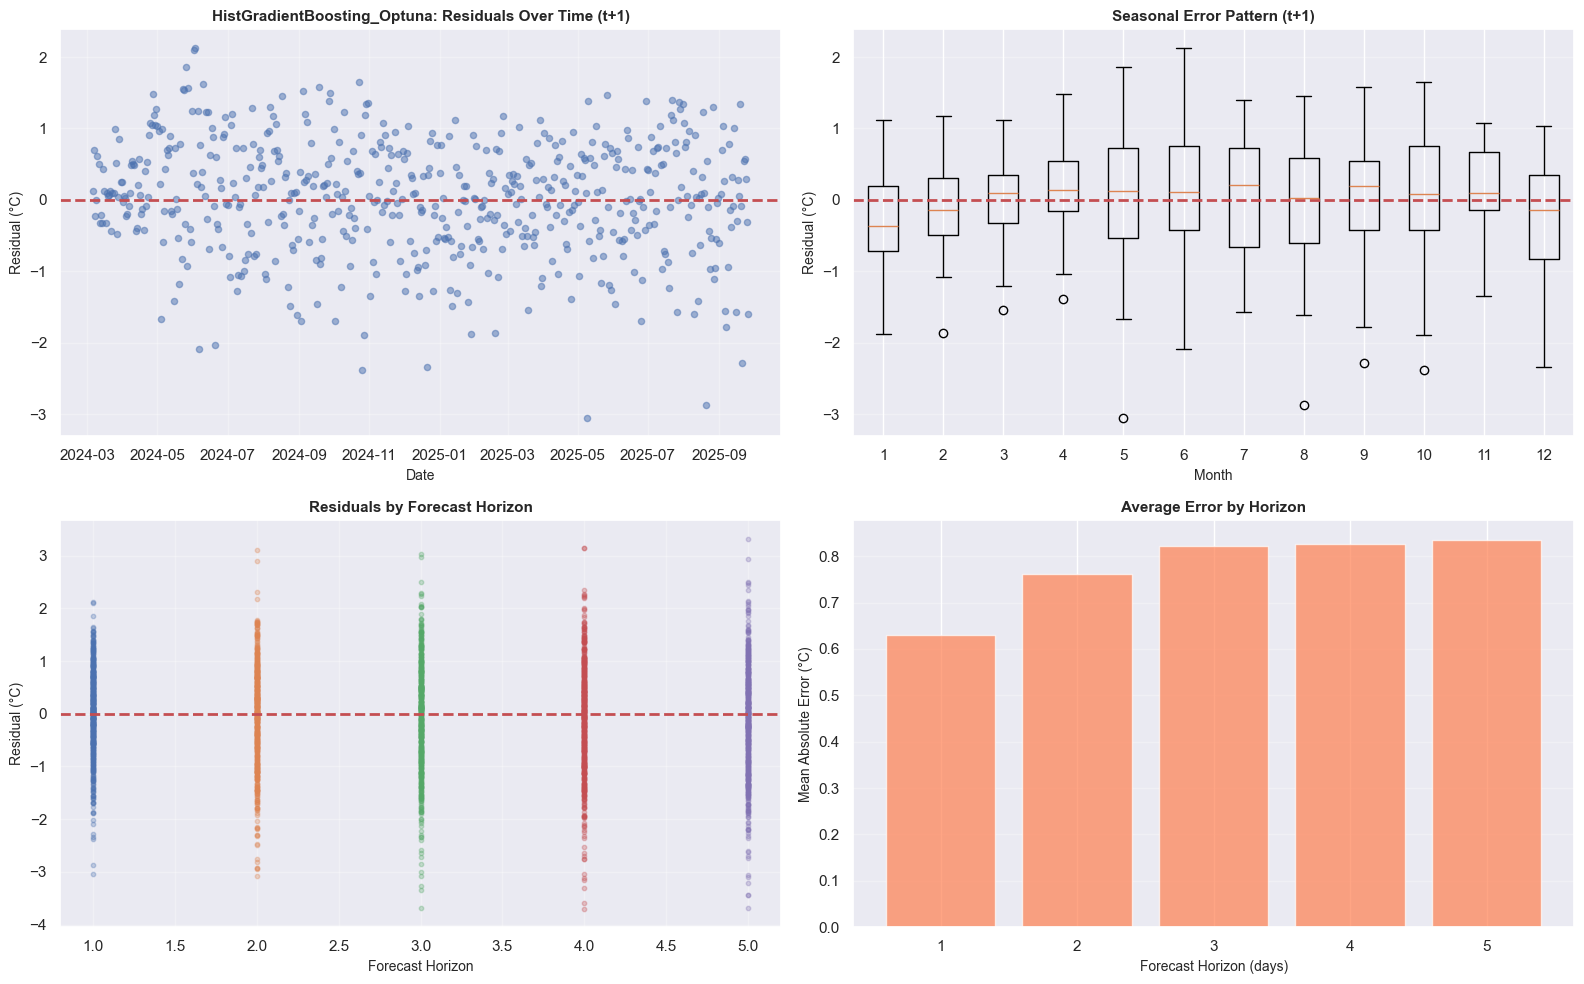


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0343°C
  Std Dev: 0.8002°C
  Skewness: -0.4279 (left-skewed)
  Kurtosis: 0.3770 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0390°C
  Std Dev: 0.9608°C
  Skewness: -0.3166 (left-skewed)
  Kurtosis: 0.2093 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0785°C
  Std Dev: 1.0309°C
  Skewness: -0.2189 (left-skewed)
  Kurtosis: 0.2303 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.1062°C
  Std Dev: 1.0438°C
  Skewness: -0.2440 (left-skewed)
  Kurtosis: 0.3321 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.1444°C
  Std Dev: 1.0497°C
  Skewness: -0.1717 (left-skewed)
  Kurtosis: 0.2735 (heavy-tailed)
  ~ Moderate bias


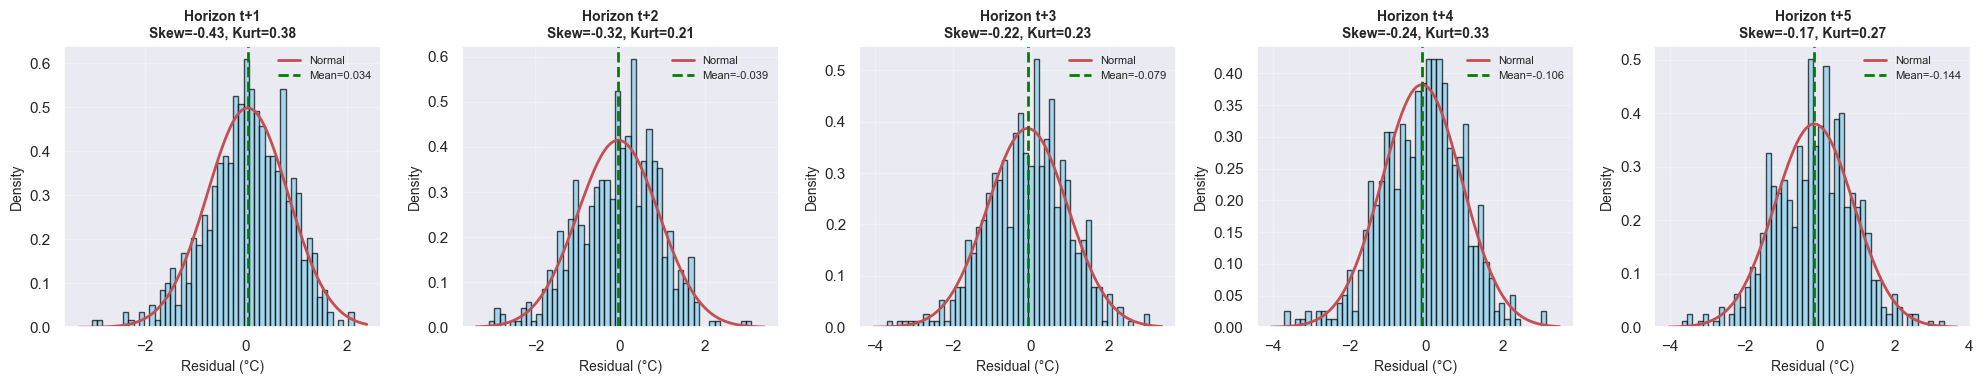


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.641471  0.001179  1.689130           2.503515  0.183804   
1     t+2   0.924731  0.001521  1.208299           2.510182  0.164504   
2     t+3   1.068883  0.006167  1.030042           2.513146  0.576953   
3     t+4   1.100750  0.011273  0.993716           2.513964  1.024081   
4     t+5   1.122743  0.020838  0.938886           2.519957  1.855994   

   Variance %  
0  263.321513  
1  130.664851  
2   96.366177  
3   90.276208  
4   83.624331

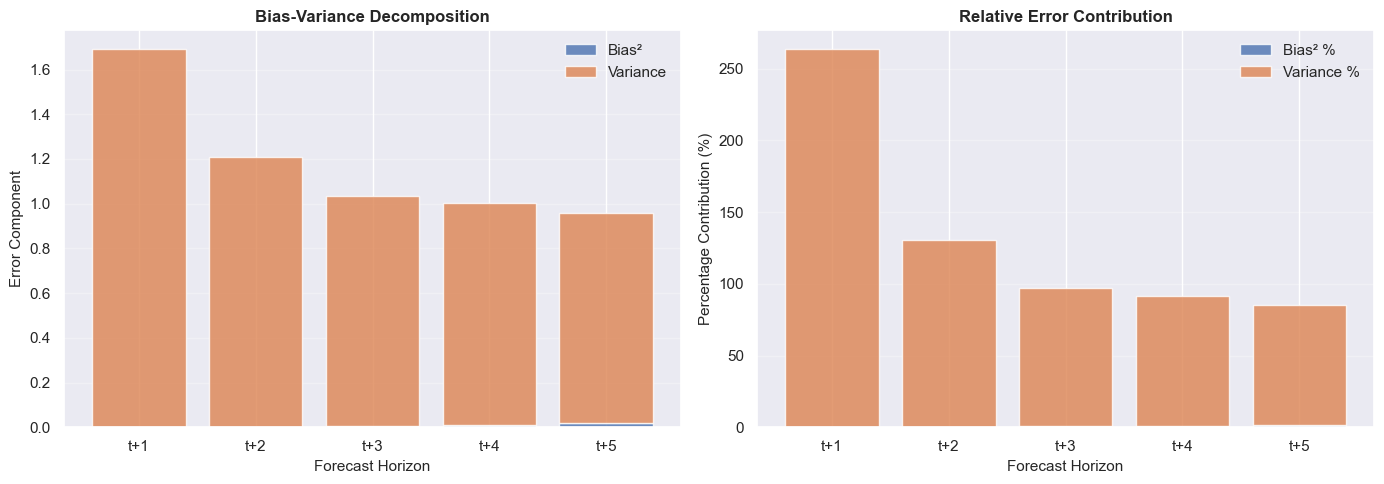


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [24]:
# Analyze the Optuna-tuned HistGradientBoosting model:
analyze_model_comprehensive(
     'HistGradientBoosting_Optuna',
     model_results,
     X_train, X_test, y_train, y_test, test_dates
 )

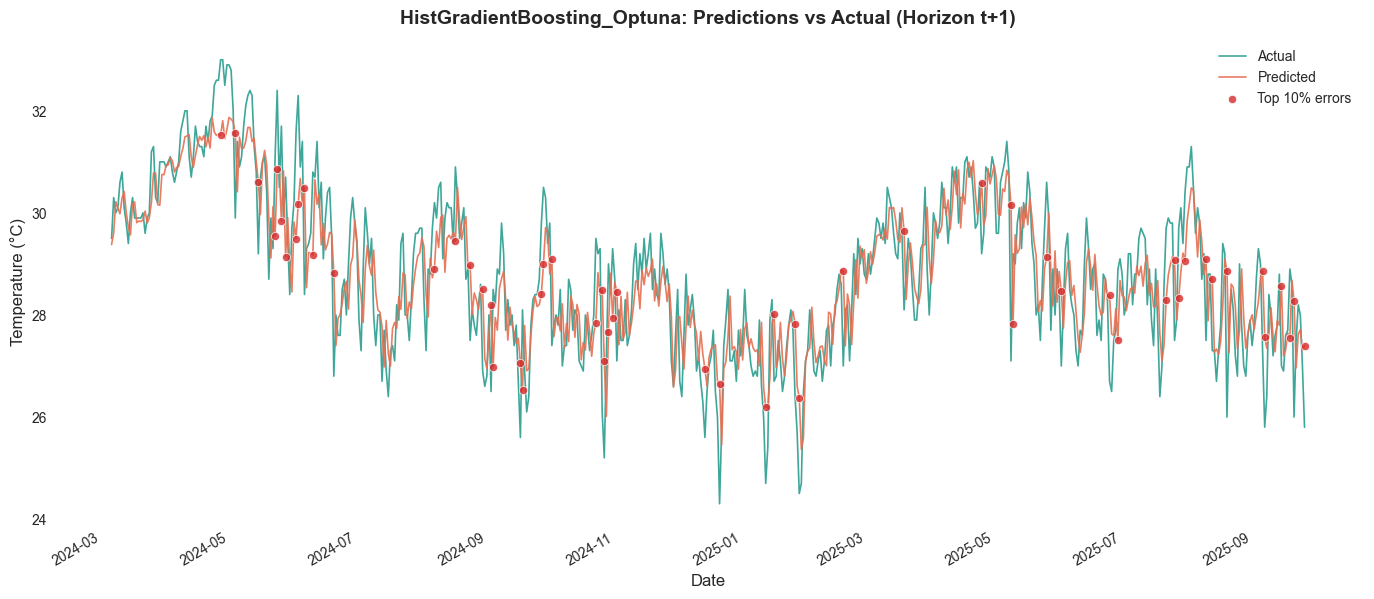

In [25]:
#======================== Visulization between Actual and Predict of Optune-tuned HGB model ========================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_name = 'HistGradientBoosting_Optuna'  
preds = model_results[model_name]['predictions_test']
residuals = y_test.values - preds

# Top 10% lỗi lớn
error_threshold = np.percentile(np.abs(residuals[:, 0]), 90)
high_error_mask = np.abs(residuals[:, 0]) > error_threshold

plt.figure(figsize=(14, 6))

# --- Actual vs Predicted (màu nhẹ, line mảnh) ---
plt.plot(
    test_dates, y_test.values[:, 0],
    color='#2a9d8f', label='Actual', linewidth=1.2, alpha=0.9
)
plt.plot(
    test_dates, preds[:, 0],
    color='#e76f51', label='Predicted', linewidth=1.2, alpha=0.9
)

# --- Scatter: Top 10% errors (nổi bật) ---
plt.scatter(
    test_dates[high_error_mask], preds[:, 0][high_error_mask],
    color='#d62828', s=35, label='Top 10% errors',
    zorder=5, alpha=0.8, edgecolors='white', linewidth=0.6
)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title(f'{model_name}: Predictions vs Actual (Horizon t+1)',
          fontsize=14, fontweight='bold', pad=10)

plt.legend(frameon=False, fontsize=10)
plt.grid(True, alpha=0.15, linestyle='--')
plt.gca().set_facecolor('white')
plt.tight_layout()


plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', length=0) 


for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)

plt.show()


### **5. Huber Regression**


COMPREHENSIVE ANALYSIS: HuberRegressor

## 2. MODEL SPECIFICATION
Model: HuberRegressor
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - alpha: 0.0001
  - epsilon: 1.35
  - fit_intercept: True
  - max_iter: 100
  - tol: 1e-05
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0385

MAE:
  Value: 0.8199

MAPE:
  Value: 2.8883

R2:
  Value: 0.5667


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.847404  0.664329  2.333477  0.713166
1     t+2  1.022708  0.798449  2.816394  0.583325
2     t+3  1.087088  0.863778  3.042393  0.529769
3     t+4  1.120900  0.881018  3.105952  0.500225
4     t+5  1.114623  0.891954  3.143384  0.506982


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.928989  1.038544    0.109555           No
1   MAE_macro  0.704144  0.819906    0.115761           No
2    R2_macro  0.503106  0.566693    0.063587           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.1189
CV MAE (mean): 0.8703
CV R² (mean): 0.1919

[Note: Standard deviation would require storing individual fold results]


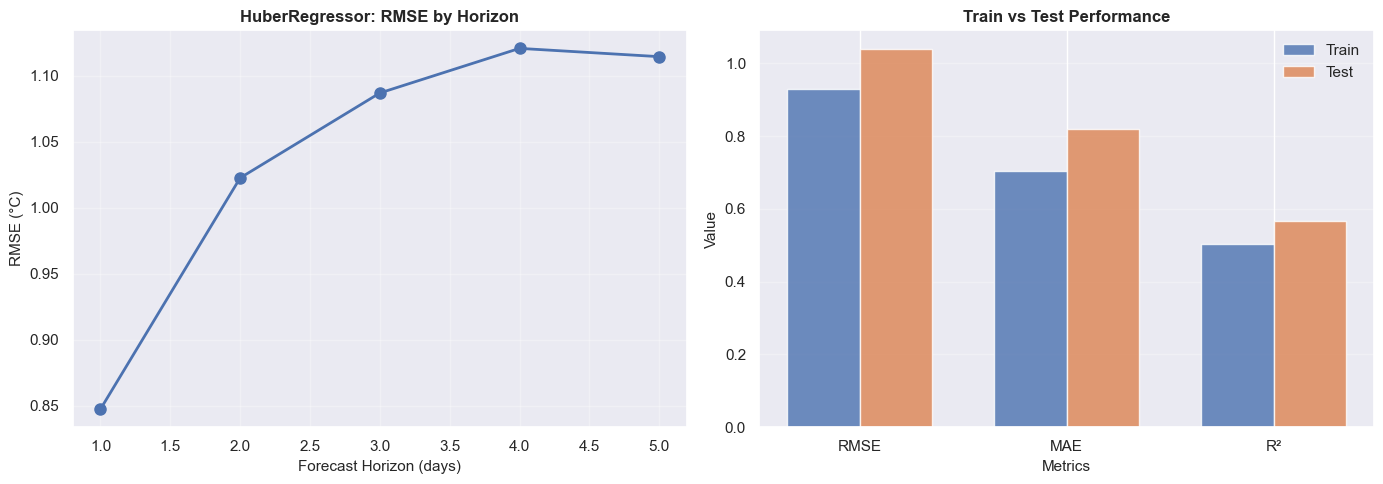


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.256044  0.860015     31
2      0.075656  0.660817     28
3     -0.004328  0.595770     57
4      0.213231  0.487459     60
5     -0.059774  1.027849     62
6     -0.047917  0.943132     60
7     -0.081472  0.849501     62
8     -0.077544  0.830321     62
9     -0.089940  0.899006     56
10    -0.267144  1.117904     31
11    -0.078567  0.681184     30
12    -0.340776  1.008655     31


High Error Periods (top 10% errors > 1.42°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


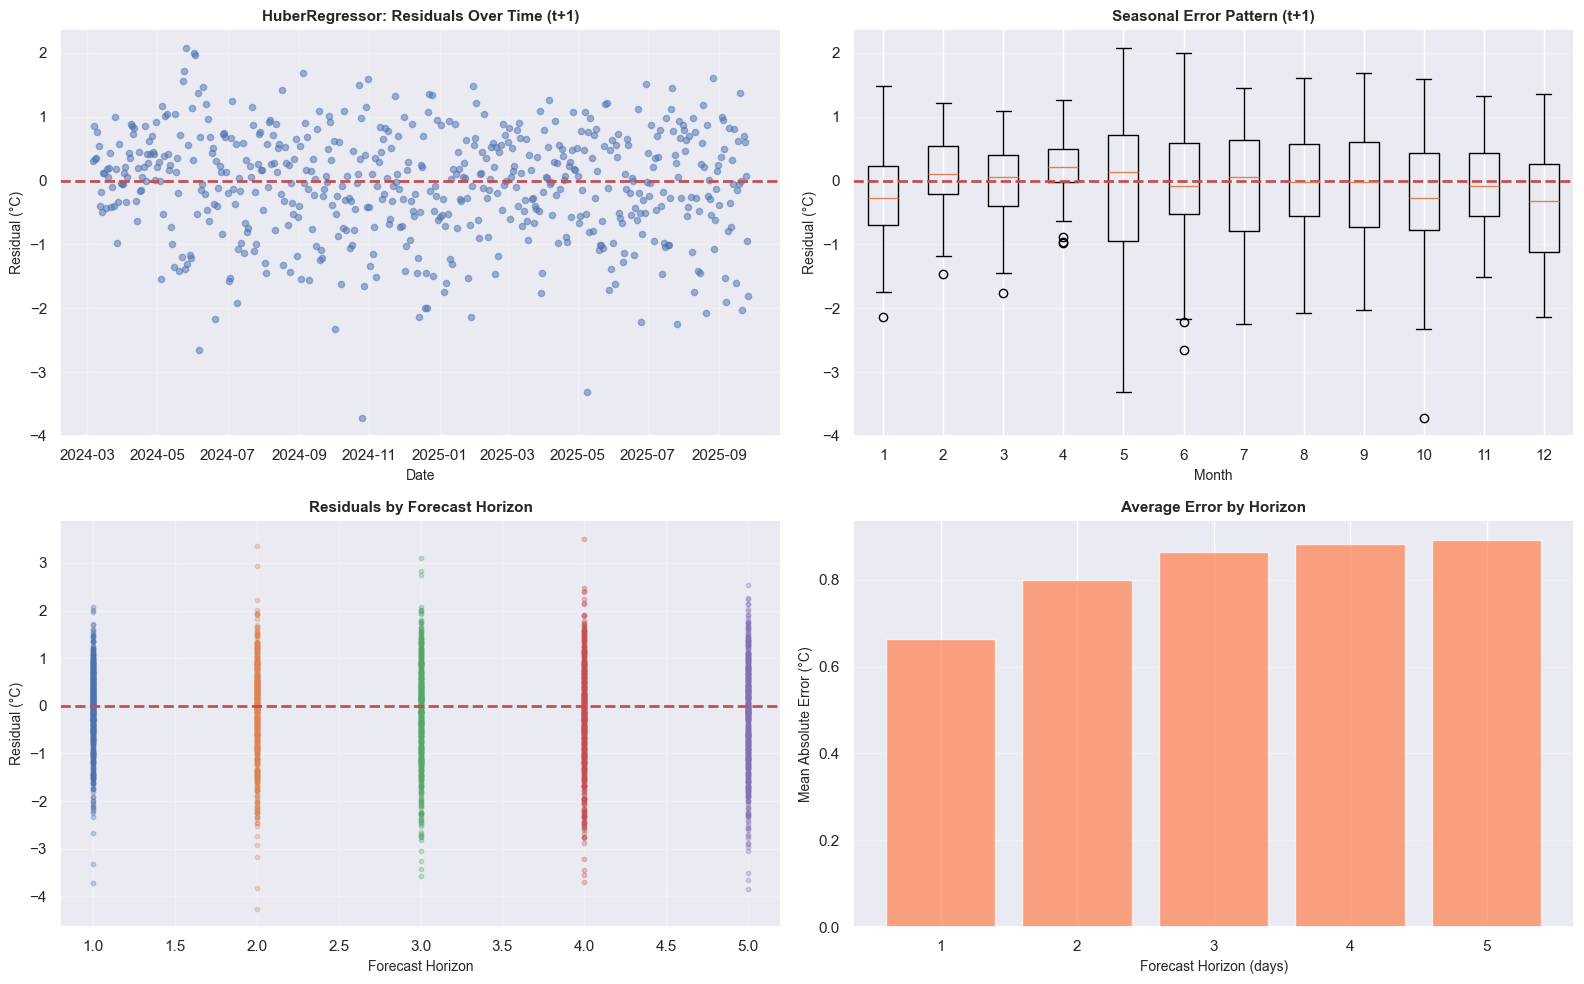


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: -0.0631°C
  Std Dev: 0.8451°C
  Skewness: -0.5390 (left-skewed)
  Kurtosis: 0.5723 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.1351°C
  Std Dev: 1.0138°C
  Skewness: -0.3931 (left-skewed)
  Kurtosis: 0.4683 (heavy-tailed)
  ~ Moderate bias

Horizon t+3:
  Mean: -0.1896°C
  Std Dev: 1.0704°C
  Skewness: -0.2258 (left-skewed)
  Kurtosis: -0.0340 (light-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: -0.2386°C
  Std Dev: 1.0952°C
  Skewness: -0.2175 (left-skewed)
  Kurtosis: 0.0555 (heavy-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.2361°C
  Std Dev: 1.0893°C
  Skewness: -0.2578 (left-skewed)
  Kurtosis: -0.1680 (light-tailed)
  ~ Moderate bias


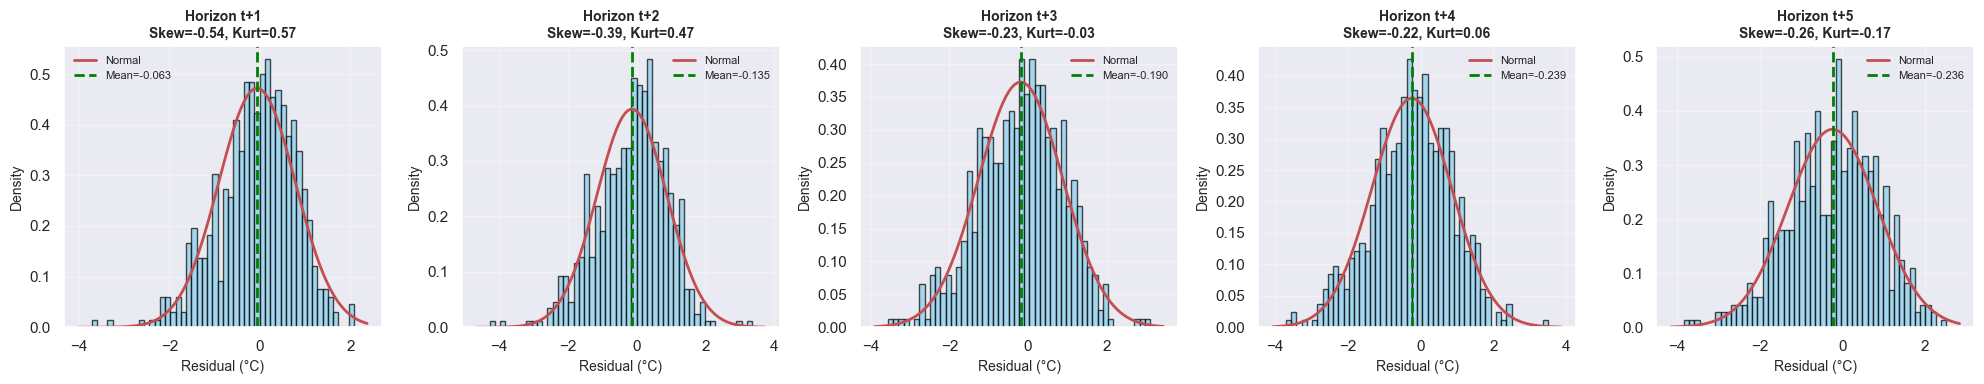


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.718094  0.003978  1.857961           2.503515  0.553978   
1     t+2   1.045931  0.018241  1.575717           2.510182  1.744001   
2     t+3   1.181759  0.035936  1.396116           2.513146  3.040906   
3     t+4   1.256416  0.056908  1.268656           2.513964  4.529393   
4     t+5   1.242385  0.055760  1.145154           2.519957  4.488122   

   Variance %  
0  258.735293  
1  150.652096  
2  118.138767  
3  100.974217  
4   92.173864

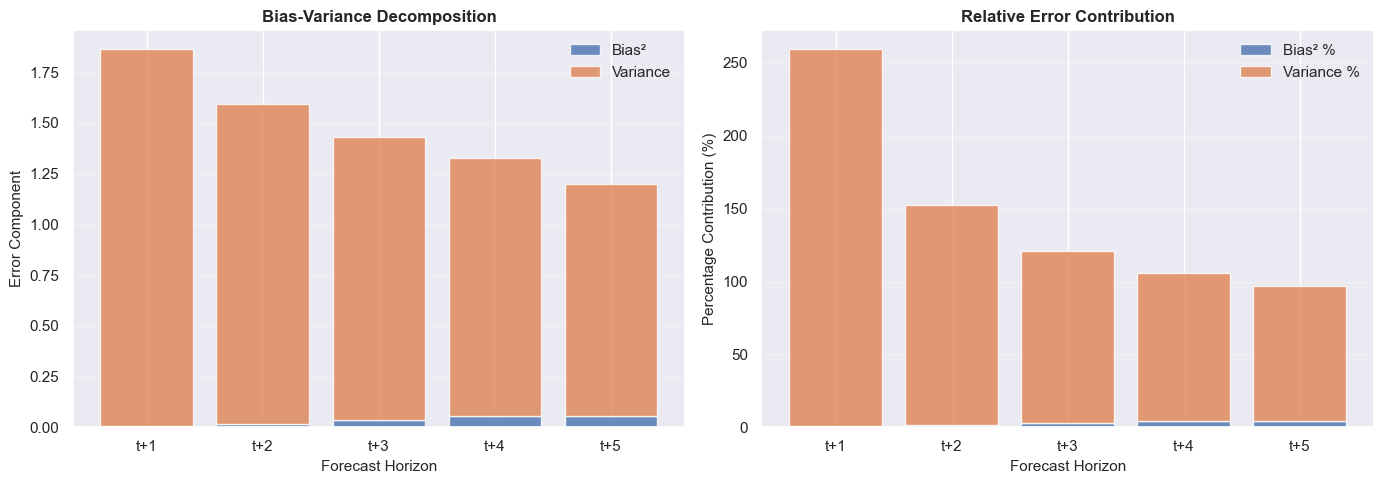


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [26]:
# Analyse Huber Regressor model
analyze_model_comprehensive(
     'HuberRegressor',
     model_results,
     X_train, X_test, y_train, y_test, test_dates
 )

In [27]:
# def huber_optuna_objective(trial):
#     params = {
#         'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
#         'epsilon': trial.suggest_float('epsilon', 1.1, 2.0)
#     }

#     estimator = MultiOutputRegressor(HuberRegressor(max_iter=1000, **params))
#     pipeline = make_pipeline(estimator)

#     fold_metrics = cross_val_evaluate(pipeline, X_train, y_train, tscv)
#     return float(np.mean([fold['RMSE_macro'] for fold in fold_metrics]))


# study_huber = optuna.create_study(direction='minimize', study_name='huber_hyperopt')
# study_huber.optimize(huber_optuna_objective, n_trials=20, timeout=600)

# print("Optimization finished!")
# print(f"Best CV Score (RMSE): {study_huber.best_value:.4f}")
# print("Best Hyperparameters found:")
# for key, value in study_huber.best_trial.params.items():
#     print(f"  - {key}: {value}")

best_huber_params = {
    'alpha': 0.6258952607607242,
    'epsilon': 1.5599425526665442
}

   - HuberRegressor_Optuna test RMSE_macro: 1.0090

OPTUNA HYPERPARAMETER TUNING COMPARISON


Metric  Base Model  Optuna Tuned  Improvement (%)
0  RMSE_macro    1.038544      1.008963         2.848357
1   MAE_macro    0.819906      0.800759         2.335225
2  MAPE_macro    2.888320      2.817025         2.468379
3    R2_macro    0.566693      0.590887        -4.269300


Per-Horizon RMSE Comparison:


Horizon  Base RMSE  Optuna RMSE  Improvement (%)
0     t+1   0.847404     0.820649         3.157240
1     t+2   1.022708     0.990147         3.183715
2     t+3   1.087088     1.060550         2.441156
3     t+4   1.120900     1.089210         2.827131
4     t+5   1.114623     1.084258         2.724309

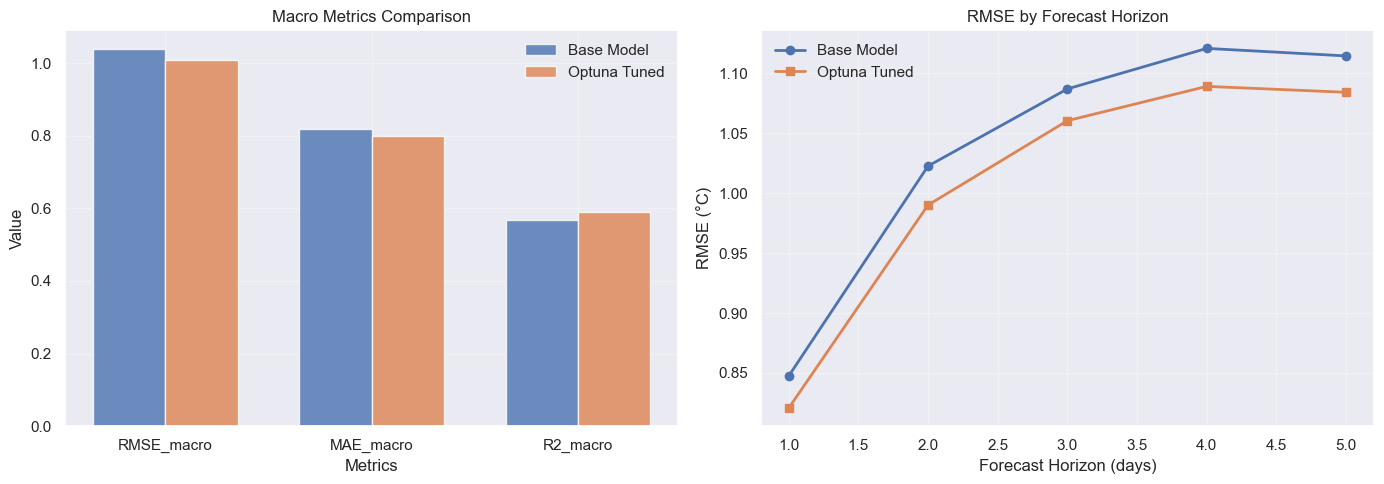


RECOMMENDATION:
~ Consider Optuna tuning (Marginal improvement: 0.85%)



In [28]:
tuned_huber_estimator = MultiOutputRegressor(
     HuberRegressor(max_iter=1000, **best_huber_params)
 )

tuned_huber_pipeline = make_pipeline(tuned_huber_estimator)
cv_fold_metrics = cross_val_evaluate(tuned_huber_pipeline, X_train, y_train, tscv)
full_cv_metrics = aggregate_metrics(cv_fold_metrics)
tuned_huber_pipeline.fit(X_train, y_train)

model_name = 'HuberRegressor_Optuna'
train_pred = tuned_huber_pipeline.predict(X_train)
test_pred = tuned_huber_pipeline.predict(X_test)

model_results[model_name] = {
     'pipeline': tuned_huber_pipeline,
     'cv_metrics': full_cv_metrics,
     'train_metrics': compute_metrics(y_train.values, train_pred),
     'test_metrics': compute_metrics(y_test.values, test_pred),
     'predictions_test': test_pred,
     'predictions_train': train_pred,
     'details': f'Huber tuned with Optuna. Best params: {best_huber_params}'
 }
print(f"   - {model_name} test RMSE_macro: {model_results[model_name]['test_metrics']['RMSE_macro']:.4f}")

compare_optuna_performance(
     base_model_name='HuberRegressor',
     optuna_model_name='HuberRegressor_Optuna',
     model_results=model_results,
     horizons=HORIZONS
 )


COMPREHENSIVE ANALYSIS: HuberRegressor_Optuna

## 2. MODEL SPECIFICATION
Model: HuberRegressor_Optuna
Details: Huber tuned with Optuna. Best params: {'alpha': 0.6258952607607242, 'epsilon': 1.5599425526665442}

Hyperparameters:
  - alpha: 0.6258952607607242
  - epsilon: 1.5599425526665442
  - fit_intercept: True
  - max_iter: 1000
  - tol: 1e-05
  - warm_start: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 1.0090

MAE:
  Value: 0.8008

MAPE:
  Value: 2.8170

R2:
  Value: 0.5909


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.820649  0.647098  2.268745  0.730992
1     t+2  0.990147  0.780252  2.744681  0.609434
2     t+3  1.060550  0.846096  2.975046  0.552447
3     t+4  1.089210  0.858902  3.026248  0.528084
4     t+5  1.084258  0.871447  3.070408  0.533478


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.882162  1.008963    0.126801           No
1   MAE_macro  0.682234  0.800759    0.118525           No
2    R2_macro  0.550103  0.590887    0.040784           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 1.0697
CV MAE (mean): 0.8370
CV R² (mean): 0.2625

[Note: Standard deviation would require storing individual fold results]


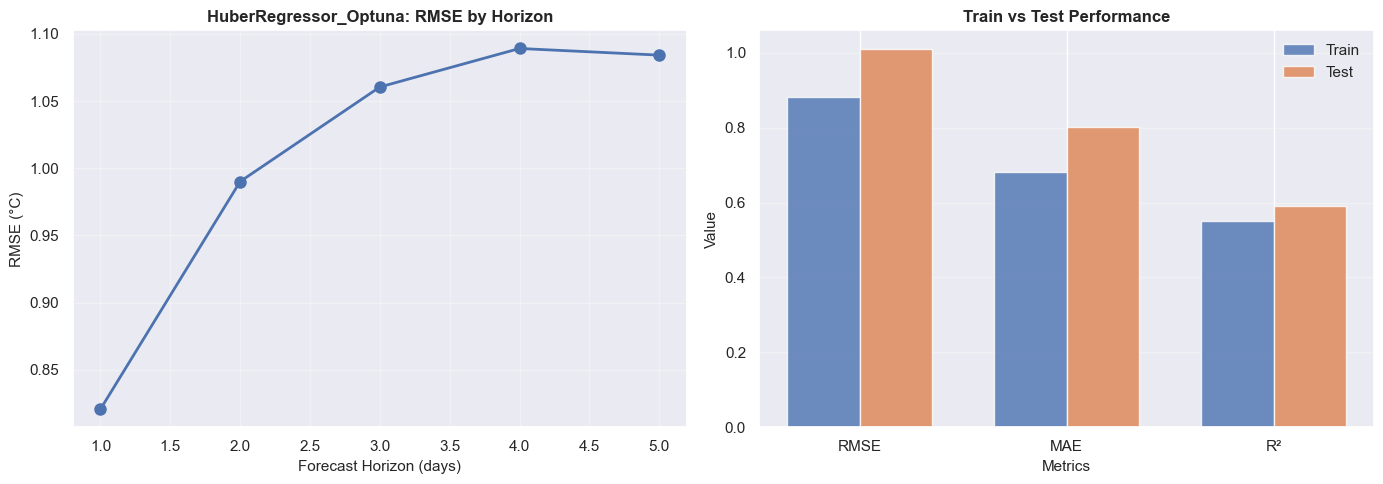


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.118529  0.822631     31
2      0.108750  0.647416     28
3      0.024134  0.586352     57
4      0.171117  0.523371     60
5     -0.068924  1.023418     62
6     -0.040133  0.939524     60
7     -0.039945  0.823816     62
8     -0.021517  0.848183     62
9     -0.092482  0.885128     56
10    -0.110613  0.972127     31
11     0.048194  0.681175     30
12    -0.157435  0.929524     31


High Error Periods (top 10% errors > 1.32°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


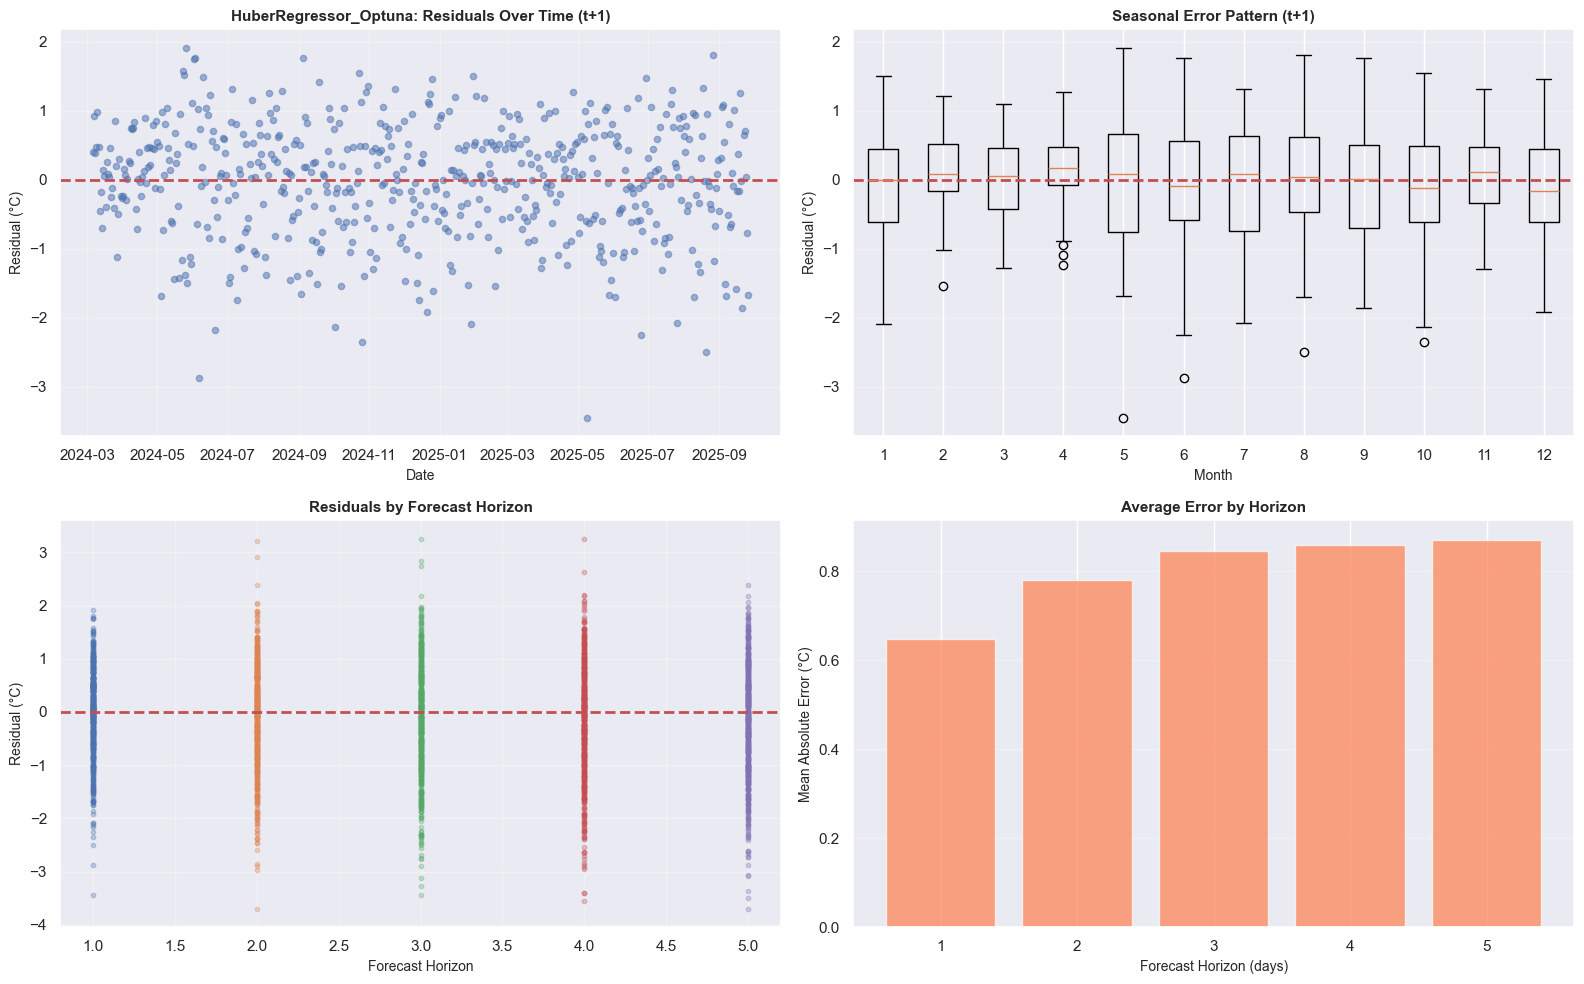


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: -0.0202°C
  Std Dev: 0.8204°C
  Skewness: -0.5043 (left-skewed)
  Kurtosis: 0.3466 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: -0.0855°C
  Std Dev: 0.9864°C
  Skewness: -0.3214 (left-skewed)
  Kurtosis: 0.1933 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.1321°C
  Std Dev: 1.0523°C
  Skewness: -0.2179 (left-skewed)
  Kurtosis: -0.0436 (light-tailed)
  ~ Moderate bias

Horizon t+4:
  Mean: -0.1870°C
  Std Dev: 1.0730°C
  Skewness: -0.2675 (left-skewed)
  Kurtosis: -0.0070 (light-tailed)
  ~ Moderate bias

Horizon t+5:
  Mean: -0.1916°C
  Std Dev: 1.0672°C
  Skewness: -0.3098 (left-skewed)
  Kurtosis: -0.1875 (light-tailed)
  ~ Moderate bias


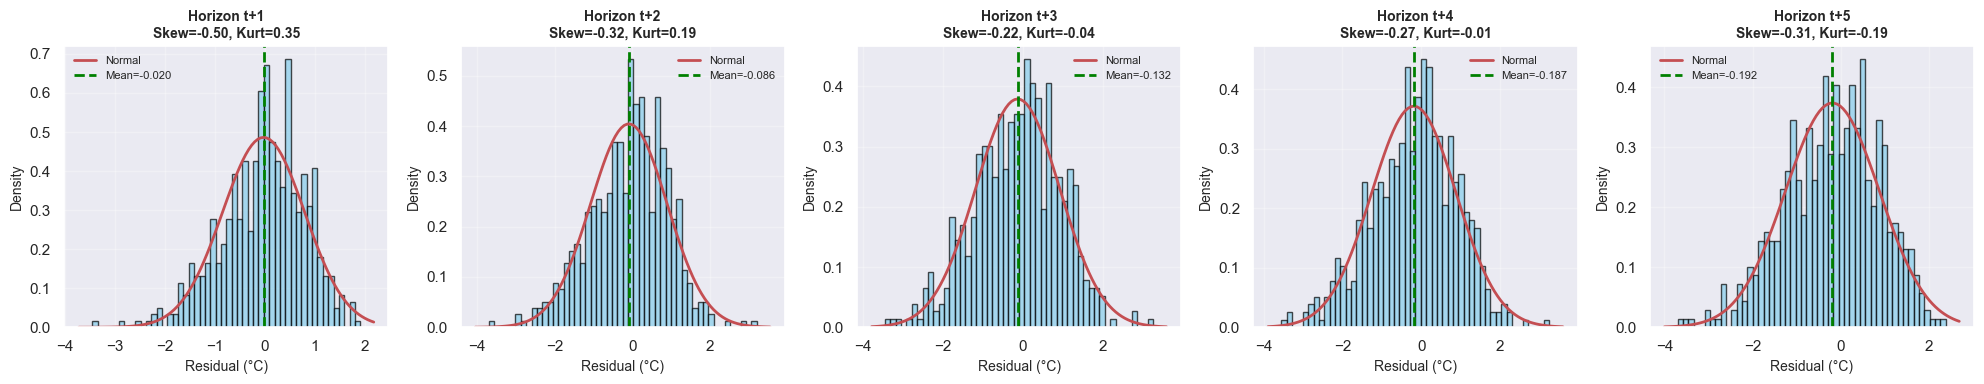


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.673465  0.000409  1.937442           2.503515  0.060665   
1     t+2   0.980392  0.007313  1.547200           2.510182  0.745950   
2     t+3   1.124766  0.017440  1.371568           2.513146  1.550546   
3     t+4   1.186379  0.034953  1.244160           2.513964  2.946179   
4     t+5   1.175614  0.036705  1.154177           2.519957  3.122160   

   Variance %  
0  287.682495  
1  157.814391  
2  121.942492  
3  104.870309  
4   98.176523

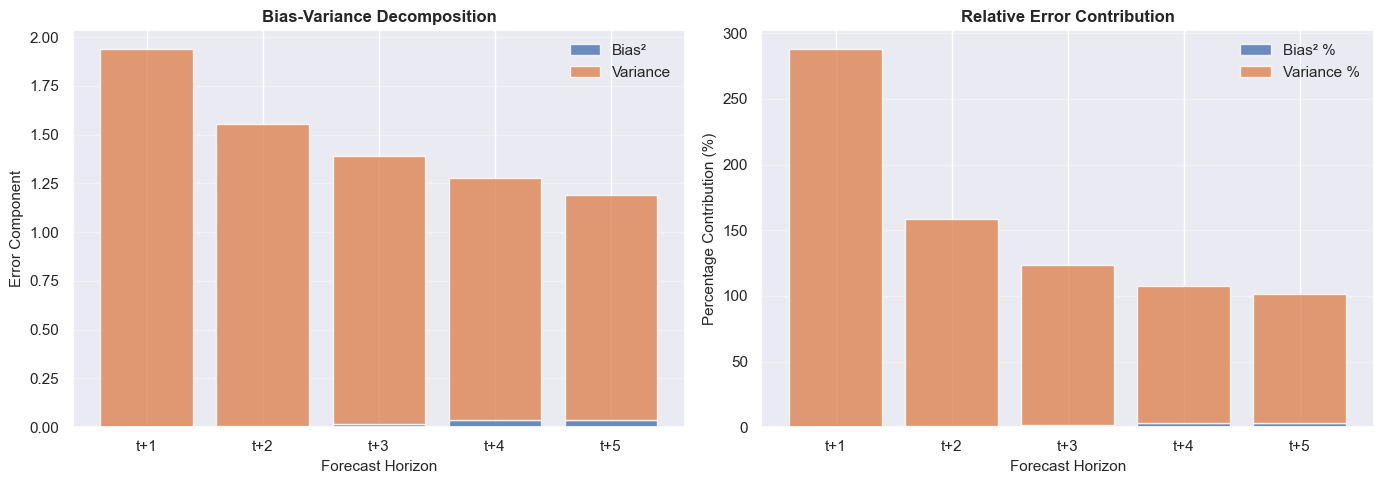


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [29]:
# Analyze the Optuna-tuned Huber Regressor model
analyze_model_comprehensive('HuberRegressor_Optuna', model_results, X_train, X_test, y_train, y_test, test_dates)

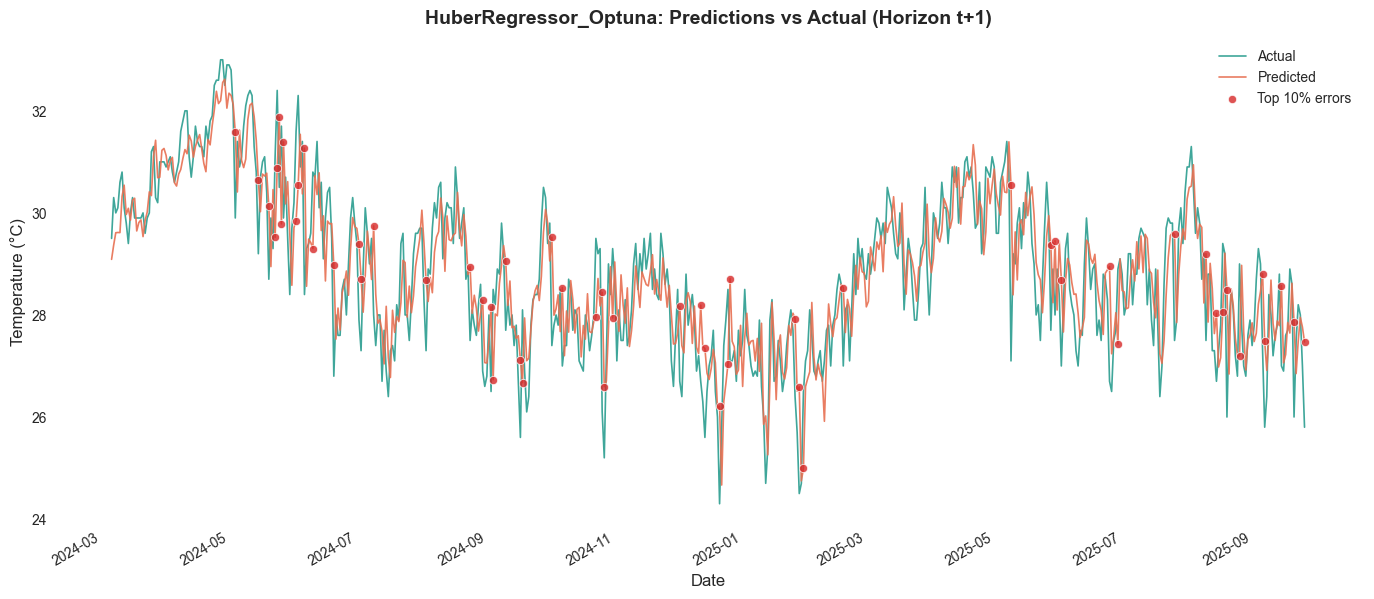

In [30]:
#======================== Visulization between Actual and Predict of Optuna-tuned Huber model ========================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_name = 'HuberRegressor_Optuna'  # đổi theo model bạn muốn
preds = model_results[model_name]['predictions_test']
residuals = y_test.values - preds

# Top 10% lỗi lớn
error_threshold = np.percentile(np.abs(residuals[:, 0]), 90)
high_error_mask = np.abs(residuals[:, 0]) > error_threshold

plt.figure(figsize=(14, 6))

# --- Actual vs Predicted (màu nhẹ, line mảnh) ---
plt.plot(
    test_dates, y_test.values[:, 0],
    color='#2a9d8f', label='Actual', linewidth=1.2, alpha=0.9
)
plt.plot(
    test_dates, preds[:, 0],
    color='#e76f51', label='Predicted', linewidth=1.2, alpha=0.9
)

# --- Scatter: Top 10% errors (nổi bật) ---
plt.scatter(
    test_dates[high_error_mask], preds[:, 0][high_error_mask],
    color='#d62828', s=35, label='Top 10% errors',
    zorder=5, alpha=0.8, edgecolors='white', linewidth=0.6
)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title(f'{model_name}: Predictions vs Actual (Horizon t+1)',
          fontsize=14, fontweight='bold', pad=10)

plt.legend(frameon=False, fontsize=10)
plt.grid(True, alpha=0.15, linestyle='--')
plt.gca().set_facecolor('white')
plt.tight_layout()


plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', length=0) 


for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)

plt.show()


### **6. BayesianRidge**


COMPREHENSIVE ANALYSIS: BayesianRidge

## 2. MODEL SPECIFICATION
Model: BayesianRidge
Details: Sklearn pipeline with preprocessing.

Hyperparameters:
  - alpha_1: 1e-06
  - alpha_2: 1e-06
  - alpha_init: None
  - compute_score: False
  - copy_X: True
  - fit_intercept: True
  - lambda_1: 1e-06
  - lambda_2: 1e-06
  - lambda_init: None
  - max_iter: 300
  - tol: 0.001
  - verbose: False

## 3. QUANTITATIVE PERFORMANCE

### 3a. Performance Metrics
------------------------------------------------------------

Macro Metrics (averaged across all horizons):

RMSE:
  Value: 0.9862

MAE:
  Value: 0.7893

MAPE:
  Value: 2.7672

R2:
  Value: 0.6095


Per-Horizon Metrics:


Horizon      RMSE       MAE      MAPE        R²
0     t+1  0.807599  0.640272  2.242167  0.739480
1     t+2  0.974808  0.776160  2.721159  0.621442
2     t+3  1.040089  0.836248  2.929683  0.569549
3     t+4  1.056896  0.844580  2.961522  0.555670
4     t+5  1.051392  0.849375  2.981270  0.561332


### 3b. Train-Test Comparison
------------------------------------------------------------


Metric     Train      Test  Difference Overfitting?
0  RMSE_macro  0.893464  0.986157    0.092693           No
1   MAE_macro  0.701517  0.789327    0.087810           No
2    R2_macro  0.538452  0.609495    0.071042           No


✓ Good generalization (similar train-test performance)

### 3c. Cross-Validation Performance
------------------------------------------------------------
CV RMSE (mean): 0.9883
CV MAE (mean): 0.7745
CV R² (mean): 0.3804

[Note: Standard deviation would require storing individual fold results]


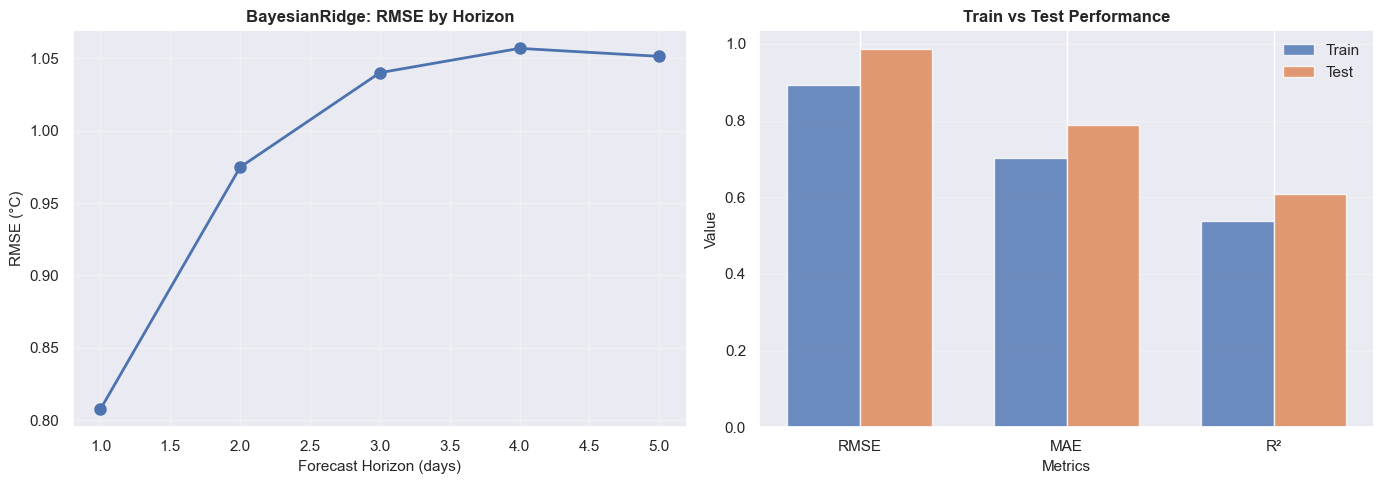


## 4. ERROR ANALYSIS

### 4a. Residual Analysis Over Time
------------------------------------------------------------

Monthly Residual Statistics (Horizon t+1):


mean       std  count
Month                           
1     -0.149523  0.798319     31
2      0.118328  0.634492     28
3      0.064570  0.545430     57
4      0.289096  0.499565     60
5     -0.014854  1.010546     62
6     -0.028462  0.920927     60
7      0.012640  0.813273     62
8      0.032020  0.823811     62
9     -0.027430  0.887347     56
10    -0.086985  0.978159     31
11     0.086895  0.643795     30
12    -0.135089  0.908152     31


High Error Periods (top 10% errors > 1.31°C):
Total occurrences: 57
Date range: 2024-05-04 00:00:00 to 2025-09-26 00:00:00


C:\Users\pc\AppData\Local\Temp\ipykernel_15048\1387267832.py:326: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(monthly_residuals, labels=range(1, 13))


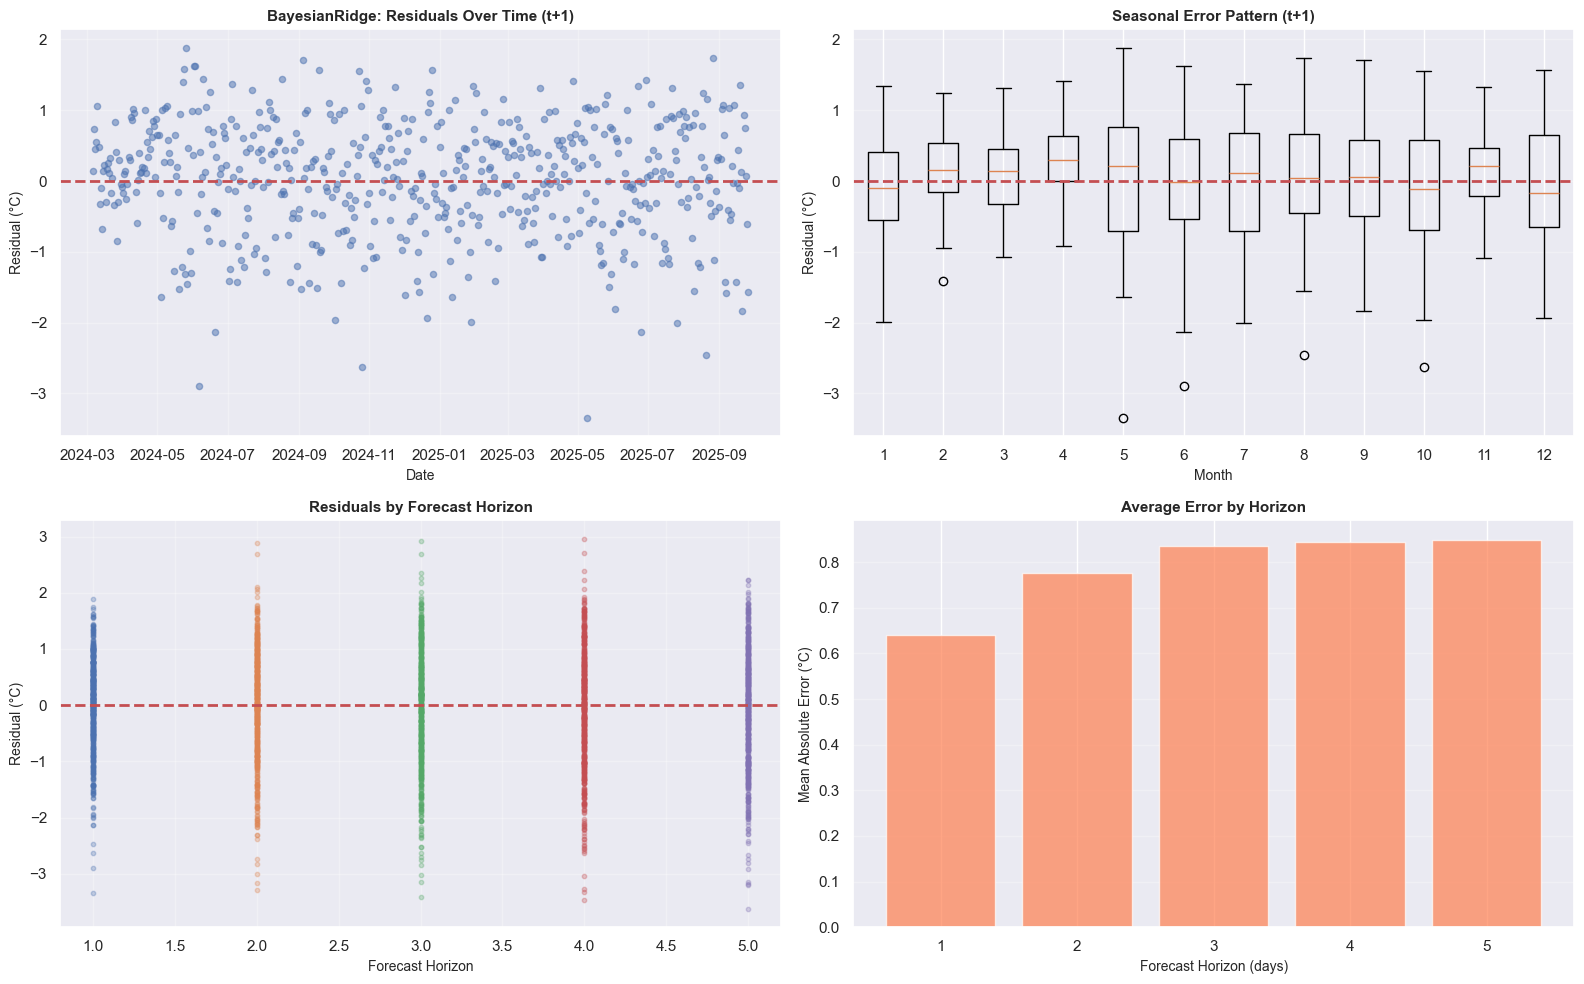


### 4b. Residual Distribution Analysis
------------------------------------------------------------

Horizon t+1:
  Mean: 0.0246°C
  Std Dev: 0.8072°C
  Skewness: -0.5546 (left-skewed)
  Kurtosis: 0.4368 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+2:
  Mean: 0.0067°C
  Std Dev: 0.9748°C
  Skewness: -0.4213 (left-skewed)
  Kurtosis: 0.0961 (heavy-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+3:
  Mean: -0.0297°C
  Std Dev: 1.0397°C
  Skewness: -0.3018 (left-skewed)
  Kurtosis: -0.1038 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+4:
  Mean: -0.0651°C
  Std Dev: 1.0549°C
  Skewness: -0.3067 (left-skewed)
  Kurtosis: -0.0769 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)

Horizon t+5:
  Mean: -0.0972°C
  Std Dev: 1.0469°C
  Skewness: -0.3038 (left-skewed)
  Kurtosis: -0.2173 (light-tailed)
  ✓ Low bias (|mean| < 0.1°C)


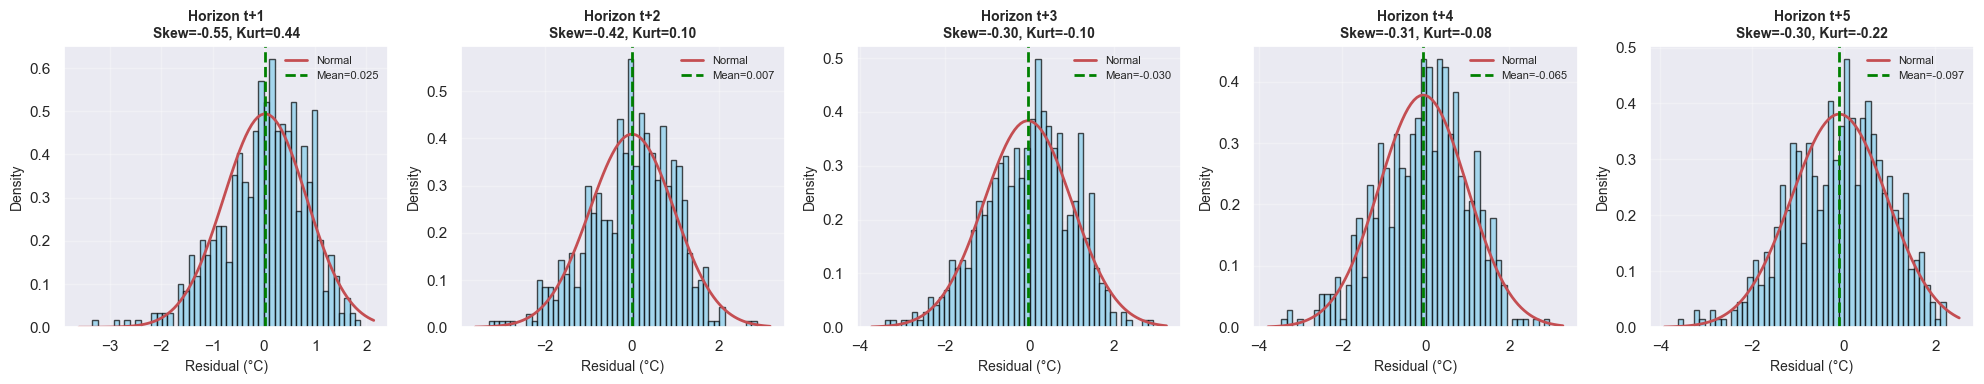


## 5. BIAS-VARIANCE DECOMPOSITION

### Bias-Variance Decomposition
------------------------------------------------------------


Horizon  Total MSE     Bias²  Variance  Irreducible Error   Bias² %  \
0     t+1   0.652216  0.000606  1.834478           2.503515  0.092904   
1     t+2   0.950250  0.000045  1.418257           2.510182  0.004735   
2     t+3   1.081785  0.000883  1.252976           2.513146  0.081633   
3     t+4   1.117030  0.004238  1.148276           2.513964  0.379382   
4     t+5   1.105425  0.009456  1.074280           2.519957  0.855415   

   Variance %  
0  281.268252  
1  149.250896  
2  115.824874  
3  102.797239  
4   97.182538

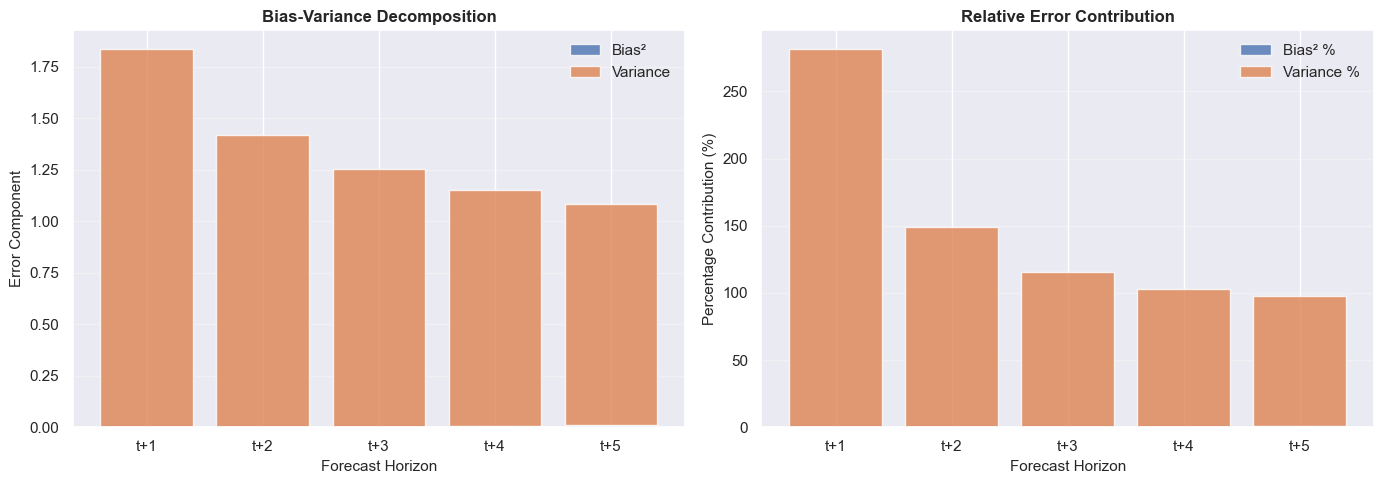


### Interpretation:
⚠ High variance detected - model is overfitting
  Recommendation: Regularization, reduce complexity, or gather more data


In [31]:
# Analyze Bayesian Ridge model
analyze_model_comprehensive('BayesianRidge', model_results, X_train, X_test,
                             y_train, y_test, test_dates, HORIZONS)


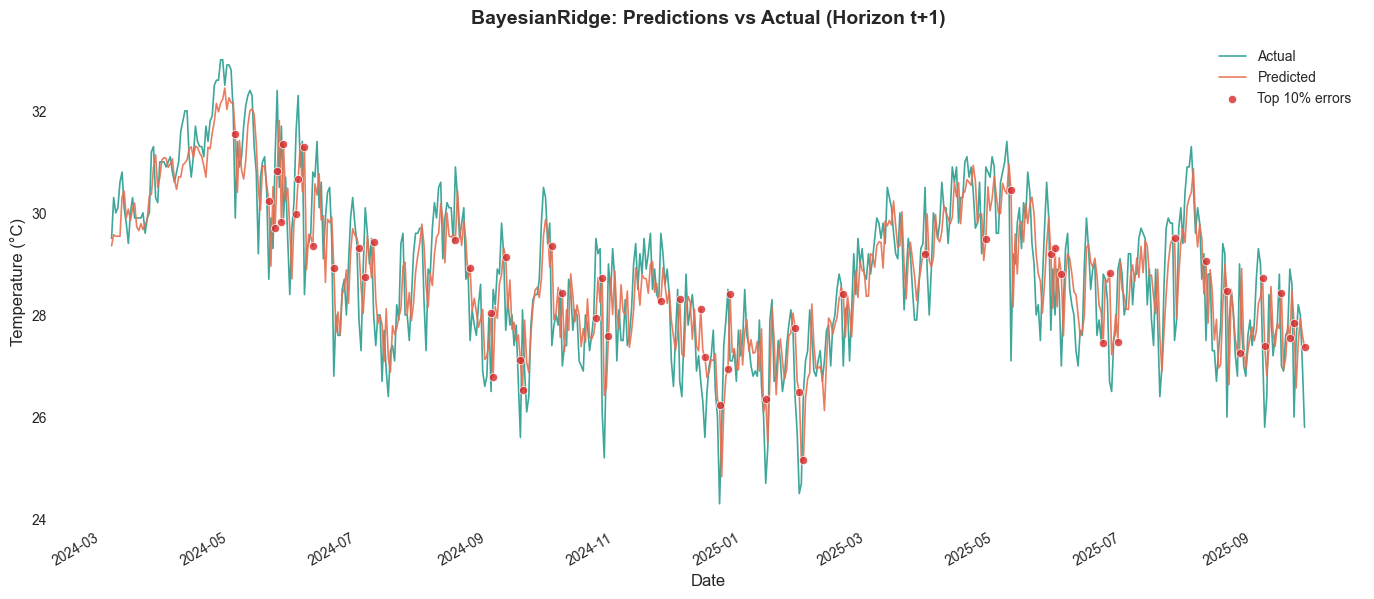

In [32]:
#======================== Visulization between Actual and Predict of Baysian Ridge model ========================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model_name = 'BayesianRidge'  # đổi theo model bạn muốn
preds = model_results[model_name]['predictions_test']
residuals = y_test.values - preds

# Top 10% lỗi lớn
error_threshold = np.percentile(np.abs(residuals[:, 0]), 90)
high_error_mask = np.abs(residuals[:, 0]) > error_threshold

plt.figure(figsize=(14, 6))

# --- Actual vs Predicted (màu nhẹ, line mảnh) ---
plt.plot(
    test_dates, y_test.values[:, 0],
    color='#2a9d8f', label='Actual', linewidth=1.2, alpha=0.9
)
plt.plot(
    test_dates, preds[:, 0],
    color='#e76f51', label='Predicted', linewidth=1.2, alpha=0.9
)

# --- Scatter: Top 10% errors (nổi bật) ---
plt.scatter(
    test_dates[high_error_mask], preds[:, 0][high_error_mask],
    color='#d62828', s=35, label='Top 10% errors',
    zorder=5, alpha=0.8, edgecolors='white', linewidth=0.6
)


plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title(f'{model_name}: Predictions vs Actual (Horizon t+1)',
          fontsize=14, fontweight='bold', pad=10)

plt.legend(frameon=False, fontsize=10)
plt.grid(True, alpha=0.15, linestyle='--')
plt.gca().set_facecolor('white')
plt.tight_layout()


plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', length=0) 


for spine in plt.gca().spines.values():
    spine.set_alpha(0.3)

plt.show()


### **7. Ensemble model**

#### **a. Ensemble of BayesianRidge and HGB**

In [33]:
# --- Ensemble of BayesianRidge and HistGradientBoosting_Optuna ---

ensemble_sources = ['BayesianRidge', 'HistGradientBoosting_Optuna']
available_ensemble = [name for name in ensemble_sources if name in model_results]

if len(available_ensemble) == 2:
    ensemble_test_preds = np.mean([model_results[name]['predictions_test'] for name in available_ensemble], axis=0)
    ensemble_train_preds = np.mean([model_results[name]['predictions_train'] for name in available_ensemble], axis=0)
    model_results['BayesianRidge_HGB_Ensemble'] = {
        'train_metrics': compute_metrics(y_train.values, ensemble_train_preds),
        'test_metrics': compute_metrics(y_test.values, ensemble_test_preds),
        'cv_metrics': None,
        'predictions_train': ensemble_train_preds,
        'predictions_test': ensemble_test_preds,
        'details': f'Simple average ensemble of: {available_ensemble}'
    }
    print(f"BayesianRidge + HistGradientBoosting_Optuna ensemble test RMSE_macro: {model_results['BayesianRidge_HGB_Ensemble']['test_metrics']}")
else:
    print('Ensemble skipped: required models missing.')

BayesianRidge + HistGradientBoosting_Optuna ensemble test RMSE_macro: {'RMSE_h1': 0.7894331877262015, 'MAE_h1': 0.625325729068468, 'MAPE_h1': 2.188768036341847, 'R2_h1': 0.7510680879128808, 'RMSE_h2': 0.9511491979334594, 'MAE_h2': 0.7584694658139411, 'MAPE_h2': 2.660995111280233, 'R2_h2': 0.6395939776543937, 'RMSE_h3': 1.0188843967168952, 'MAE_h3': 0.8143221752627396, 'MAPE_h3': 2.856546991551746, 'R2_h3': 0.5869219410274056, 'RMSE_h4': 1.037576747152848, 'MAE_h4': 0.8264198109446582, 'MAPE_h4': 2.902868824178266, 'R2_h4': 0.5717657094293175, 'RMSE_h5': 1.0371703474318092, 'MAE_h5': 0.830606596860335, 'MAPE_h5': 2.920854613922795, 'R2_h5': 0.5731187029715084, 'RMSE_macro': 0.9668427753922426, 'MAE_macro': 0.7710287555900284, 'MAPE_macro': 2.706006715454977, 'R2_macro': 0.6244936837991013}


#### **b. Apply variance-corrected**

In [34]:
# --- Variance-corrected Ensemble of BayesianRidge and HistGradientBoosting_Optuna ---

ensemble_sources = ['BayesianRidge', 'HistGradientBoosting_Optuna']
available_ensemble = [name for name in ensemble_sources if name in model_results]

def apply_variance_correction(predictions, actual_train, method='linear'):
    """
    Apply variance correction to predictions using ONLY training set statistics.

    Parameters:
    -----------
    predictions : array-like
        Predictions to correct (train or test)
    actual_train : array-like
        Training set actuals (for computing target variance)
    method : str
        'linear' or 'adaptive'
    """
    corrected_preds = predictions.copy()
    for horizon_idx in range(predictions.shape[1]):
        train_var = np.var(actual_train[:, horizon_idx])
        pred_var = np.var(predictions[:, horizon_idx])

        if pred_var > 0:
            if method == 'linear':
                scale_factor = np.sqrt(train_var / pred_var)
                pred_mean = np.mean(predictions[:, horizon_idx])
                corrected_preds[:, horizon_idx] = pred_mean + scale_factor * (predictions[:, horizon_idx] - pred_mean)
            elif method == 'adaptive':
                pred_std = np.std(predictions[:, horizon_idx])
                actual_std = np.std(actual_train[:, horizon_idx])
                pred_mean = np.mean(predictions[:, horizon_idx])
                distances = np.abs(predictions[:, horizon_idx] - pred_mean)
                max_distance = np.max(distances) if np.max(distances) > 0 else 1
                scale_factors = 1 + (actual_std / pred_std - 1) * (1 - distances / max_distance) * 0.8
                corrected_preds[:, horizon_idx] = pred_mean + scale_factors * (predictions[:, horizon_idx] - pred_mean)
    return corrected_preds


In [35]:
if len(available_ensemble) == 2:
    ensemble_test_preds = np.mean([model_results[name]['predictions_test'] for name in available_ensemble], axis=0)
    ensemble_train_preds = np.mean([model_results[name]['predictions_train'] for name in available_ensemble], axis=0)

    # Apply variance correction using ONLY training statistics
    ensemble_test_preds_corr = apply_variance_correction(
        ensemble_test_preds, y_train.values, method='adaptive'
    )
    ensemble_train_preds_corr = apply_variance_correction(
        ensemble_train_preds, y_train.values, method='adaptive'
    )

    model_results['BayesianRidge_HGB_Ensemble_VarCorr'] = {
        'train_metrics': compute_metrics(y_train.values, ensemble_train_preds_corr),
        'test_metrics': compute_metrics(y_test.values, ensemble_test_preds_corr),
        'cv_metrics': None,
        'predictions_train': ensemble_train_preds_corr,
        'predictions_test': ensemble_test_preds_corr,
        'details': f'Variance-corrected average ensemble of: {available_ensemble}'
    }
    print(f"Variance-corrected ensemble test RMSE_macro: {model_results['BayesianRidge_HGB_Ensemble_VarCorr']['test_metrics']}")
else:
    print('Ensemble skipped: required models missing.')

Variance-corrected ensemble test RMSE_macro: {'RMSE_h1': 0.7893400352640743, 'MAE_h1': 0.6252417716439967, 'MAPE_h1': 2.1884823738034678, 'R2_h1': 0.751126831965587, 'RMSE_h2': 0.9433758515006639, 'MAE_h2': 0.7486982170448362, 'MAPE_h2': 2.6263783560176437, 'R2_h2': 0.6454608024992765, 'RMSE_h3': 1.005804574188189, 'MAE_h3': 0.8023875045045586, 'MAPE_h3': 2.8127998435832717, 'R2_h3': 0.5974595595691636, 'RMSE_h4': 1.0223748940906636, 'MAE_h4': 0.8108537225584643, 'MAPE_h4': 2.84604633721523, 'R2_h4': 0.5842221664843004, 'RMSE_h5': 1.0145716533191773, 'MAE_h5': 0.8116906796525482, 'MAPE_h5': 2.8517200219155745, 'R2_h5': 0.5915185001751411, 'RMSE_macro': 0.9550934016725536, 'MAE_macro': 0.7597743790808809, 'MAPE_macro': 2.6650853865070374, 'R2_macro': 0.6339575721386937}


#### **c. Residual Booster**

In [64]:
# Residual booster

def fit_residual_booster(X_train, y_train, y_pred_train):
    """Fit a small HGB regressor on residuals per horizon using preprocessed features."""
    y_train = np.asarray(y_train)
    y_pred_train = np.asarray(y_pred_train)
    n_samples, n_horizons = y_pred_train.shape
    boosters = []
    res_train = y_train - y_pred_train

    # FIX: Use the preprocessor to transform X_train first
    preprocessor = build_preprocessor()
    X_train_transformed = preprocessor.fit_transform(X_train)
    # Convert to dense array if sparse
    if hasattr(X_train_transformed, 'toarray'):
        X_train_transformed = X_train_transformed.toarray()

    for h in range(n_horizons):
        booster = HistGradientBoostingRegressor(max_depth=3, max_iter=100, learning_rate=0.05)
        booster.fit(X_train_transformed, res_train[:, h])
        boosters.append(booster)
    return boosters, preprocessor

def apply_residual_booster(X_test, y_pred_test, boosters, preprocessor):
    """Apply residual booster to test predictions using preprocessed features."""
    y_pred_test = np.asarray(y_pred_test)
    n_samples, n_horizons = y_pred_test.shape
    y_final = y_pred_test.copy()

    # FIX: Transform X_test using the same preprocessor
    X_test_transformed = preprocessor.transform(X_test)
    # Convert to dense array if sparse
    if hasattr(X_test_transformed, 'toarray'):
        X_test_transformed = X_test_transformed.toarray()

    for h in range(n_horizons):
        res_hat_test = boosters[h].predict(X_test_transformed)
        y_final[:, h] += res_hat_test
    return y_final

# still use the bayesian + hgb ensemble as base
if len(available_ensemble) == 2:
    best_predictions = np.mean([model_results[name]['predictions_test'] for name in available_ensemble], axis=0)
    best_train_predictions = np.mean([model_results[name]['predictions_train'] for name in available_ensemble], axis=0)
else:
    raise ValueError("Required ensemble models not found.")

boosters, booster_preprocessor = fit_residual_booster(X_train, y_train.values, best_train_predictions)

residual_boosted_preds = apply_residual_booster(X_test, best_predictions, boosters, booster_preprocessor)


model_results['ResidualBooster_Ensemble'] = {
    'test_metrics': compute_metrics(y_test.values, residual_boosted_preds),
    'predictions_test': residual_boosted_preds,
    'details': 'Residual booster (HGB) per horizon'
}

print(f"Residual Booster Ensemble test RMSE_macro: {model_results['ResidualBooster_Ensemble']['test_metrics']}")

Residual Booster Ensemble test RMSE_macro: {'RMSE_h1': 0.7898341732029275, 'MAE_h1': 0.6248353717172431, 'MAPE_h1': 2.188140679999772, 'R2_h1': 0.7508151382425589, 'RMSE_h2': 0.9465503183073197, 'MAE_h2': 0.755647952229681, 'MAPE_h2': 2.651586479310019, 'R2_h2': 0.6430707338437682, 'RMSE_h3': 1.0197197433948282, 'MAE_h3': 0.8138315554871828, 'MAPE_h3': 2.855259159819402, 'R2_h3': 0.5862443276731678, 'RMSE_h4': 1.0429046116665655, 'MAE_h4': 0.8261084274610423, 'MAPE_h4': 2.9017207702788284, 'R2_h4': 0.5673565278872539, 'RMSE_h5': 1.0396553099632582, 'MAE_h5': 0.8308920610676536, 'MAPE_h5': 2.922385553928388, 'R2_h5': 0.5710707176999158, 'RMSE_macro': 0.9677328313069798, 'MAE_macro': 0.7702630735925605, 'MAPE_macro': 2.7038185286672816, 'R2_macro': 0.6237114890693329}


#### **d. Final Model**

In [37]:
#best model horizon 1: 'ResidualBooster_Ensemble', horizon 2-5: 'BayesianRidge_HGB_Ensemble_VarCorr'
# Final combined predictions
final_test_preds = residual_boosted_preds.copy()
best_varcorr_preds = model_results['BayesianRidge_HGB_Ensemble_VarCorr']['predictions_test']
final_test_preds[:, 1:] = best_varcorr_preds[:, 1:]
final_test_metrics = compute_metrics(y_test.values, final_test_preds)
model_results['Final_Combined_Model'] = {
    'test_metrics': final_test_metrics,
    'predictions_test': final_test_preds,
    'details': 'Horizon 1 from ResidualBooster_Ensemble, Horizons 2-5 from BayesianRidge_HGB_Ensemble_VarCorr'
}
print(f"Final combined model test RMSE_macro: {model_results['Final_Combined_Model']['test_metrics']}")

Final combined model test RMSE_macro: {'RMSE_h1': 0.7828575528510965, 'MAE_h1': 0.6170053471076784, 'MAPE_h1': 2.161101878761072, 'R2_h1': 0.7551978055803391, 'RMSE_h2': 0.9433758515006639, 'MAE_h2': 0.7486982170448362, 'MAPE_h2': 2.6263783560176437, 'R2_h2': 0.6454608024992765, 'RMSE_h3': 1.005804574188189, 'MAE_h3': 0.8023875045045586, 'MAPE_h3': 2.8127998435832717, 'R2_h3': 0.5974595595691636, 'RMSE_h4': 1.0223748940906636, 'MAE_h4': 0.8108537225584643, 'MAPE_h4': 2.84604633721523, 'R2_h4': 0.5842221664843004, 'RMSE_h5': 1.0145716533191773, 'MAE_h5': 0.8116906796525482, 'MAPE_h5': 2.8517200219155745, 'R2_h5': 0.5915185001751411, 'RMSE_macro': 0.9537969051899582, 'MAE_macro': 0.7581270941736171, 'MAPE_macro': 2.659609287498559, 'R2_macro': 0.6347717668616442}


## Final Results

Model  RMSE_macro  MAE_macro  MAPE_macro  \
12                Final_Combined_Model    0.953797   0.758127    2.659609   
10  BayesianRidge_HGB_Ensemble_VarCorr    0.955093   0.759774    2.665085   
9           BayesianRidge_HGB_Ensemble    0.966843   0.771029    2.706007   
7          HistGradientBoosting_Optuna    0.981036   0.774688    2.720531   
11            ResidualBooster_Ensemble    0.981676   0.776454    2.734479   
5                        BayesianRidge    0.986157   0.789327    2.767160   
1                     LinearRegression    0.999279   0.799406    2.805669   
6              RandomForest_ManualTune    1.002826   0.806842    2.805788   
8                HuberRegressor_Optuna    1.008963   0.800759    2.817025   
2                RandomForestRegressor    1.015429   0.813251    2.830774   
3                 HistGradientBoosting    1.029049   0.816302    2.864193   
4                       HuberRegressor    1.038544   0.819906    2.888320   
0                     NaivePersistence    1.209535   0.956175    3.352939   

    R2_macro  
12  0.634772  
10  0.633958  
9   0.624494  
7   0.613334  
11  0.611866  
5   0.609495  
1   0.598908  
6   0.596687  
8   0.590887  
2   0.586011  
3   0.574061  
4   0.566693  
0   0.406474

RMSE_h1   RMSE_h2   RMSE_h3   RMSE_h4  \
Model                                                                        
Final_Combined_Model                0.782858  0.943376  1.005805  1.022375   
BayesianRidge_HGB_Ensemble_VarCorr  0.789340  0.943376  1.005805  1.022375   
BayesianRidge_HGB_Ensemble          0.789433  0.951149  1.018884  1.037577   
HistGradientBoosting_Optuna         0.800919  0.961630  1.033868  1.049166   
ResidualBooster_Ensemble            0.782858  0.950979  1.036318  1.063427   
BayesianRidge                       0.807599  0.974808  1.040089  1.056896   
LinearRegression                    0.817106  0.982618  1.049982  1.073343   
RandomForest_ManualTune             0.833822  0.994968  1.051259  1.068337   
HuberRegressor_Optuna               0.820649  0.990147  1.060550  1.089210   
RandomForestRegressor               0.830487  1.011043  1.072228  1.085211   
HistGradientBoosting                0.833782  0.992950  1.096626  1.112222   
HuberRegressor                      0.847404  1.022708  1.087088  1.120900   
NaivePersistence                    0.892523  1.176532  1.296114  1.349386   

                                     RMSE_h5  
Model                                         
Final_Combined_Model                1.014572  
BayesianRidge_HGB_Ensemble_VarCorr  1.014572  
BayesianRidge_HGB_Ensemble          1.037170  
HistGradientBoosting_Optuna         1.059596  
ResidualBooster_Ensemble            1.074797  
BayesianRidge                       1.051392  
LinearRegression                    1.073345  
RandomForest_ManualTune             1.065746  
HuberRegressor_Optuna               1.084258  
RandomForestRegressor               1.078175  
HistGradientBoosting                1.109665  
HuberRegressor                      1.114623  
NaivePersistence                    1.333121

Best model on test: Final_Combined_Model


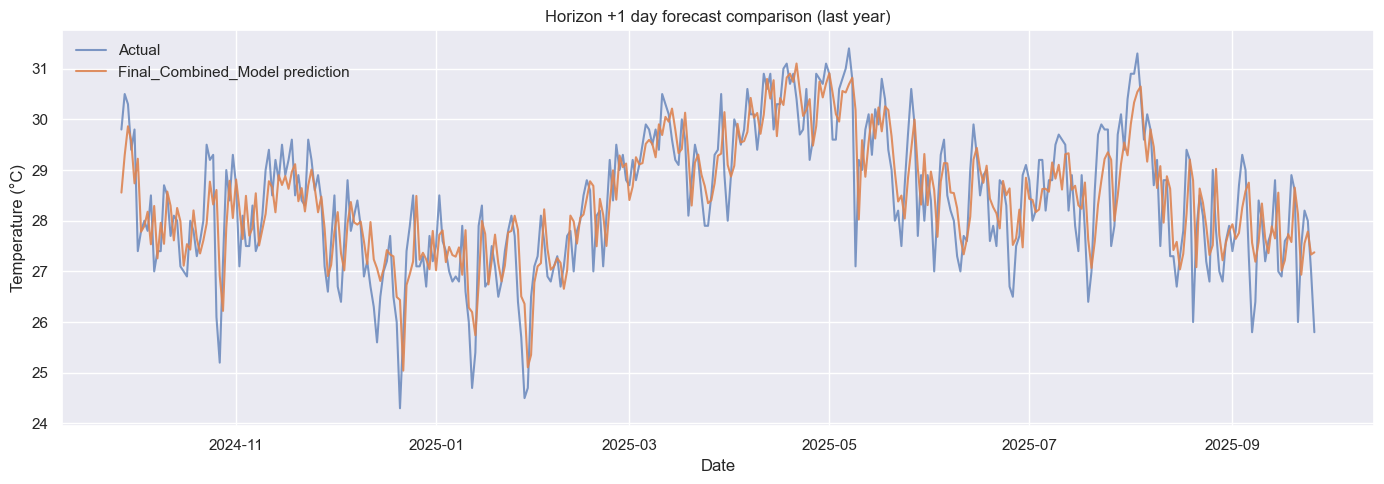

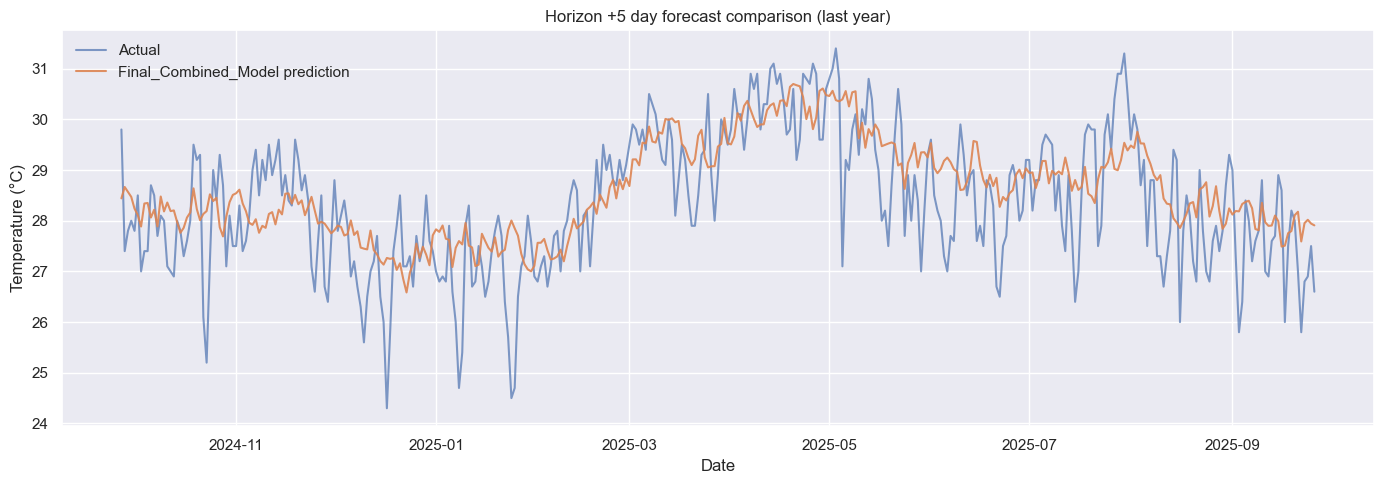

In [38]:
summary_rows = []
for name, res in model_results.items():
    test_metrics = res['test_metrics']
    summary_rows.append({
        'Model': name,
        'RMSE_macro': test_metrics['RMSE_macro'],
        'MAE_macro': test_metrics['MAE_macro'],
        'MAPE_macro': test_metrics['MAPE_macro'],
        'R2_macro': test_metrics['R2_macro']
    })
summary_df = pd.DataFrame(summary_rows).sort_values('RMSE_macro')
display(summary_df)

horizon_metrics = []
for name, res in model_results.items():
    row = {'Model': name}
    for horizon in HORIZONS:
        row[f'RMSE_h{horizon}'] = res['test_metrics'][f'RMSE_h{horizon}']
    horizon_metrics.append(row)
horizon_df = pd.DataFrame(horizon_metrics).set_index('Model').loc[summary_df['Model']]
display(horizon_df)

best_model_name = summary_df.iloc[0]['Model']
best_predictions = model_results[best_model_name]['predictions_test']
print(f'Best model on test: {best_model_name}')

slice_idx = max(0, len(test_dates) - 365)
fig, ax = plt.subplots(figsize=(14, 5))
plot_horizon = 1
ax.plot(test_dates.iloc[slice_idx:], y_test[f'target_temp_t+{plot_horizon}'].iloc[slice_idx:], label='Actual', alpha=0.7)
ax.plot(test_dates.iloc[slice_idx:], best_predictions[slice_idx:, plot_horizon - 1], label=f'{best_model_name} prediction', alpha=0.9)
ax.set_title(f'Horizon +{plot_horizon} day forecast comparison (last year)')
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(figsize=(14, 5))
plot_horizon = 5
ax.plot(test_dates.iloc[slice_idx:], y_test[f'target_temp_t+{plot_horizon}'].iloc[slice_idx:], label='Actual', alpha=0.7)
ax.plot(test_dates.iloc[slice_idx:], best_predictions[slice_idx:, plot_horizon - 1], label=f'{best_model_name} prediction', alpha=0.9)
ax.set_title(f'Horizon +{plot_horizon} day forecast comparison (last year)')
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()

if 'Seq2Seq_LSTM' in model_results:
    history_df = pd.DataFrame(model_results['Seq2Seq_LSTM']['training_history'])
    display(history_df.tail())

## <span style='color:blue'> Step 8 · Hourly Data


## 8.1. Load and Preprocess Hourly Data


In [39]:
print("=== Loading Hourly Weather Data ===")
DATA_PATH_HOURLY = "https://raw.githubusercontent.com/hoducmanh222/temp_holder/main/weather_hcm_hourly.csv"
df_raw_hourly = pd.read_csv(DATA_PATH_HOURLY)

print("--- Basic Info (before processing) ---")
print(f"Dataset shape: {df_raw_hourly.shape}")
print(f"Sampling period: {df_raw_hourly['datetime'].min()} to {df_raw_hourly['datetime'].max()}")
print(f"Total hours: {df_raw_hourly.shape[0]}")

# Convert datetime and sort
df_raw_hourly['datetime'] = pd.to_datetime(df_raw_hourly['datetime'])
df_raw_hourly = df_raw_hourly.sort_values('datetime').reset_index(drop=True)

# Check for missing timestamps
full_time_range = pd.date_range(
    start=df_raw_hourly['datetime'].min(),
    end=df_raw_hourly['datetime'].max(),
    freq='h'
)

missing_timestamps = full_time_range.difference(df_raw_hourly['datetime'])
if len(missing_timestamps) > 0:
    print(f"\nFound {len(missing_timestamps)} missing hourly timestamps!")
    print("First 10 missing timestamps:", missing_timestamps[:10])
else:
    print("\nData is continuous, no missing hours found.")

display(df_raw_hourly.head())


=== Loading Hourly Weather Data ===
--- Basic Info (before processing) ---
Dataset shape: (94248, 26)
Sampling period: 2015-01-01 00:00:00 to 2025-10-01 23:00:00
Total hours: 94248

Data is continuous, no missing hours found.


name           address        resolvedAddress  latitude  \
0  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
1  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
2  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
3  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   
4  Hồ Chí Minh, Việt Nam  Hồ Chí Minh city  Hồ Chí Minh, Việt Nam    10.776   

   longitude            datetime  temp  feelslike   dew  humidity  precip  \
0    106.701 2015-01-01 00:00:00  24.6       24.6  19.0     71.06     0.0   
1    106.701 2015-01-01 01:00:00  24.5       24.5  20.2     77.06     0.0   
2    106.701 2015-01-01 02:00:00  24.0       24.0  20.0     78.35     0.0   
3    106.701 2015-01-01 03:00:00  24.0       24.0  20.0     78.35     0.0   
4    106.701 2015-01-01 04:00:00  24.0       24.0  20.7     81.94     0.0   

   precipprob preciptype  windgust  windspeed  winddir  sealevelpressure  \
0         0.0        NaN       9.4        3.6    240.0            1012.0   
1         0.0        NaN       9.0        3.6    294.0            1012.2   
2         0.0        NaN       6.5        4.7    324.0            1012.0   
3         0.0        NaN       6.8        7.0    334.0            1012.0   
4         0.0        NaN       9.0        6.7    336.0            1012.1   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  severerisk  \
0        50.0         7.0             0.0          0.0      0.0         NaN   
1        53.7         8.2             0.0          0.0      0.0         NaN   
2        50.0         7.0             0.0          0.0      0.0         NaN   
3        50.0         6.0             0.0          0.0      0.0         NaN   
4        53.7         7.3             0.0          0.0      0.0         NaN   

         conditions                 icon source  
0  Partially cloudy  partly-cloudy-night    obs  
1  Partially cloudy  partly-cloudy-night    obs  
2  Partially cloudy  partly-cloudy-night    obs  
3  Partially cloudy  partly-cloudy-night    obs  
4  Partially cloudy  partly-cloudy-night    obs

=== Exploratory Data Analysis ===


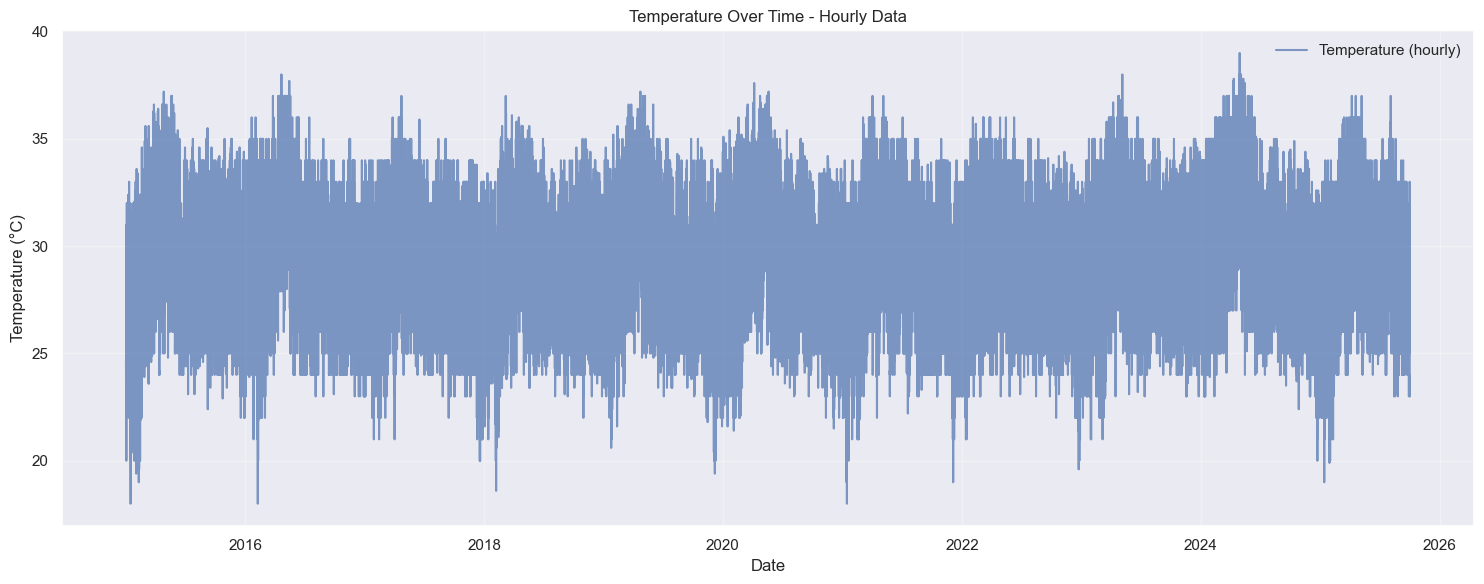

Analyzing 24-hour temperature cycle...


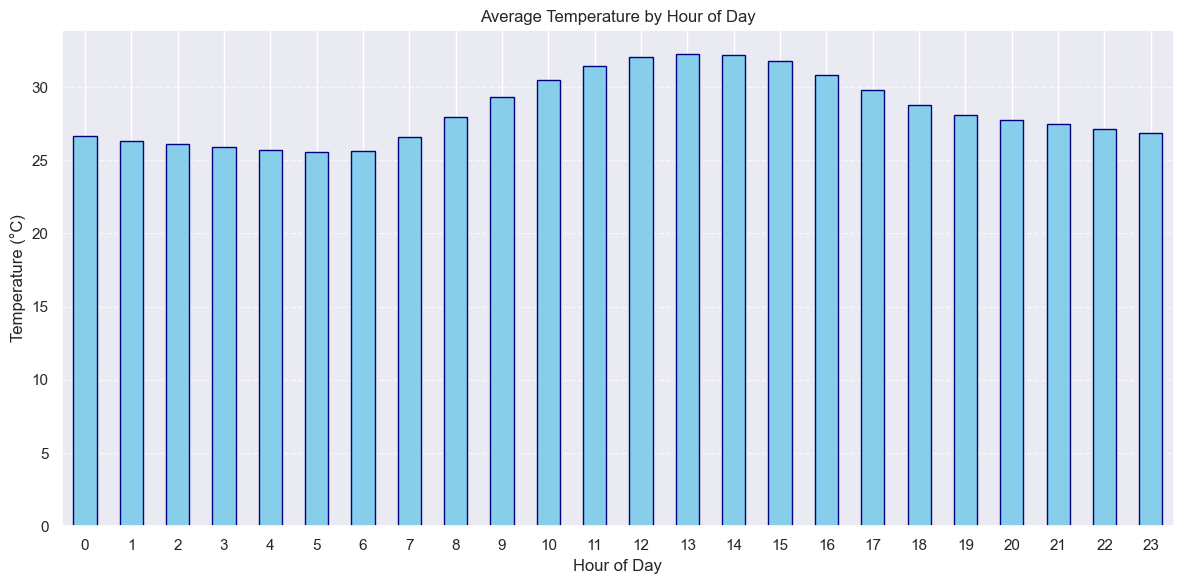

Analyzing variable distributions...


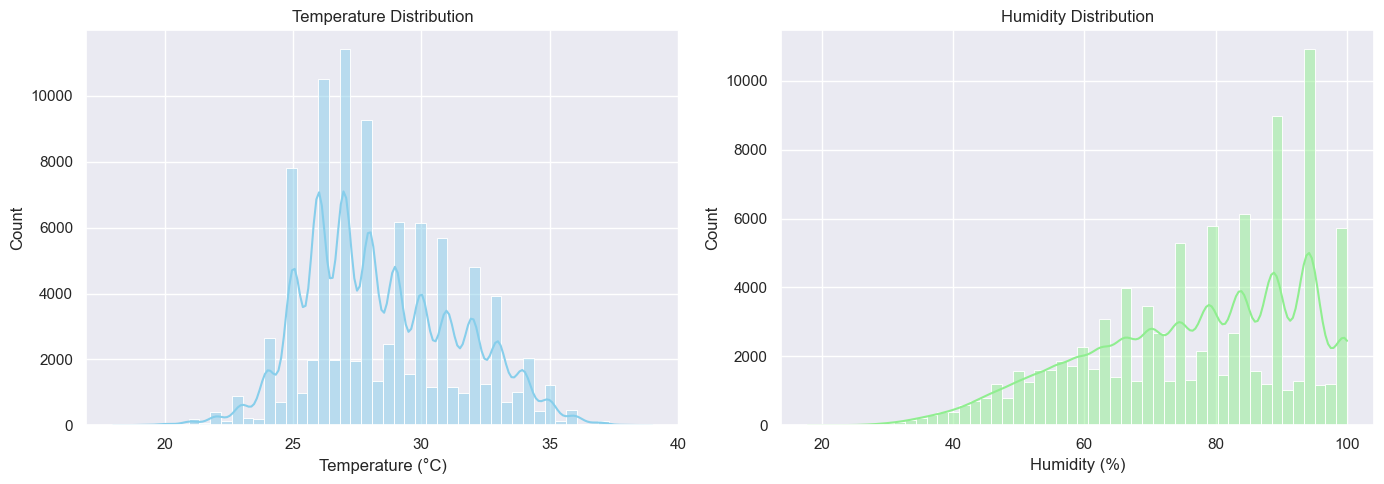

In [40]:
print("=== Exploratory Data Analysis ===")

# Plot temperature over time
plt.figure(figsize=(15, 6))
plt.plot(df_raw_hourly['datetime'], df_raw_hourly['temp'], label='Temperature (hourly)', alpha=0.7)
plt.title('Temperature Over Time - Hourly Data')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze 24-hour cycle 
print("Analyzing 24-hour temperature cycle...")
df_raw_hourly['hour'] = df_raw_hourly['datetime'].dt.hour
hourly_avg = df_raw_hourly.groupby('hour')['temp'].mean()

plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title('Average Temperature by Hour of Day')
plt.ylabel('Temperature (°C)')
plt.xlabel('Hour of Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Distribution analysis
print("Analyzing variable distributions...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_raw_hourly['temp'], kde=True, ax=axes[0], bins=50, color='skyblue')
axes[0].set_title('Temperature Distribution')
axes[0].set_xlabel('Temperature (°C)')

sns.histplot(df_raw_hourly['humidity'], kde=True, ax=axes[1], bins=50, color='lightgreen')
axes[1].set_title('Humidity Distribution')
axes[1].set_xlabel('Humidity (%)')

plt.tight_layout()
plt.show()

                    count                 mean                  min  \
latitude          94248.0               10.776               10.776   
longitude         94248.0              106.701              106.701   
datetime            94248  2020-05-17 11:30:00  2015-01-01 00:00:00   
temp              94248.0            28.443794                 18.0   
feelslike         94248.0            31.669485                 18.0   
dew               94248.0            23.502198                  6.6   
humidity          94248.0            76.570977                 17.9   
precip            94209.0             0.217274                  0.0   
precipprob        94248.0            10.347169                  0.0   
windgust          94199.0            18.153898                  1.4   
windspeed         94248.0            10.028387                  0.0   
winddir           94238.0           185.676691                  0.0   
sealevelpressure  94248.0          1009.112779                999.0   
cloudc

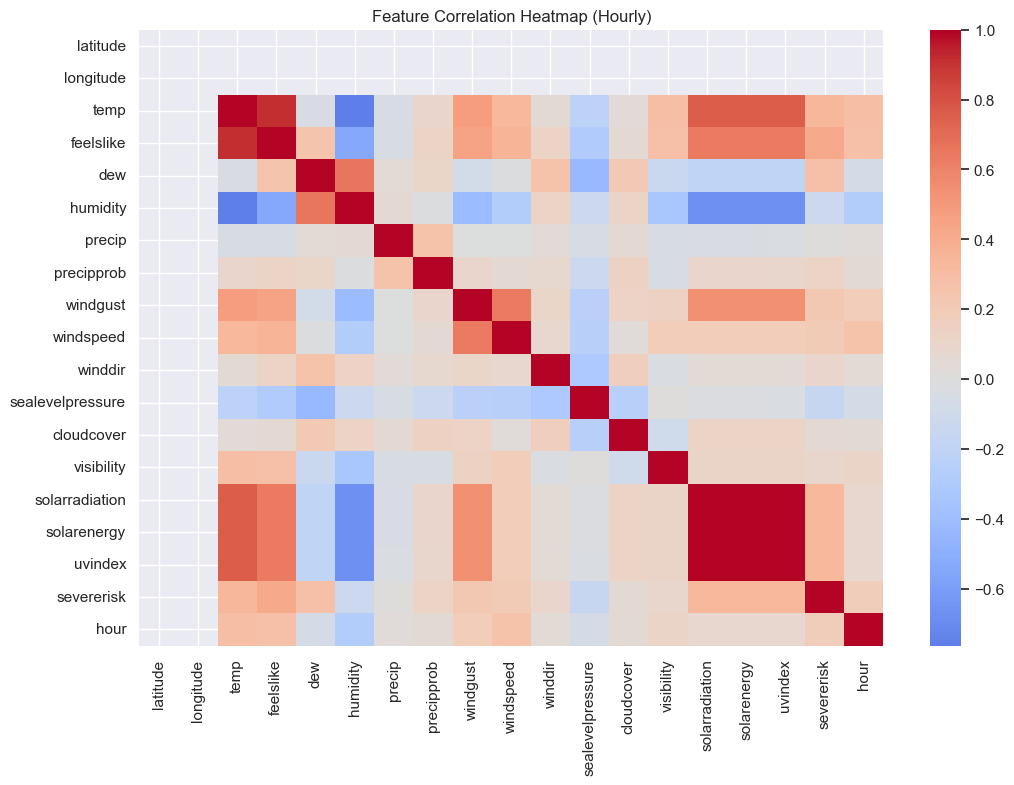

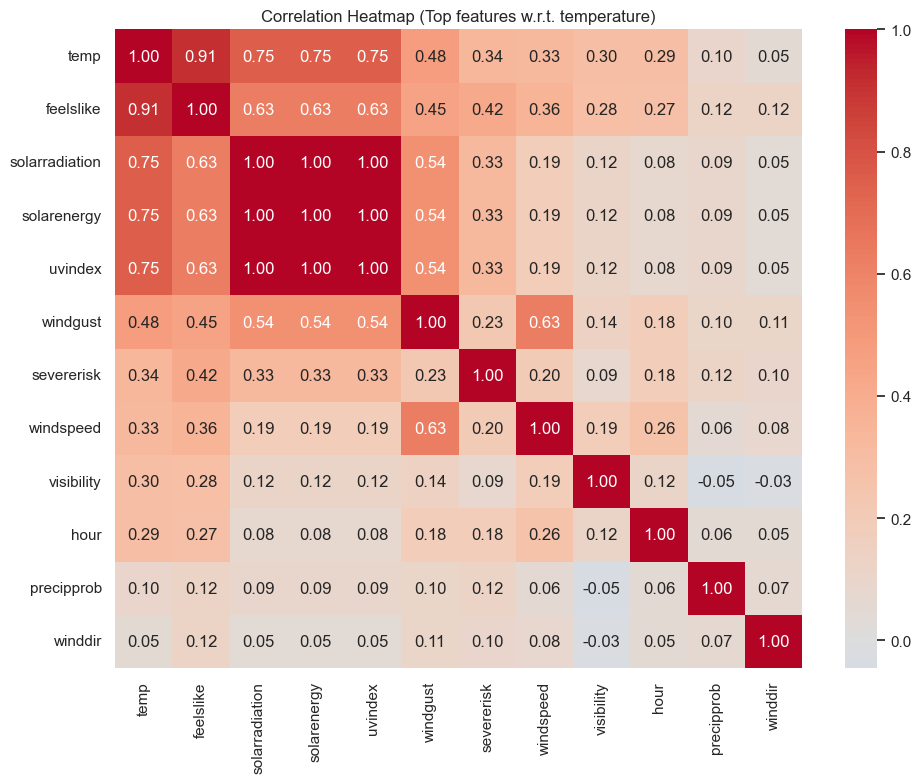

Correlation_with_temp
temp                         1.000000
feelslike                    0.911625
solarradiation               0.753818
solarenergy                  0.753590
uvindex                      0.753254
windgust                     0.478550
severerisk                   0.341084
windspeed                    0.328380
visibility                   0.295847
hour                         0.293892
precipprob                   0.099725
winddir                      0.054258
cloudcover                   0.032066
dew                         -0.038343
precip                      -0.046613

In [41]:
print(df_raw_hourly.describe().T)

# --- Full correlation heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw_hourly.corr(numeric_only=True), cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap (Hourly)")
plt.show()

# --- Correlation with target (temperature) ---
numeric_cols = df_raw_hourly.select_dtypes(include=np.number).columns.tolist()
corr_matrix = df_raw_hourly[numeric_cols].corr()

corr_target = corr_matrix['temp'].sort_values(ascending=False)
top_features = corr_target.index[:12].tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Top features w.r.t. temperature)')
plt.tight_layout()
plt.show()

corr_target_df = corr_target.to_frame(name='Correlation_with_temp')
display(corr_target_df.head(15))


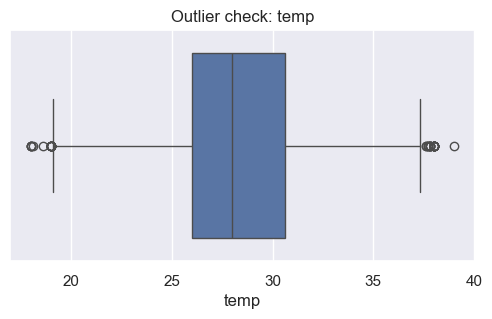

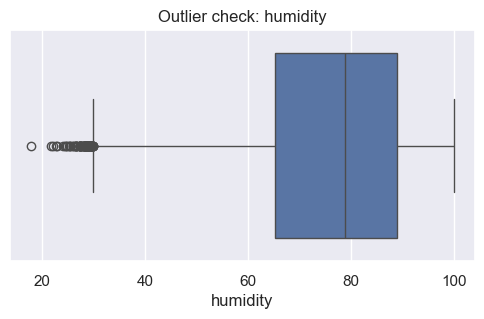

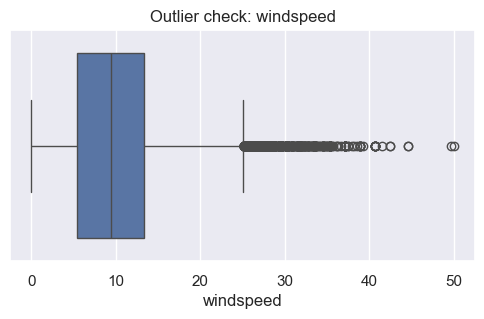

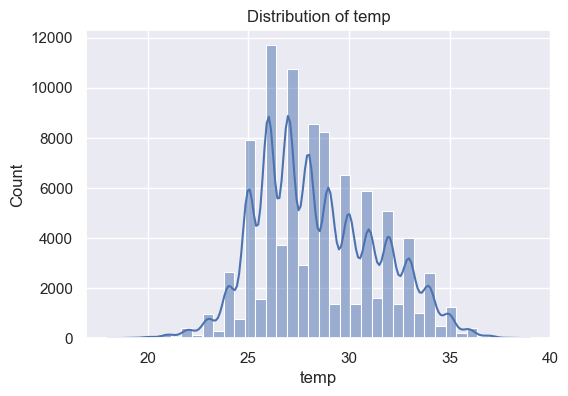

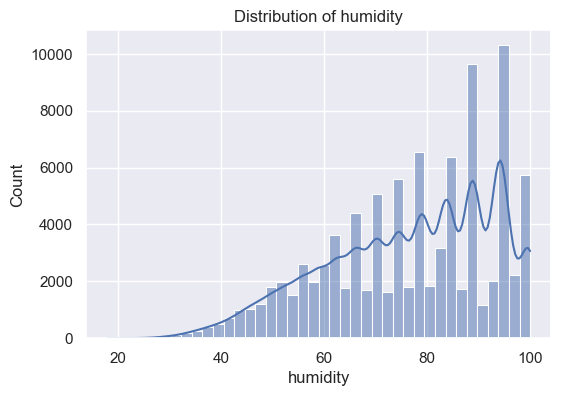

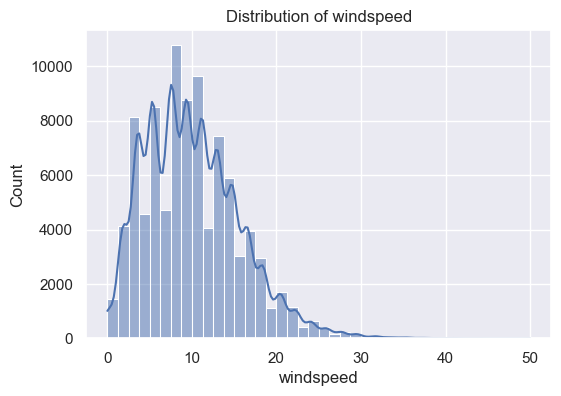

In [42]:

for col in ['temp', 'humidity', 'windspeed']:
    if col in df_raw_hourly.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=df_raw_hourly[col])
        plt.title(f"Outlier check: {col}")
        plt.show()


# Distribution plot
for col in ['temp', 'humidity', 'windspeed']:
    if col in df_raw_hourly.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df_raw_hourly[col], kde=True, bins=40)
        plt.title(f"Distribution of {col}")
        plt.show()


In [43]:
duplicates = df_raw_hourly[df_raw_hourly['datetime'].duplicated()]
if len(duplicates) > 0:
    print(f"Found {len(duplicates)} duplicate rows. Keeping first occurrence.")
    df_raw_hourly = df_raw_hourly.drop_duplicates(subset=['datetime'])

In [44]:
# # === Data Cleaning ===
# print("=== Data Cleaning ===")

# duplicates = df_raw_hourly[df_raw_hourly['datetime'].duplicated()]
# if len(duplicates) > 0:
#     print(f"Found {len(duplicates)} duplicate rows. Removing duplicates...")
#     df_raw_hourly = df_raw_hourly.drop_duplicates(subset=['datetime'])
# else:
#     print("No duplicate timestamps found.")

# for col in ['temp', 'humidity', 'windspeed']:
#     if col in df_raw_hourly.columns:
#         Q1 = df_raw_hourly[col].quantile(0.25)
#         Q3 = df_raw_hourly[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower = Q1 - 1.5 * IQR
#         upper = Q3 + 1.5 * IQR
#         outliers = df_raw_hourly[(df_raw_hourly[col] < lower) | (df_raw_hourly[col] > upper)]
#         if len(outliers) > 0:
#             print(f"Detected {len(outliers)} outliers in {col}. Clipping to IQR range.")
#             df_raw_hourly[col] = np.clip(df_raw_hourly[col], lower, upper)


In [45]:
print("=== Handling Missing Values ===")

# Check missing values in key numeric columns
numeric_cols = ['temp', 'humidity', 'windspeed', 'precip']
print("--- Missing Data (Before) ---")
missing_before = df_raw_hourly[numeric_cols].isna().sum()
print(missing_before)

# Process missing values
df_processed_hourly = df_raw_hourly.copy()
df_processed_hourly = df_processed_hourly.set_index('datetime')

# Interpolate missing values using time-based interpolation
df_processed_hourly[numeric_cols] = df_processed_hourly[numeric_cols].interpolate(method='time')
df_processed_hourly[numeric_cols] = df_processed_hourly[numeric_cols].ffill().bfill()
df_processed_hourly = df_processed_hourly.reset_index()

print("\n--- Missing Data (After) ---")
missing_after = df_processed_hourly[numeric_cols].isna().sum()
print(missing_after)

print(f"\nMissing values handled: {missing_before.sum()} -> {missing_after.sum()}")

=== Handling Missing Values ===
--- Missing Data (Before) ---
temp          0
humidity      0
windspeed     0
precip       39
dtype: int64

--- Missing Data (After) ---
temp         0
humidity     0
windspeed    0
precip       0
dtype: int64

Missing values handled: 39 -> 0


## 8.2. Feature Engineering for Hourly Data


In [46]:
import pandas as pd
import numpy as np
# Giả định: DataFrame df đã được load và có cột 'temp' và 'datetime'

print("=== Feature Engineering for Hourly Data ===")

# Hourly-specific configurations
DEFAULT_HOURLY_HORIZONS = [1, 2, 3, 6, 12, 18, 24, 48, 72, 96, 120]  
DEFAULT_HOURLY_LAGS = [1, 2, 3, 6, 12, 18, 24, 48, 96, 120, 144]  
DEFAULT_HOURLY_ROLLING = [3, 6, 12, 18, 24, 48, 72, 96, 120, 144]  

def prepare_features_hourly(df,
                            horizons=DEFAULT_HOURLY_HORIZONS,
                            lag_values=DEFAULT_HOURLY_LAGS,
                            rolling_windows=DEFAULT_HOURLY_ROLLING):
    """
    Prepare features for hourly weather forecasting.
    Similar to daily version but optimized for hourly data patterns.
    """
    print(f"Starting Feature Engineering: {len(df)} rows")
    print(f"Lags: {lag_values}, Rolling windows: {rolling_windows}, Horizons: {horizons}")
    
    df_work = df.copy()
    df_work['datetime'] = pd.to_datetime(df_work['datetime'])  
    df_work = df_work.sort_values('datetime').reset_index(drop=True)
    df_work['row_id'] = df_work.index

    # 1. Preprocessing
    text_columns = ['conditions', 'icon']  
    
    for col in text_columns:
        if col in df_work.columns:
            df_work[col] = df_work[col].fillna('').astype(str)
            
    df_work['preciptype'] = df_work['preciptype'].fillna('none')
    df_work['severerisk'] = df_work['severerisk'].fillna(0.0)

    # 2. Time Features
    df_work['day_of_year'] = df_work['datetime'].dt.dayofyear
    df_work['month'] = df_work['datetime'].dt.month
    df_work['year'] = df_work['datetime'].dt.year
    df_work['day_of_week'] = df_work['datetime'].dt.dayofweek
    df_work['is_weekend'] = (df_work['day_of_week'] >= 5).astype(int)
    
    # Cyclical encoding for seasonal patterns
    df_work['sin_day_of_year'] = np.sin(2 * np.pi * df_work['day_of_year'] / 366)
    df_work['cos_day_of_year'] = np.cos(2 * np.pi * df_work['day_of_year'] / 366)
    df_work['sin_month'] = np.sin(2 * np.pi * df_work['month'] / 12)
    df_work['cos_month'] = np.cos(2 * np.pi * df_work['month'] / 12)

    # Ensure hour column exists
    if 'hour' not in df_work.columns:
        df_work['hour'] = df_work['datetime'].dt.hour
            
    # Cyclical encoding for 24-hour cycle (crucial for hourly data)
    df_work['sin_hour'] = np.sin(2 * np.pi * df_work['hour'] / 24)
    df_work['cos_hour'] = np.cos(2 * np.pi * df_work['hour'] / 24)
    
    # 4. Lag and Rolling Features
    base_numeric_cols = ['feelslike', 'humidity', 'dew', 'precip', 'precipprob',  
                         'precipcover', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',  
                         'cloudcover', 'visibility', 'solarradiation', 'solarenergy',  
                         'uvindex', 'severerisk']
    base_numeric_cols = [col for col in base_numeric_cols if col in df_work.columns]
    
    # Create lag features
    lag_frames = []
    for lag in lag_values:
        lag_df = df_work[base_numeric_cols].shift(lag)
        lag_df.columns = [f'{col}_lag_{lag}' for col in base_numeric_cols]
        lag_frames.append(lag_df)
    
    # Add temperature lag features separately to avoid data leakage
    temp_lag_frames = []
    for lag in lag_values:
        temp_lag_df = pd.DataFrame(index=df_work.index)
        temp_lag_df[f'temp_lag_{lag}'] = df_work['temp'].shift(lag)
        temp_lag_frames.append(temp_lag_df)
    
    # Combine all lag frames
    all_lag_frames = lag_frames + temp_lag_frames

    # Create rolling features - SAFE VERSION (no data leakage)
    roll_frames = []
    # Correct implementation:
    for window in rolling_windows:
        roll_df = pd.DataFrame(index=df_work.index)
        # Apply shift FIRST, then rolling
        temp_shifted = df_work['temp'].shift(1)
        roll_df[f'temp_lag1_rollmean_{window}'] = temp_shifted.rolling(window, min_periods=1).mean()
        roll_df[f'temp_lag1_rollstd_{window}'] = temp_shifted.rolling(window, min_periods=1).std()
        # For other features, ensure they don't leak future info
        roll_df[f'humidity_rollmean_{window}'] = df_work['humidity'].shift(1).rolling(window, min_periods=1).mean()
        roll_df[f'precip_rollsum_{window}'] = df_work['precip'].shift(1).rolling(window, min_periods=1).sum()
        roll_df[f'windspeed_rollmean_{window}'] = df_work['windspeed'].shift(1).rolling(window, min_periods=1).mean()
        roll_frames.append(roll_df)

    # Concatenate all features
    df_work = pd.concat([df_work] + all_lag_frames + roll_frames, axis=1)

    # 5. Target Creation (Đã sửa đổi cho mục tiêu dự báo nhiệt độ trung bình ngày 5 ngày)
    target_cols = []
    
    # Tạo các target cho 5 ngày tiếp theo
    for day in range(1, 6):
        start_lag = -(24 * day)  # Bắt đầu từ t+1, t+25, t+49,...
        end_lag = -(24 * (day - 1) + 1) # Kết thúc ở t+24, t+48, t+72,...
        
        # Để dễ tính toán, tính Max/Min từ t+1 -> t+24, t+25 -> t+48, v.v.
        # Chúng ta cần sử dụng rolling window 24 giờ trên cột 'temp' đã được shift.
        
        # Shift cột 'temp' lên trên (shift âm) để các giá trị tương lai nằm cùng hàng.
        # Shift -1 sẽ đưa giá trị t+1 lên hàng t.
        # Để lấy cửa sổ [t+1, t+24], ta shift -24 và dùng rolling(window=24).
        
        # Tính Max và Min trong 24 giờ tiếp theo (window=24, dịch chuyển window 24h)
        # Ví dụ: Ngày 1 (t+1 đến t+24): shift(-24) rồi rolling(24)
        # shift_amount = 24 * day 
        # Cần phải dùng .rolling(24) trên một chuỗi đã được shift
        
        # Tạm thời tạo một cột shift để tính toán
        temp_shifted = df_work['temp'].shift(-1) # Giá trị t+1 nằm ở hàng t
        
        # Tạo cột chứa nhiệt độ của ngày hiện tại và 4 ngày sau đó, tổng cộng 5 ngày
        # Với day=1: t+1 đến t+24
        # Với day=2: t+25 đến t+48
        
        # Cắt chuỗi 'temp' và shift lên để window rolling có thể tính toán
        # Chuỗi temp_future[i] chứa temp[i + 1]
        
        # Max/Min trong cửa sổ 24 giờ:
        # Day 1: [t+1, t+24] -> Shift (-1) và Rolling(24)
        # Day 2: [t+25, t+48] -> Shift (-25) và Rolling(24)
        
        # Tính Max và Min cho 24 giờ tiếp theo (t+1 đến t+24)
        # Cột temp ở hàng i là temp tại thời điểm t.
        # temp.shift(-h) ở hàng i là temp tại thời điểm t+h.
        
        # Shift để giá trị cuối cùng của cửa sổ (t+24, t+48,...) nằm ở hàng hiện tại (i)
        
        # Cửa sổ [t+h_start, t+h_end]
        h_end = 24 * day
        h_start = 24 * (day - 1) + 1
        window = h_end - h_start + 1 # Luôn là 24
        
        # Ta cần cửa sổ 24 giờ BẮT ĐẦU từ t+h_start.
        # rolling(window).max().shift(-window + 1)
        # Ví dụ: [t+1, t+24]. rolling(24).max() ở i là max[i-23:i+1]. Ta muốn max[i+1:i+24]
        
        # Tạo chuỗi mới, shift lên, sau đó dùng rolling
        # Lấy cột 'temp' (temp_t). shift(-h_start) sẽ đưa temp_{t+h_start} lên hàng t
        # Cần một chuỗi mà rolling 24 sẽ tính trên [temp_{t+h_start}, ..., temp_{t+h_end}]
        
        # Tạo cửa sổ [t+1, t+24]
        temp_window_start = df_work['temp'].shift(-h_start)
        # Rolling(24) trên chuỗi này sẽ tính [temp_{t+h_start}, ..., temp_{t+h_start + 23}]
        # Tức là [temp_{t+1}, ..., temp_{t+24}] cho day 1.
        
        roll_max = temp_window_start.rolling(window=window).max()
        roll_min = temp_window_start.rolling(window=window).min()
        
        # Sau khi tính, ta cần shift kết quả rolling ngược lại.
        # .rolling().max() là một hàm window *right-aligned* (tính đến cuối window)
        # Giá trị ở hàng i của roll_max/min là Max/Min của window kết thúc ở hàng i.
        # Ta cần Max/Min của window [i+h_start, i+h_end] nằm ở hàng i.
        # Giá trị Max/Min của [t+1, t+24] nằm ở hàng có index là (t+24)-1.
        # Ta cần shift nó ngược lại (lên trên) 24*(day-1) + 1.
        
        # Shift lên (âm) để kết quả [t+h_start, t+h_end] nằm ở hàng t
        target_max_col = f'target_daily_max_day_{day}'
        target_min_col = f'target_daily_min_day_{day}'
        target_avg_col = f'target_avg_day_{day}'
        
        # Dùng shift để tạo cửa sổ: temp.shift(-h_start) đưa temp_{t+h_start} lên hàng t
        # rolling(window) tính max/min của cửa sổ [i, i+window-1] trên chuỗi shift này
        # Sau đó shift ngược lại: max/min của [t+h_start, t+h_end] ở hàng t-h_start.
        # Ta cần shift nó lên trên (shift âm) h_start-1.
        
        # Cách đơn giản nhất:
        df_work[target_max_col] = df_work['temp'].rolling(window=window).max().shift(-h_end)
        df_work[target_min_col] = df_work['temp'].rolling(window=window).min().shift(-h_end)

        # Tính trung bình (Max + Min) / 2
        df_work[target_avg_col] = (df_work[target_max_col] + df_work[target_min_col]) / 2.0
        
        target_cols.append(target_avg_col)
        # Bỏ 2 cột max/min nếu chỉ muốn target cuối cùng là trung bình
        # target_cols.extend([target_max_col, target_min_col])

    # 6. Cleanup and Slicing (Sử dụng max_horizon mới)
    cols_to_drop_final = ['sunrise', 'sunset', 'name', 'address', 'resolvedAddress',  
                          'latitude', 'longitude', 'source']
    cols_present_to_drop = [col for col in cols_to_drop_final if col in df_work.columns]
    if cols_present_to_drop:
        print(f"    - Dropping unnecessary columns: {cols_present_to_drop}")
        df_work = df_work.drop(columns=cols_present_to_drop)
    
    # Tính minimum history cần thiết
    min_history = max(
        max(lag_values, default=0),
        max(rolling_windows, default=0)
    )
    
    # Max horizon mới (ngày 5: t+120)
    max_forecast_horizon = 24 * 5 # 120 giờ
    
    # Calculate valid end index
    # Hàng cuối cùng có target (avg_day_5) là hàng len(df_work) - max_forecast_horizon - 1
    valid_end_index = len(df_work) - max_forecast_horizon
    
    if valid_end_index <= min_history:
        raise ValueError('Not enough data for this configuration. Reduce lags/rolling/horizons.')

    # Slice data to remove NaN rows
    df_model = df_work.iloc[min_history:valid_end_index].copy()
    
    print(f"Final data size for modeling: {len(df_model)} rows")

    # 7. Return Results
    # Cần trả về tất cả các cột target đã tạo (target_avg_day_1 đến target_avg_day_5)
    all_target_cols = [f'target_avg_day_{day}' for day in range(1, 6)]
    # Thêm cả các cột max/min vào df target để tham khảo
    
    # Lọc các cột target
    temp_target_cols = []
    for day in range(1, 6):
        temp_target_cols.extend([f'target_daily_max_day_{day}', f'target_daily_min_day_{day}', f'target_avg_day_{day}'])
        
    target_df = df_model[['row_id'] + [col for col in temp_target_cols if col in df_model.columns]].copy()
    feature_df = df_model.drop(columns=[col for col in temp_target_cols if col in df_model.columns] + ['row_id']).copy()
    
    # ⚠️ Loại bỏ các cột leakage
    to_remove_columns = ['temp']  # Current temperature
    
    columns_to_remove = [col for col in to_remove_columns if col in feature_df.columns]
    if columns_to_remove:
        feature_df = feature_df.drop(columns=columns_to_remove)
        print(f"    - Removed leakage columns: {columns_to_remove}")
    
    # Remove any columns that might contain current temperature info
    suspicious_columns = [col for col in feature_df.columns if 'temp' in col and 'lag' not in col and 'roll' not in col]
    if suspicious_columns:
        feature_df = feature_df.drop(columns=suspicious_columns)
        print(f"    - Removed suspicious temperature columns: {suspicious_columns}")
    
    print(f"    - Feature columns: {len(feature_df.columns)}")
    print(f"    - Target columns (Avg only): {len(all_target_cols)}")

    return feature_df, target_df, all_target_cols

=== Feature Engineering for Hourly Data ===


In [47]:
print("=== Applying Feature Engineering ===")

feature_df_hourly, target_df_hourly, target_cols_hourly = prepare_features_hourly(
    df_processed_hourly, 
    horizons=DEFAULT_HOURLY_HORIZONS,
    lag_values=DEFAULT_HOURLY_LAGS,
    rolling_windows=DEFAULT_HOURLY_ROLLING
)
print(f"✓ Feature Engineering completed")
print(f"- Feature DataFrame shape: {feature_df_hourly.shape}")
print(f"- Target DataFrame shape: {target_df_hourly.shape}")
print(f"- Target columns: {target_cols_hourly}")


=== Applying Feature Engineering ===
Starting Feature Engineering: 94248 rows
Lags: [1, 2, 3, 6, 12, 18, 24, 48, 96, 120, 144], Rolling windows: [3, 6, 12, 18, 24, 48, 72, 96, 120, 144], Horizons: [1, 2, 3, 6, 12, 18, 24, 48, 72, 96, 120]
    - Dropping unnecessary columns: ['name', 'address', 'resolvedAddress', 'latitude', 'longitude', 'source']
Final data size for modeling: 93984 rows
    - Removed leakage columns: ['temp']
    - Feature columns: 257
    - Target columns (Avg only): 5
✓ Feature Engineering completed
- Feature DataFrame shape: (93984, 257)
- Target DataFrame shape: (93984, 16)
- Target columns: ['target_avg_day_1', 'target_avg_day_2', 'target_avg_day_3', 'target_avg_day_4', 'target_avg_day_5']


In [48]:
feature_df_hourly.head(5)

datetime  feelslike   dew  humidity  precip  precipprob  \
144 2015-01-07 00:00:00       24.4  22.0     86.46     0.0         0.0   
145 2015-01-07 01:00:00       24.9  22.1     84.64     0.0         0.0   
146 2015-01-07 02:00:00       24.6  21.6     83.41     0.0         0.0   
147 2015-01-07 03:00:00       24.4  21.6     84.34     0.0         0.0   
148 2015-01-07 04:00:00       24.9  21.2     80.08     0.0         0.0   

    preciptype  windgust  windspeed  winddir  sealevelpressure  cloudcover  \
144       none       7.6        7.6    242.0            1010.0        50.0   
145       none       7.2        5.4    220.0            1009.3        50.9   
146       none       8.3        4.7    228.0            1009.0        50.0   
147       none       8.6        3.6    160.0            1009.0        50.0   
148       none       9.0        3.9    160.0            1009.1        50.9   

     visibility  solarradiation  solarenergy  uvindex  severerisk  \
144        10.0             0.0          0.0      0.0         0.0   
145        10.9             0.0          0.0      0.0         0.0   
146        10.0             0.0          0.0      0.0         0.0   
147        10.0             0.0          0.0      0.0         0.0   
148        10.9             0.0          0.0      0.0         0.0   

           conditions                 icon  hour  day_of_year  month  year  \
144  Partially cloudy  partly-cloudy-night     0            7      1  2015   
145  Partially cloudy  partly-cloudy-night     1            7      1  2015   
146  Partially cloudy  partly-cloudy-night     2            7      1  2015   
147  Partially cloudy  partly-cloudy-night     3            7      1  2015   
148  Partially cloudy  partly-cloudy-night     4            7      1  2015   

     day_of_week  is_weekend  sin_day_of_year  cos_day_of_year  sin_month  \
144            2           0         0.119881         0.992788        0.5   
145            2           0         0.119881         0.992788        0.5   
146            2           0         0.119881         0.992788        0.5   
147            2           0         0.119881         0.992788        0.5   
148            2           0         0.119881         0.992788        0.5   

     cos_month  sin_hour  cos_hour  feelslike_lag_1  humidity_lag_1  \
144   0.866025  0.000000  1.000000             24.4           86.46   
145   0.866025  0.258819  0.965926             24.4           86.46   
146   0.866025  0.500000  0.866025             24.9           84.64   
147   0.866025  0.707107  0.707107             24.6           83.41   
148   0.866025  0.866025  0.500000             24.4           84.34   

     dew_lag_1  precip_lag_1  precipprob_lag_1  windgust_lag_1  \
144       22.0           0.0               0.0             7.6   
145       22.0           0.0               0.0             7.6   
146       22.1           0.0               0.0             7.2   
147       21.6           0.0               0.0             8.3   
148       21.6           0.0               0.0             8.6   

     windspeed_lag_1  winddir_lag_1  sealevelpressure_lag_1  cloudcover_lag_1  \
144              7.6          272.0                  1010.0              50.0   
145              7.6          242.0                  1010.0              50.0   
146              5.4          220.0                  1009.3              50.9   
147              4.7          228.0                  1009.0              50.0   
148              3.6          160.0                  1009.0              50.0   

     visibility_lag_1  solarradiation_lag_1  solarenergy_lag_1  uvindex_lag_1  \
144              10.0                   0.0                0.0            0.0   
145              10.0                   0.0                0.0            0.0   
146              10.9                   0.0                0.0            0.0   
147              10.0                   0.0                0.0            0.0   
148              10.0                 

In [49]:
target_df_hourly.head(5)

row_id  target_daily_max_day_1  target_daily_min_day_1  target_avg_day_1  \
144     144                    32.0                    23.9             27.95   
145     145                    32.0                    23.9             27.95   
146     146                    32.0                    23.9             27.95   
147     147                    32.0                    23.9             27.95   
148     148                    32.0                    23.9             27.95   

     target_daily_max_day_2  target_daily_min_day_2  target_avg_day_2  \
144                    32.4                    23.6             28.00   
145                    32.4                    23.6             28.00   
146                    32.4                    23.6             28.00   
147                    32.4                    23.6             28.00   
148                    32.4                    22.9             27.65   

     target_daily_max_day_3  target_daily_min_day_3  target_avg_day_3  \
144                    32.4                    22.0              27.2   
145                    32.4                    22.0              27.2   
146                    32.4                    22.0              27.2   
147                    32.4                    22.0              27.2   
148                    32.4                    22.0              27.2   

     target_daily_max_day_4  target_daily_min_day_4  target_avg_day_4  \
144                    33.0                    23.9             28.45   
145                    33.0                    23.9             28.45   
146                    33.0                    23.9             28.45   
147                    33.0                    23.9             28.45   
148                    33.0                    24.0             28.50   

     target_daily_max_day_5  target_daily_min_day_5  target_avg_day_5  
144                    30.4                    24.0             27.20  
145                    30.4                    24.0             27.20  
146                    30.4                    24.0             27.20  
147                    30.4                    24.0             27.20  
148                    30.4                    23.9             27.15

## 8.3. Data Splitting and Preprocessing Setup

In [50]:
print("=== Data Splitting and Preprocessing Setup (Hourly Data) ===")

from sklearn.model_selection import TimeSeriesSplit

# === 1. Extract datetime and define leakage buffer ===
LEAKAGE_BUFFER_HOURLY = 336  # 14  days buffer (to prevent leakage)
dates_hourly = feature_df_hourly['datetime'].reset_index(drop=True)

X_hourly = feature_df_hourly.drop(columns=['datetime'])
y_hourly = target_df_hourly[target_cols_hourly]

# === 2. Time-based train-test split (85–15) ===
split_idx = int(len(X_hourly) * 0.85)

X_train_hourly = X_hourly.iloc[:split_idx]
y_train_hourly = y_hourly.iloc[:split_idx]
train_dates_hourly = dates_hourly.iloc[:split_idx]

# Apply leakage buffer before test set
X_test_hourly = X_hourly.iloc[split_idx + LEAKAGE_BUFFER_HOURLY:]
y_test_hourly = y_hourly.iloc[split_idx + LEAKAGE_BUFFER_HOURLY:]
test_dates_hourly = dates_hourly.iloc[split_idx + LEAKAGE_BUFFER_HOURLY:]

print(f"   - Training set: X={X_train_hourly.shape}, y={y_train_hourly.shape}")
print(f"   - Testing set:  X={X_test_hourly.shape}, y={y_test_hourly.shape}")

# === 3. Identify column types for preprocessing ===
print("\nIdentifying column types for preprocessing...")

potential_cat_cols = ['preciptype', 'conditions', 'icon', 'month', 'day_of_week', 'hour', 'year']
categorical_cols_hourly = [col for col in potential_cat_cols if col in X_train_hourly.columns]

text_cols_hourly = []  # none expected after feature engineering

numeric_cols_hourly = [
    col for col in X_train_hourly.columns
    if col not in categorical_cols_hourly + text_cols_hourly
]

print(f"   - Numeric columns: {len(numeric_cols_hourly)}")
print(f"   - Categorical columns: {len(categorical_cols_hourly)}")
print(f"   - Text columns: {len(text_cols_hourly)}")

# === 4. Verify numeric columns ===
non_numeric_found = X_train_hourly[numeric_cols_hourly].select_dtypes(exclude=np.number).columns
if len(non_numeric_found) > 0:
    print(f"   - ✗ WARNING: Non-numeric columns found: {non_numeric_found.tolist()}")
else:
    print("   - ✓ All numeric columns verified as numeric")

# === 5. Initialize TimeSeriesSplit for cross-validation ===
tscv_hourly = ModTimeSeriesSplit(n_splits=5, buffer=LEAKAGE_BUFFER_HOURLY)
print("   - TimeSeriesSplit initialized (n_splits=5, no leakage across folds)")


=== Data Splitting and Preprocessing Setup (Hourly Data) ===
   - Training set: X=(79886, 256), y=(79886, 5)
   - Testing set:  X=(13762, 256), y=(13762, 5)

Identifying column types for preprocessing...
   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0
   - ✓ All numeric columns verified as numeric
   - TimeSeriesSplit initialized (n_splits=5, no leakage across folds)


## 8.4. Hourly Data pipeline


### Naive Baseline for hourly data

In [51]:
model_results_hourly = {}  # To store results for hourly models

In [52]:
print("Naive Persistence Baseline (Hourly)")

# Determine hourly horizons to match the available target columns (avoid mismatch)
try:
    # target_cols_hourly is created by prepare_features_hourly; use its length to derive horizons
    HORIZONS_HOURLY = list(range(1, len(target_cols_hourly) + 1))
except NameError:
    # Fallback: use first 5 of the default hourly horizons if target_cols_hourly is not available
    HORIZONS_HOURLY = DEFAULT_HOURLY_HORIZONS[:5]

def persistence_baseline_hourly(temp_lag_series, horizons):
    """
    Naive persistence baseline: assumes temperature at t+h = temperature at t-1
    """
    # Handle any NaN values by forward/back filling
    temp_lag_clean = pd.Series(temp_lag_series).ffill().bfill().values
    return np.repeat(temp_lag_clean.reshape(-1, 1), len(horizons), axis=1)

# Create predictions (ensure 'temp_lag_1' exists)
if 'temp_lag_1' not in X_train_hourly.columns or 'temp_lag_1' not in X_test_hourly.columns:
    raise KeyError("Column 'temp_lag_1' not found in X_train_hourly / X_test_hourly. Check feature engineering.")

naive_train_preds_hourly = persistence_baseline_hourly(X_train_hourly['temp_lag_1'].values, HORIZONS_HOURLY)
naive_test_preds_hourly = persistence_baseline_hourly(X_test_hourly['temp_lag_1'].values, HORIZONS_HOURLY)

# Store results
model_results_hourly['NaivePersistence_Hourly'] = {
    'train_metrics': compute_metrics(y_train_hourly.values, naive_train_preds_hourly, horizons=HORIZONS_HOURLY),
    'test_metrics': compute_metrics(y_test_hourly.values, naive_test_preds_hourly, horizons=HORIZONS_HOURLY),
    'cv_metrics': None,
    'predictions_test': naive_test_preds_hourly,
    'predictions_train': naive_train_preds_hourly,
    'details': 'Baseline: t+h temperature = t-1 temperature for all horizons (hourly)'
}

print('\n--- Naive baseline metrics (hourly) ---')
display(pd.Series(model_results_hourly['NaivePersistence_Hourly']['test_metrics']).to_frame('NaivePersistence_Hourly').T)

Naive Persistence Baseline (Hourly)

--- Naive baseline metrics (hourly) ---


RMSE_h1    MAE_h1   MAPE_h1     R2_h1   RMSE_h2  \
NaivePersistence_Hourly  2.676779  2.321574  7.859158 -1.522437  2.800296   

                          MAE_h2   MAPE_h2    R2_h2   RMSE_h3    MAE_h3  \
NaivePersistence_Hourly  2.40117  8.131175 -1.75318  2.866447  2.442893   

                          MAPE_h3    R2_h3   RMSE_h4    MAE_h4   MAPE_h4  \
NaivePersistence_Hourly  8.270791 -1.87514  2.892581  2.456133  8.312576   

                            R2_h4   RMSE_h5    MAE_h5   MAPE_h5     R2_h5  \
NaivePersistence_Hourly -1.924161  2.897359  2.455722  8.309613 -1.933604   

                         RMSE_macro  MAE_macro  MAPE_macro  R2_macro  
NaivePersistence_Hourly    2.826692   2.415498    8.176662 -1.801704

Re-run Optuna hyperparameter tuning for HGB with hourly data

In [53]:
# # === RE-RUN OPTUNA HYPERPARAMETER TUNING FOR HGB ===
# # import optuna
# from optuna.samplers import TPESampler


# print("\n--- Step 2: Re-running Optuna Hyperparameter Tuning (Hourly Data) ---")

# print("Starting Optuna tuning for HistGradientBoostingRegressor...")

# def hgb_objective_hourly(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
#         'max_depth': trial.suggest_int('max_depth', 5, 25),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 15, 150),
#         'l2_regularization': trial.suggest_float('l2_regularization', 1e-4, 1.0, log=True)
#     }
#     estimator = MultiOutputRegressor(
#         HistGradientBoostingRegressor(random_state=RANDOM_STATE, **params)
#     )
#     pipeline = make_pipeline(estimator) 

#     fold_metrics = cross_val_evaluate(pipeline, X_train, y_train, tscv) 
#     # Return the metric to minimize (average RMSE across folds)
#     if not fold_metrics: # Handle case where cross_val_evaluate returns empty list
#         print("Warning: cross_val_evaluate returned empty results for this trial.")
#         return float('inf') # Return a high value if evaluation fails

#     rmse_values = [fold['RMSE_macro'] for fold in fold_metrics if 'RMSE_macro' in fold and not np.isnan(fold['RMSE_macro'])]
#     if not rmse_values:
#         print("Warning: No valid RMSE_macro found in cross-validation results for this trial.")
#         return float('inf')

#     rmse_macro = float(np.mean(rmse_values))
#     return rmse_macro

# sampler = TPESampler(seed=RANDOM_STATE)

# study_hgb_hourly = optuna.create_study(direction='minimize', sampler=sampler, study_name='hgb_hourly_tuning')

# try:
#     print(f"Running Optuna with n_trials=30, timeout=1200...")
#     study_hgb_hourly.optimize(hgb_objective_hourly, n_trials=30, timeout=1200)

#     best_hgb_params_hourly = study_hgb_hourly.best_params
#     print(f"\nOptimization finished for HGB!")
#     print(f"Best CV Score (RMSE): {study_hgb_hourly.best_value:.4f}")
#     print(f"Best HGB Hyperparameters (Hourly): {best_hgb_params_hourly}")
# except Exception as e:
#     print(f"\nOptuna optimization failed for HGB: {e}")
#     print("Using default HGB parameters as fallback.")
#     best_hgb_params_hourly = {} # Fallback to default if Optuna fails

In [54]:
print("=== Applying Daily Data Pipeline to Hourly Data ===")

best_hgb_params_hourly = {
    'learning_rate': 0.07172313382240242, 
    'max_depth': 12, 
    'min_samples_leaf': 131, 
    'l2_regularization': 0.0026568368934158193
}

print("Using optimized hyperparameters:")
print(f"   - Learning rate: {best_hgb_params_hourly['learning_rate']:.6f}")
print(f"   - Max depth: {best_hgb_params_hourly['max_depth']}")
print(f"   - Min samples leaf: {best_hgb_params_hourly['min_samples_leaf']}")
print(f"   - L2 regularization: {best_hgb_params_hourly['l2_regularization']:.6f}")

# Create hourly-specific preprocessing function
def build_preprocessor_hourly():
    """Build preprocessor specifically for hourly data columns."""
    transformers = []
    
    # Get column types for hourly data
    potential_cat_cols = ['preciptype', 'conditions', 'icon', 'month', 'day_of_week', 'hour', 'year']
    categorical_cols_hourly = [col for col in potential_cat_cols if col in X_train_hourly.columns]
    text_cols_hourly = []  # No text columns in hourly data after feature engineering
    numeric_cols_hourly = [col for col in X_train_hourly.columns if col not in categorical_cols_hourly + text_cols_hourly]
    
    print(f"   - Numeric columns: {len(numeric_cols_hourly)}")
    print(f"   - Categorical columns: {len(categorical_cols_hourly)}")
    print(f"   - Text columns: {len(text_cols_hourly)}")
    
    if numeric_cols_hourly:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', numeric_transformer, numeric_cols_hourly))
    
    if categorical_cols_hourly:
        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        transformers.append(('cat', categorical_transformer, categorical_cols_hourly))
    
    if text_cols_hourly:
        text_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('flatten', FunctionTransformer(lambda x: x.ravel(), accept_sparse=False)),
            ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1, 2)))
        ])
        transformers.append(('text', text_transformer, text_cols_hourly))
    
    return ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0.0)

def make_pipeline_hourly(estimator):
    """Create pipeline specifically for hourly data."""
    return Pipeline([
        ('preprocess', build_preprocessor_hourly()),
        ('dense', FunctionTransformer(to_dense, accept_sparse=True)),
        ('regressor', estimator)
    ])

model_results_hourly = {}

# Train base models using the hourly-specific pipeline
print("\n--- Training Base Models ---")
estimators_to_train_hourly = {
    'BayesianRidge_Hourly': MultiOutputRegressor(BayesianRidge()),
    'HistGradientBoosting_Hourly': MultiOutputRegressor(
        HistGradientBoostingRegressor(random_state=RANDOM_STATE, **best_hgb_params_hourly)
    )
}

for name, estimator in tqdm(estimators_to_train_hourly.items(), desc='Training base models (hourly)'):
    pipeline = make_pipeline_hourly(estimator)
    pipeline.fit(X_train_hourly, y_train_hourly)
    train_pred = pipeline.predict(X_train_hourly)
    test_pred = pipeline.predict(X_test_hourly)
    
    # Determine horizon length from predictions (robust) or from target_cols_hourly
    horizons_hourly = list(range(1, test_pred.shape[1] + 1))
        
    model_results_hourly[name] = {
        'pipeline': pipeline,
        'train_metrics': compute_metrics(y_train_hourly.values, train_pred, horizons=horizons_hourly),
        'test_metrics': compute_metrics(y_test_hourly.values, test_pred, horizons=horizons_hourly),
        'predictions_train': train_pred,
        'predictions_test': test_pred,
        'details': f'{name} trained on hourly data'
    }
    print(f"   - {name} Test RMSE_macro: {model_results_hourly[name]['test_metrics']['RMSE_macro']:.4f}")




=== Applying Daily Data Pipeline to Hourly Data ===
Using optimized hyperparameters:
   - Learning rate: 0.071723
   - Max depth: 12
   - Min samples leaf: 131
   - L2 regularization: 0.002657

--- Training Base Models ---


Training base models (hourly):   0%|          | 0/2 [00:00<?, ?it/s]

   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0
   - BayesianRidge_Hourly Test RMSE_macro: 1.0818
   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0
   - HistGradientBoosting_Hourly Test RMSE_macro: 1.0422


In [55]:
# Create ensemble and apply variance correction
ensemble_sources_hourly = ['BayesianRidge_Hourly', 'HistGradientBoosting_Hourly']
available_ensemble_hourly = [name for name in ensemble_sources_hourly if name in model_results_hourly]

if len(available_ensemble_hourly) == 0:
    print("Ensemble skipped: no available hourly models found in model_results_hourly.")
else:
    # compute ensemble predictions (average)
    preds_list_test = [model_results_hourly[name]['predictions_test'] for name in available_ensemble_hourly]
    preds_list_train = [model_results_hourly[name]['predictions_train'] for name in available_ensemble_hourly]

    ensemble_test_preds_hourly = np.mean(preds_list_test, axis=0)
    ensemble_train_preds_hourly = np.mean(preds_list_train, axis=0)

    # determine actual horizons from prediction shape to avoid index errors
    horizons_actual = list(range(1, ensemble_test_preds_hourly.shape[1] + 1))

    model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly'] = {
        'train_metrics': compute_metrics(y_train_hourly.values, ensemble_train_preds_hourly, horizons=horizons_actual),
        'test_metrics': compute_metrics(y_test_hourly.values, ensemble_test_preds_hourly, horizons=horizons_actual),
        'predictions_train': ensemble_train_preds_hourly,
        'predictions_test': ensemble_test_preds_hourly,
        'details': f'Simple average ensemble (hourly) of: {available_ensemble_hourly}'
    }
    print(f"   - Ensemble Test RMSE_macro: {model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly']['test_metrics']['RMSE_macro']:.4f}")

    # Apply variance correction (use the ensemble preds just computed)
    ensemble_test_preds_corr_hourly = apply_variance_correction(ensemble_test_preds_hourly, y_train_hourly.values, method='adaptive')
    ensemble_train_preds_corr_hourly = apply_variance_correction(ensemble_train_preds_hourly, y_train_hourly.values, method='adaptive')

    model_results_hourly['BayesianRidge_HGB_Ensemble_VarCorr_Hourly'] = {
        'train_metrics': compute_metrics(y_train_hourly.values, ensemble_train_preds_corr_hourly, horizons=horizons_actual),
        'test_metrics': compute_metrics(y_test_hourly.values, ensemble_test_preds_corr_hourly, horizons=horizons_actual),
        'predictions_train': ensemble_train_preds_corr_hourly,
        'predictions_test': ensemble_test_preds_corr_hourly,
        'details': f'Variance-corrected ensemble (hourly)'
    }
    print(f"   - VarCorr Ensemble Test RMSE_macro: {model_results_hourly['BayesianRidge_HGB_Ensemble_VarCorr_Hourly']['test_metrics']['RMSE_macro']:.4f}")


   - Ensemble Test RMSE_macro: 1.0183
   - VarCorr Ensemble Test RMSE_macro: 0.9996


In [56]:
# Update residual booster functions for hourly data
def fit_residual_booster_hourly(X_train, y_train, y_pred_train):
    """Fit a small HGB regressor on residuals per horizon using preprocessed features for hourly data."""
    y_train = np.asarray(y_train)
    y_pred_train = np.asarray(y_pred_train)
    n_samples, n_horizons = y_pred_train.shape
    boosters = []
    res_train = y_train - y_pred_train

    # Use the hourly preprocessor to transform X_train first
    preprocessor = build_preprocessor_hourly()
    X_train_transformed = preprocessor.fit_transform(X_train)

    if hasattr(X_train_transformed, 'toarray'):
        X_train_transformed = X_train_transformed.toarray()

    for h in range(n_horizons):
        booster = HistGradientBoostingRegressor(max_depth=3, max_iter=100, learning_rate=0.05)
        booster.fit(X_train_transformed, res_train[:, h])
        boosters.append(booster)
    return boosters, preprocessor

def apply_residual_booster_hourly(X_test, y_pred_test, boosters, preprocessor):
    """Apply residual booster to test predictions using preprocessed features for hourly data."""
    y_pred_test = np.asarray(y_pred_test)
    n_samples, n_horizons = y_pred_test.shape
    y_final = y_pred_test.copy()

    # Transform X_test using the same preprocessor
    X_test_transformed = preprocessor.transform(X_test)

    if hasattr(X_test_transformed, 'toarray'):
        X_test_transformed = X_test_transformed.toarray()

    for h in range(n_horizons):
        res_hat_test = boosters[h].predict(X_test_transformed)
        y_final[:, h] += res_hat_test
    return y_final

print("--- Applying Residual Booster ---")

base_ensemble_train_preds_hourly = model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly']['predictions_train']
base_ensemble_test_preds_hourly = model_results_hourly['BayesianRidge_HGB_Ensemble_Hourly']['predictions_test']
        
boosters_hourly, booster_preprocessor_hourly = fit_residual_booster_hourly(
    X_train_hourly, y_train_hourly.values, base_ensemble_train_preds_hourly
)
        
residual_boosted_preds_hourly = apply_residual_booster_hourly(
    X_test_hourly, base_ensemble_test_preds_hourly, boosters_hourly, booster_preprocessor_hourly
)

# Determine actual horizons from prediction shape to avoid index errors
horizons_actual_hourly = list(range(1, residual_boosted_preds_hourly.shape[1] + 1))

model_results_hourly['ResidualBooster_Ensemble_Hourly'] = {
    'test_metrics': compute_metrics(y_test_hourly.values, residual_boosted_preds_hourly, horizons=horizons_actual_hourly),
    'predictions_test': residual_boosted_preds_hourly,
    'details': 'Residual booster (HGB per horizon) applied to hourly ensemble'
}
print(f"   - Residual Booster Ensemble Test RMSE_macro: {model_results_hourly['ResidualBooster_Ensemble_Hourly']['test_metrics']['RMSE_macro']:.4f}")


--- Applying Residual Booster ---
   - Numeric columns: 249
   - Categorical columns: 7
   - Text columns: 0
   - Residual Booster Ensemble Test RMSE_macro: 1.0169


In [57]:
model_results_hourly['ResidualBooster_Ensemble_Hourly']['test_metrics']

{'RMSE_h1': 0.8203493639067165,
 'MAE_h1': 0.635991195897491,
 'MAPE_h1': 2.176260139339203,
 'R2_h1': 0.7630847104045102,
 'RMSE_h2': 0.9968998744868055,
 'MAE_h2': 0.7791373340215656,
 'MAPE_h2': 2.674678458853383,
 'R2_h2': 0.651076777677984,
 'RMSE_h3': 1.0749800774461133,
 'MAE_h3': 0.8407072323907517,
 'MAPE_h3': 2.890373009166456,
 'R2_h3': 0.5956363868475483,
 'RMSE_h4': 1.094124164808751,
 'MAE_h4': 0.8540763567949038,
 'MAPE_h4': 2.9394599287374525,
 'R2_h4': 0.5816271202604443,
 'RMSE_h5': 1.0980241577895675,
 'MAE_h5': 0.8627838598427231,
 'MAPE_h5': 2.9698788581255537,
 'R2_h5': 0.5786716629976691,
 'RMSE_macro': 1.0168755276875907,
 'MAE_macro': 0.7945391957894871,
 'MAPE_macro': 2.73013007884441,
 'R2_macro': 0.6340193316376312}

In [58]:
print("--- Applying Final Combined Model Logic from Daily Data ---")

# The proven logic from daily data:
# Horizon 1: ResidualBooster_Ensemble (best for short-term)
# Horizon 2-5: BayesianRidge_HGB_Ensemble_VarCorr (best for medium/long-term)

# For hourly data:
# Horizon 1h: ResidualBooster_Ensemble_Hourly
# Horizon 3h, 6h, 12h, 24h: BayesianRidge_HGB_Ensemble_VarCorr_Hourly

required_models_final = ['ResidualBooster_Ensemble_Hourly', 'BayesianRidge_HGB_Ensemble_VarCorr_Hourly']
missing_models_final = [model for model in required_models_final if model not in model_results_hourly]

if missing_models_final:
    raise RuntimeError(f"Cannot build final combined hourly model. Missing models: {missing_models_final}")

# Get predictions from both models
residual_boosted_preds_final = model_results_hourly['ResidualBooster_Ensemble_Hourly']['predictions_test']
varcorr_preds_final = model_results_hourly['BayesianRidge_HGB_Ensemble_VarCorr_Hourly']['predictions_test']

print(f"ResidualBooster_Ensemble_Hourly shape: {residual_boosted_preds_final.shape}")
print(f"BayesianRidge_HGB_Ensemble_VarCorr_Hourly shape: {varcorr_preds_final.shape}")

# Ensure compatible shapes: use the minimum number of horizons available from both models
n_rows_res, n_horiz_res = residual_boosted_preds_final.shape
n_rows_var, n_horiz_var = varcorr_preds_final.shape

if n_rows_res != n_rows_var:
    raise RuntimeError(f"Row count mismatch between models: residual={n_rows_res}, varcorr={n_rows_var}")

n_horiz_min = min(n_horiz_res, n_horiz_var)

# Build final predictions with safe column alignment:
# - keep horizon 0 (index 0) from residual booster
# - for horizons 1..n_horiz_min-1 take from varcorr
final_test_preds_hourly = residual_boosted_preds_final[:, :n_horiz_min].copy()
if n_horiz_min > 1:
    final_test_preds_hourly[:, 1:] = varcorr_preds_final[:, 1:n_horiz_min]

# Derive the correct horizons list matching the number of prediction columns
horizons_actual_hourly = list(range(1, final_test_preds_hourly.shape[1] + 1))

# Calculate final metrics using matching horizons (avoid using DEFAULT_HOURLY_HORIZONS)
final_test_metrics_hourly = compute_metrics(y_test_hourly.values[:, :final_test_preds_hourly.shape[1]],
                                           final_test_preds_hourly,
                                           horizons=horizons_actual_hourly)

# Store the final combined model
model_results_hourly['Final_Combined_Model_Hourly'] = {
    'test_metrics': final_test_metrics_hourly,
    'predictions_test': final_test_preds_hourly,
    'details': ('Final Combined Model (Hourly): Horizon 1 from ResidualBooster; '
                f'Horizons 2..{horizons_actual_hourly[-1]} from VarCorr')
}

print(f"\nFinal Combined Model (Hourly) Test RMSE_macro: {final_test_metrics_hourly['RMSE_macro']:.4f}")


--- Applying Final Combined Model Logic from Daily Data ---
ResidualBooster_Ensemble_Hourly shape: (13762, 5)
BayesianRidge_HGB_Ensemble_VarCorr_Hourly shape: (13762, 5)

Final Combined Model (Hourly) Test RMSE_macro: 0.9990


## 8.5. Results Summary and Visualization

In [59]:
summary_rows_hourly = []
for name, res in model_results_hourly.items():
    if 'test_metrics' in res and res['test_metrics'] is not None:
        test_metrics = res['test_metrics']
        summary_rows_hourly.append({
            'Model': name,
            'RMSE_macro': test_metrics.get('RMSE_macro', np.nan),
            'MAE_macro': test_metrics.get('MAE_macro', np.nan),
            'MAPE_macro': test_metrics.get('MAPE_macro', np.nan),
            'R2_macro': test_metrics.get('R2_macro', np.nan)
        })

summary_df_hourly = pd.DataFrame(summary_rows_hourly).sort_values('RMSE_macro')
print("\n--- Model Performance Summary (Test Set - Hourly):---")
display(summary_df_hourly)

horizon_metrics_hourly = []
for name, res in model_results_hourly.items():
    if 'test_metrics' in res and res['test_metrics'] is not None:
        row = {'Model': name}
        for horizon in DEFAULT_HOURLY_HORIZONS:
            row[f'RMSE_h{horizon}'] = res['test_metrics'].get(f'RMSE_h{horizon}', np.nan)
        horizon_metrics_hourly.append(row)

horizon_df_hourly = pd.DataFrame(horizon_metrics_hourly).set_index('Model')
valid_models = [m for m in summary_df_hourly['Model'].tolist() if m in horizon_df_hourly.index]
horizon_df_hourly = horizon_df_hourly.loc[valid_models]
print("\n--- Model Performance by Horizon (Test Set - Hourly): ---")
display(horizon_df_hourly)

best_model_name_hourly = summary_df_hourly.iloc[0]['Model']
best_rmse_hourly = summary_df_hourly.iloc[0]['RMSE_macro']

print(f"\nBest Model: {best_model_name_hourly}")
print(f"   - RMSE_macro: {best_rmse_hourly:.4f}")

daily_rmse = model_results['Final_Combined_Model']['test_metrics']['RMSE_macro']
print(f"\n--- Comparison with Daily Data: ---")
print(f"   - Daily Data RMSE_macro: {daily_rmse:.4f}")
print(f"   - Hourly Data RMSE_macro: {best_rmse_hourly:.4f}")
print(f"   - Difference: {abs(daily_rmse - best_rmse_hourly):.4f}")


--- Model Performance Summary (Test Set - Hourly):---


Model  RMSE_macro  MAE_macro  \
5                Final_Combined_Model_Hourly    0.998984   0.777322   
3  BayesianRidge_HGB_Ensemble_VarCorr_Hourly    0.999556   0.777681   
4            ResidualBooster_Ensemble_Hourly    1.016876   0.794539   
2          BayesianRidge_HGB_Ensemble_Hourly    1.018301   0.794487   
1                HistGradientBoosting_Hourly    1.042249   0.819176   
0                       BayesianRidge_Hourly    1.081766   0.840520   

   MAPE_macro  R2_macro  
5    2.670518  0.647347  
3    2.671630  0.647016  
4    2.730130  0.634019  
2    2.730694  0.633236  
1    2.791640  0.616110  
0    2.907849  0.583726


--- Model Performance by Horizon (Test Set - Hourly): ---


RMSE_h1   RMSE_h2   RMSE_h3  \
Model                                                                     
Final_Combined_Model_Hourly                0.820349  0.984716  1.049976   
BayesianRidge_HGB_Ensemble_VarCorr_Hourly  0.823206  0.984716  1.049976   
ResidualBooster_Ensemble_Hourly            0.820349  0.996900  1.074980   
BayesianRidge_HGB_Ensemble_Hourly          0.826973  1.002521  1.071677   
HistGradientBoosting_Hourly                0.856517  1.023568  1.094242   
BayesianRidge_Hourly                       0.839553  1.034627  1.130211   

                                           RMSE_h6  RMSE_h12  RMSE_h18  \
Model                                                                    
Final_Combined_Model_Hourly                    NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_VarCorr_Hourly      NaN       NaN       NaN   
ResidualBooster_Ensemble_Hourly                NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_Hourly              NaN       NaN       NaN   
HistGradientBoosting_Hourly                    NaN       NaN       NaN   
BayesianRidge_Hourly                           NaN       NaN       NaN   

                                           RMSE_h24  RMSE_h48  RMSE_h72  \
Model                                                                     
Final_Combined_Model_Hourly                     NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_VarCorr_Hourly       NaN       NaN       NaN   
ResidualBooster_Ensemble_Hourly                 NaN       NaN       NaN   
BayesianRidge_HGB_Ensemble_Hourly               NaN       NaN       NaN   
HistGradientBoosting_Hourly                     NaN       NaN       NaN   
BayesianRidge_Hourly                            NaN       NaN       NaN   

                                           RMSE_h96  RMSE_h120  
Model                                                           
Final_Combined_Model_Hourly                     NaN        NaN  
BayesianRidge_HGB_Ensemble_VarCorr_Hourly       NaN        NaN  
ResidualBooster_Ensemble_Hourly                 NaN        NaN  
BayesianRidge_HGB_Ensemble_Hourly               NaN        NaN  
HistGradientBoosting_Hourly                     NaN        NaN  
BayesianRidge_Hourly                            NaN        NaN


Best Model: Final_Combined_Model_Hourly
   - RMSE_macro: 0.9990

--- Comparison with Daily Data: ---
   - Daily Data RMSE_macro: 0.9538
   - Hourly Data RMSE_macro: 0.9990
   - Difference: 0.0452


=== Visualization: Daily Avg Temp Forecast vs. Actual ===


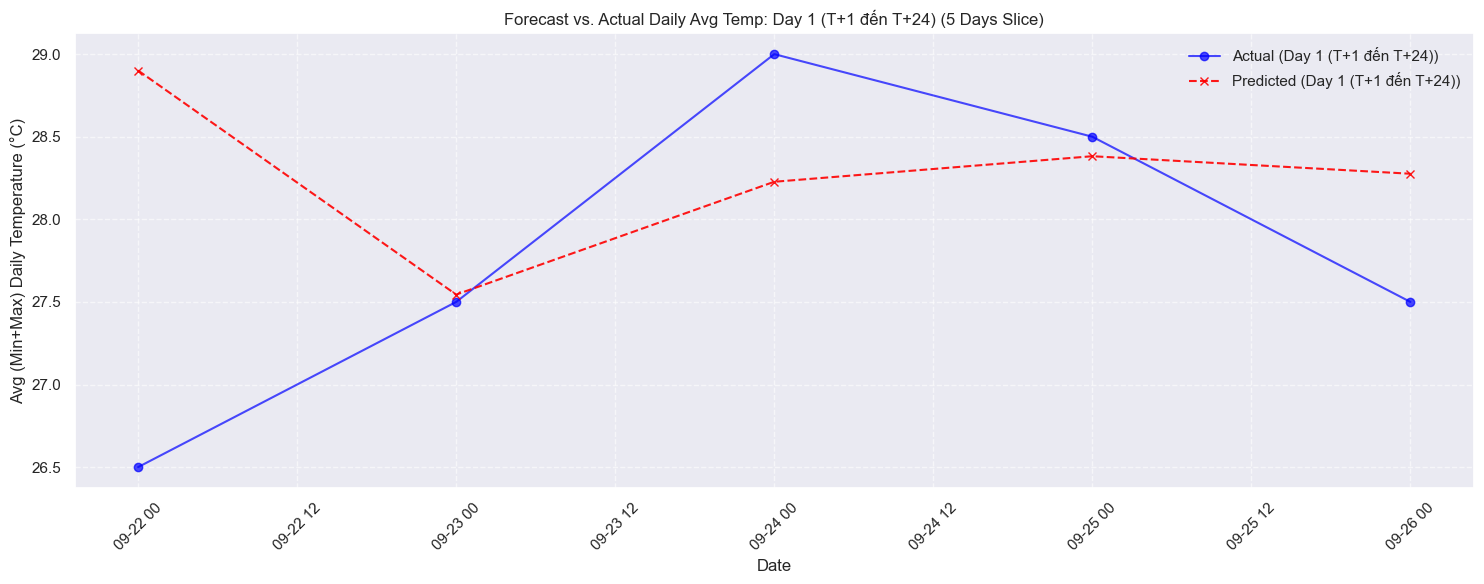

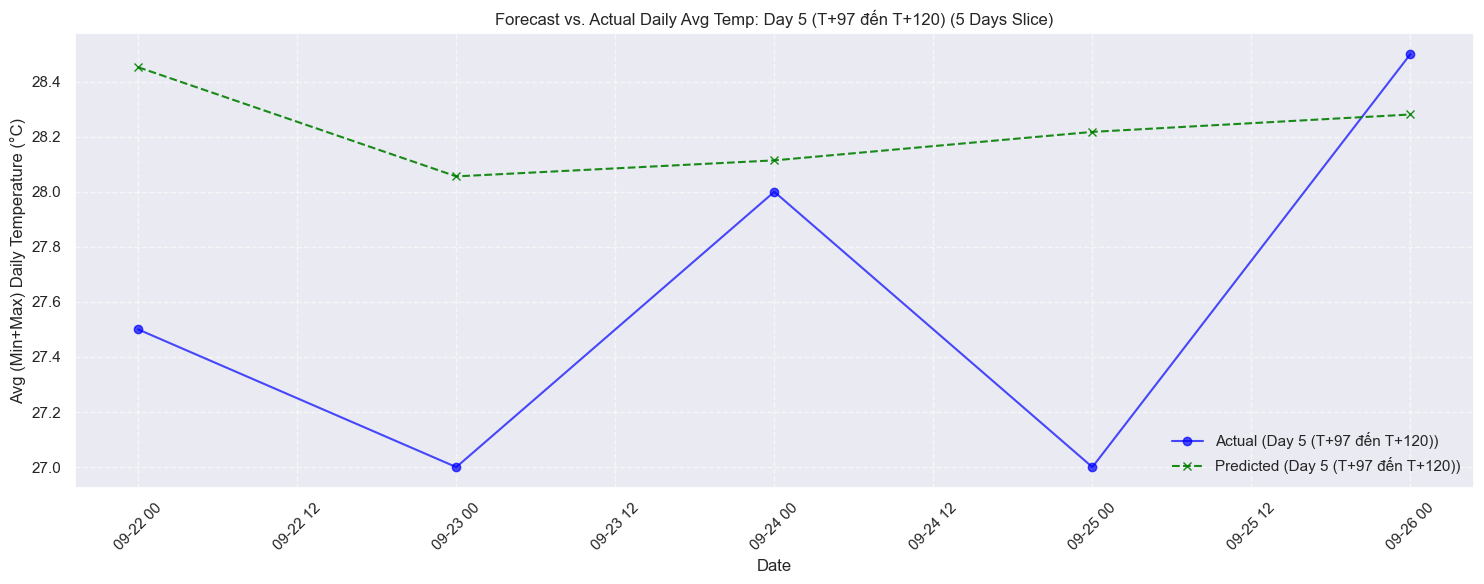

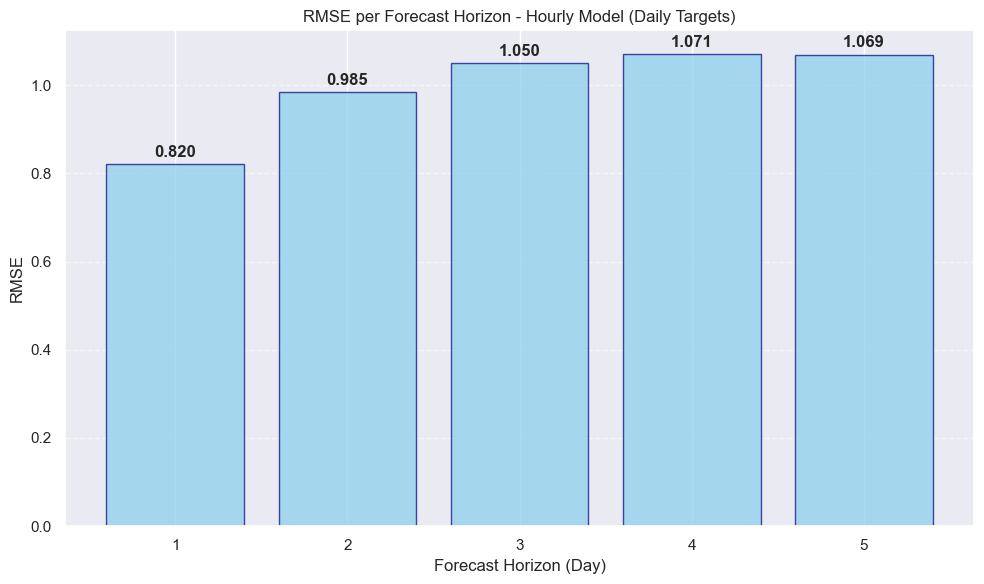

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Cần thiết cho việc xử lý DataFrame/Series

# Lấy dữ liệu từ kết quả mô hình cuối cùng
best_predictions_hourly = model_results_hourly['Final_Combined_Model_Hourly']['predictions_test']
test_metrics_hourly = model_results_hourly['Final_Combined_Model_Hourly']['test_metrics']

# --- CĂN CHỈNH TẦN SUẤT DAILY (Mục tiêu chính) ---
# 1. Xác định phạm vi thời gian (5 ngày cuối cùng)
slice_hours = 5 * 24
slice_idx = max(0, len(test_dates_hourly) - slice_hours)
time_range_hourly = test_dates_hourly.iloc[slice_idx:]

# 2. Tạo mặt nạ Daily: Chọn hàng đầu tiên của mỗi ngày (mỗi 24 hàng)
daily_mask = np.arange(len(time_range_hourly)) % 24 == 0
daily_time = time_range_hourly[daily_mask]

# 3. Lấy số lượng Horizon (Ngày) thực tế mà mô hình dự đoán
n_horiz_model = best_predictions_hourly.shape[1]
horizons_model = list(range(1, n_horiz_model + 1))

print("=== Visualization: Daily Avg Temp Forecast vs. Actual ===")

# --- VẼ ĐỒ THỊ 1: NGÀY ĐẦU TIÊN (Day 1 / Horizon 1) ---
horizon_day_1_idx = 0
horizon_day_1_label = f'Day 1 (T+1 đến T+24)'

# Áp dụng Daily Mask để chỉ lấy một điểm dữ liệu mỗi ngày
actual_daily_h1 = y_test_hourly.iloc[slice_idx:, horizon_day_1_idx].values[daily_mask]
predicted_daily_h1 = best_predictions_hourly[slice_idx:, horizon_day_1_idx][daily_mask]

plt.figure(figsize=(15, 6))
plt.plot(daily_time, actual_daily_h1,
         label=f'Actual ({horizon_day_1_label})', marker='o', linestyle='-', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(daily_time, predicted_daily_h1,
         label=f'Predicted ({horizon_day_1_label})', marker='x', linestyle='--', linewidth=1.5, color='red', alpha=0.9)

plt.title(f'Forecast vs. Actual Daily Avg Temp: {horizon_day_1_label} (5 Days Slice)')
plt.ylabel('Avg (Min+Max) Daily Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- VẼ ĐỒ THỊ 2: NGÀY CUỐI CÙNG (Day N / Horizon N) ---
last_horizon_idx = n_horiz_model - 1
last_horizon_label = f'Day {n_horiz_model} (T+{24*n_horiz_model-23} đến T+{24*n_horiz_model})'

# Áp dụng Daily Mask
actual_daily_last = y_test_hourly.iloc[slice_idx:, last_horizon_idx].values[daily_mask]
predicted_daily_last = best_predictions_hourly[slice_idx:, last_horizon_idx][daily_mask]

plt.figure(figsize=(15, 6))
plt.plot(daily_time, actual_daily_last,
         label=f'Actual ({last_horizon_label})', marker='o', linestyle='-', linewidth=1.5, color='blue', alpha=0.7)
plt.plot(daily_time, predicted_daily_last,
         label=f'Predicted ({last_horizon_label})', marker='x', linestyle='--', linewidth=1.5, color='green', alpha=0.9)

plt.title(f'Forecast vs. Actual Daily Avg Temp: {last_horizon_label} (5 Days Slice)')
plt.ylabel('Avg (Min+Max) Daily Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- VẼ ĐỒ THỊ 3: RMSE THEO HORIZON (NGÀY) ---
rmse_values = [test_metrics_hourly.get(f'RMSE_h{h}', np.nan) for h in horizons_model]

plt.figure(figsize=(10, 6))
bars = plt.bar(horizons_model, rmse_values, alpha=0.7, color='skyblue', edgecolor='navy')
plt.title('RMSE per Forecast Horizon - Hourly Model (Daily Targets)')
plt.xlabel('Forecast Horizon (Day)')
plt.ylabel('RMSE')
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

for i, v in enumerate(rmse_values):
    if np.isnan(v):
        label = 'nan'
    else:
        label = f'{v:.3f}'
    plt.text(horizons_model[i], (0.01 if np.isnan(v) else v) + 0.01, label, ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

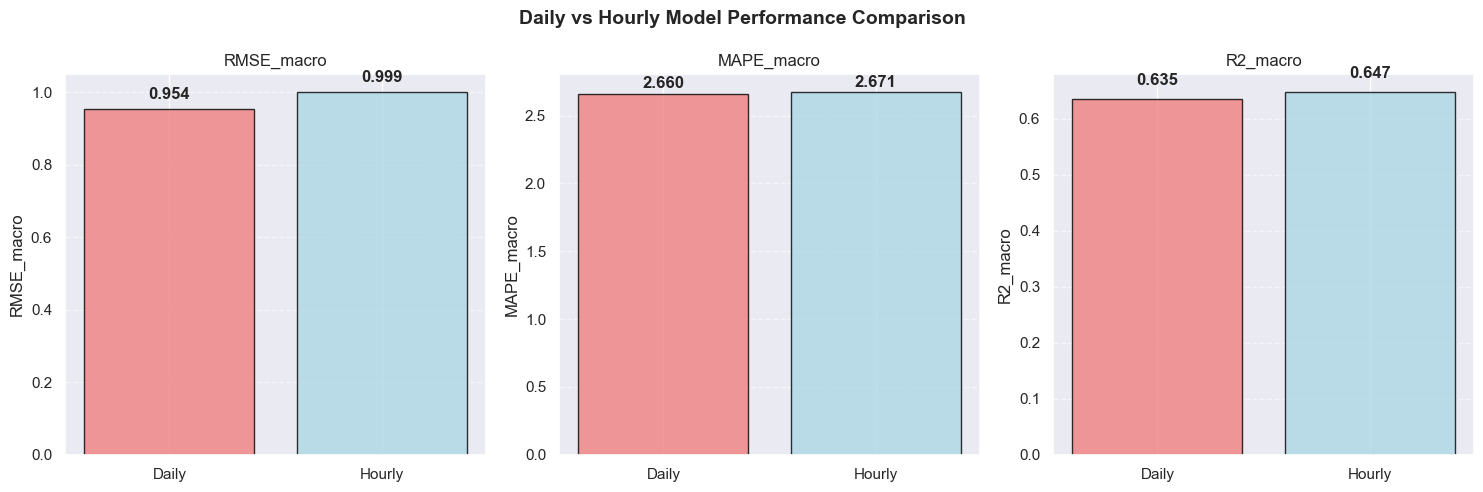

In [61]:
daily_metrics = model_results['Final_Combined_Model']['test_metrics']
hourly_metrics = model_results_hourly['Final_Combined_Model_Hourly']['test_metrics']

daily_rmse = daily_metrics['RMSE_macro']
hourly_rmse = hourly_metrics['RMSE_macro']

daily_mape = daily_metrics['MAPE_macro']
hourly_mape = hourly_metrics['MAPE_macro']

daily_r2 = daily_metrics['R2_macro']
hourly_r2 = hourly_metrics['R2_macro']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE_macro', 'MAPE_macro', 'R2_macro']
daily_values = [daily_rmse, daily_mape, daily_r2]
hourly_values = [hourly_rmse, hourly_mape, hourly_r2]
colors = ['lightcoral', 'lightblue']

for i, metric in enumerate(metrics):
    ax[i].bar(['Daily', 'Hourly'], [daily_values[i], hourly_values[i]],
              color=colors, alpha=0.8, edgecolor='black')
    ax[i].set_title(metric)
    ax[i].grid(axis='y', linestyle='--', alpha=0.6)
    ax[i].set_ylabel(metric)

    for j, v in enumerate([daily_values[i], hourly_values[i]]):
        ax[i].text(j, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

fig.suptitle('Daily vs Hourly Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
